# Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Описание данных**<br />
Name — название игры<br />
Platform — платформа<br />
Year_of_Release — год выпуска<br />
Genre — жанр игры<br />
NA_sales — продажи в Северной Америке (миллионы проданных копий)<br />
EU_sales — продажи в Европе (миллионы проданных копий)<br />
JP_sales — продажи в Японии (миллионы проданных копий)<br />
Other_sales — продажи в других странах (миллионы проданных копий)<br />
Critic_Score — оценка критиков (максимум 100)<br />
User_Score — оценка пользователей (максимум 10)<br />
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.<br />
Данные за 2016 год могут быть неполными.

## **Подготовительные работы**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
from urllib.parse import urlencode 
import requests
import warnings
from scipy import stats as st
from scipy.stats import norm
import statistics

Отключение вывода в окно с прокруткой:

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Отключение settingwithcopywarning
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## **Изучение информации**

### Исходные данные

#### Загрузка исходных данных:

In [6]:
data = pd.read_csv('datasets/games.csv')

#### Инормация о столбцах:

In [7]:
data_name = 'Исторические данные об играх'
data_fields = {
'Name':'Название игры',
'Platform':'Платформа',
'Year_of_Release':'Год выпуска',
'Genre':'Жанр игры',
'NA_sales':'Продажи в Северной Америке (миллионы долларов)',
'EU_sales':'Продажи в Европе (миллионы долларов)',
'JP_sales':'Продажи в Японии (миллионы долларов)',
'Other_sales':'Продажи в других странах (миллионы долларов)',
'Critic_Score':'Оценка критиков (максимум 100)',
'User_Score':'Оценка пользователей (максимум 10)',
'Rating':'Рейтинг от организации ESRB'
}    

#### Вспомогательные функции:

##### Функция, создающая таблицу по данным describe() для столбцов датафрейма

In [8]:
def describer(df,clmn='column'):
    df_describe = pd.DataFrame(columns=[clmn,'count','mean','std','min','25%','50%','75%','max'])
    for col in df.columns:
        param = df[col]
        typer = type(list(param)[0]) #[0])
        if (not 'str' in str(typer)) and (not 'bool' in str(typer)) and (not 'date' in str(typer)):
            desc = df[col].describe().to_dict()
            desc[clmn] = col
            df_describe = df_describe.append(desc, ignore_index=True)
    return df_describe

##### Функция получения информации о столбце

In [9]:
def col_reaper(ddf,param_name,plot_hist = True):
    global data_fields
    data_len = len(ddf)
    param = ddf[param_name]
    #Определение имени столбца
#    param_index = param.reset_index()
#    param_name = param_index.columns[1]
    if data_fields.get(param_name) is not None:
        field = data_fields.get(param_name)
    else:
        field = ''
        
    print('\033[1;3m' +  param_name + ' - ' + field + '\033[0m')

    #Описание данных
    print('')
    print('\033[4m'+'Описание данных:'+ '\033[0m')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\033[4m' +  'Количество записей:' + '\033[0m', sum(param.notna()), 'из', data_len)
    if sum(param.isna()) >0:
       print('\033[4m' +  'Пропущено:' + '\033[0m', sum(param.isna()))
       print('')

    #Построение гистограммы
    print('\033[4m'+'\nТип:\n' + '\033[0m', typer)
    if plot_hist and not 'str' in str(typer):
#        print('\nГистограмма значений:')
        param.hist();
    if plot_hist and not 'str' in str(typer):
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param.plot(kind='hist',figsize=(16,5), grid = True)
            plt.title(field)
            #plt.xlabel('Населенные пункты') 
            plt.ylabel('Количество записей')
            plt.xticks(rotation=0)
            plt.show()
            
    else:
        if len(param.unique())<=40:
            #param_index = param.reset_index()
            print('\033[4m'+'\nРаспределение уникальных значений (первые 10 значений в порядке убывания):'+ '\033[0m')
            param_group=ddf.groupby(param_name).agg(cnt=(param_name,'count')).reset_index()
            display(param_group.sort_values(by='cnt',ascending=False).reset_index(drop=True).head(10))
            
            print('\033[4m'+'\nГистограмма значений:'+ '\033[0m')
            param_group.plot(x=param_name, y='cnt', kind='bar',figsize=(16,5))
            plt.title(field)
            plt.xlabel('') 
            plt.ylabel('Количество записей')
            if len(param.unique())<=20:
                plt.xticks(rotation=0)
            else:
                plt.xticks(rotation=90)
            plt.show()
    print('')

##### Функция получения информации о датафрейме

In [10]:
def df_reaper(df, df_name ='', fields = {}):
    #global df_name
    #global descript
    print('\033[1;4m' +  df_name + '\033[0m \n')   
    print('\033[1m' +  'Количество записей:' + '\033[0m')   
    df_len = len(df)
    display(df_len)
    print('')
    
    print('\033[1m' +  'Первые 5 строк данных:' + '\033[0m')   
    display(df.head())
    print('')
    
    print('\033[1m' +  'Информация о датафрейме:' + '\033[0m')
    print('')
    display(df.info())
    
    print('\033[1m' +  'Описание данных в столбцах с числовыми значениями:' + '\033[0m')
    display(describer(df))
    
    print('\033[1m' +  'Столбцы:' + '\033[0m \n')
    cols = df.columns
    for col in cols:
        col_reaper(df,col)

#### Анализ исходных данных

Исторические данные об играх 

Количество записей:


16715


Первые 5 строк данных:


Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii         2,006.00        Sports     41.36   
1         Super Mario Bros.      NES         1,985.00      Platform     29.08   
2            Mario Kart Wii      Wii         2,008.00        Racing     15.68   
3         Wii Sports Resort      Wii         2,009.00        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB         1,996.00  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45         76.00          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29         82.00        8.3      E  
3     10.93      3.28         2.95         80.00          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN


Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

Описание данных в столбцах с числовыми значениями:


column     count     mean   std      min      25%      50%  \
0  Year_of_Release 16,446.00 2,006.48  5.88 1,980.00 2,003.00 2,007.00   
1         NA_sales 16,715.00     0.26  0.81     0.00     0.00     0.08   
2         EU_sales 16,715.00     0.15  0.50     0.00     0.00     0.02   
3         JP_sales 16,715.00     0.08  0.31     0.00     0.00     0.00   
4      Other_sales 16,715.00     0.05  0.19     0.00     0.00     0.01   
5     Critic_Score  8,137.00    68.97 13.94    13.00    60.00    71.00   

       75%      max  
0 2,010.00 2,016.00  
1     0.24    41.36  
2     0.11    28.96  
3     0.04    10.22  
4     0.03    10.57  
5    79.00    98.00

Столбцы: 

Name - Название игры

Описание данных:
count                           16713
unique                          11559
top       Need for Speed: Most Wanted
freq                               12
Name: Name, dtype: object
Количество записей: 16713 из 16715
Пропущено: 2


Тип:
 <class 'str'>

Platform - Платформа

Описание данных:
count     16715
unique       31
top         PS2
freq       2161
Name: Platform, dtype: object
Количество записей: 16715 из 16715

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


Platform   cnt
0      PS2  2161
1       DS  2151
2      PS3  1331
3      Wii  1320
4     X360  1262
5      PSP  1209
6       PS  1197
7       PC   974
8       XB   824
9      GBA   822


Гистограмма значений:


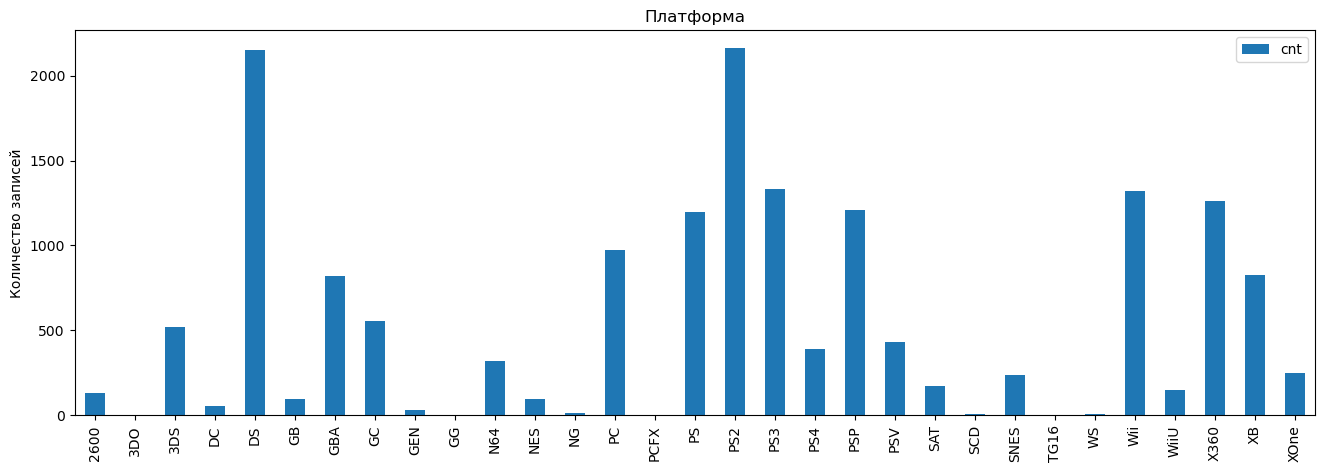


Year_of_Release - Год выпуска

Описание данных:
count   16,446.00
mean     2,006.48
std          5.88
min      1,980.00
25%      2,003.00
50%      2,007.00
75%      2,010.00
max      2,016.00
Name: Year_of_Release, dtype: float64
Количество записей: 16446 из 16715
Пропущено: 269


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


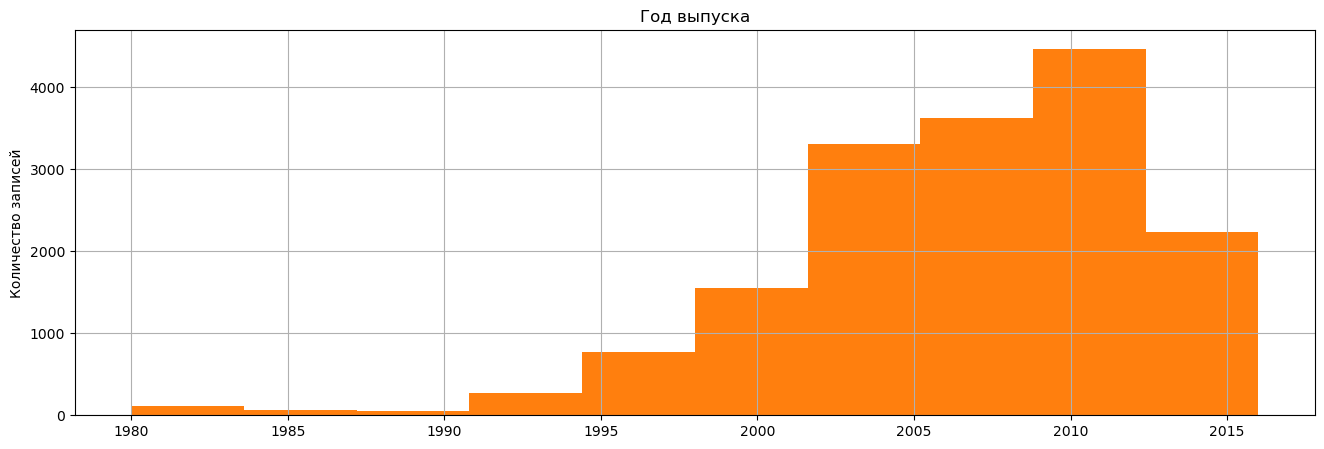


Genre - Жанр игры

Описание данных:
count      16713
unique        12
top       Action
freq        3369
Name: Genre, dtype: object
Количество записей: 16713 из 16715
Пропущено: 2


Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


Genre   cnt
0        Action  3369
1        Sports  2348
2          Misc  1750
3  Role-Playing  1498
4       Shooter  1323
5     Adventure  1303
6        Racing  1249
7      Platform   888
8    Simulation   873
9      Fighting   849


Гистограмма значений:


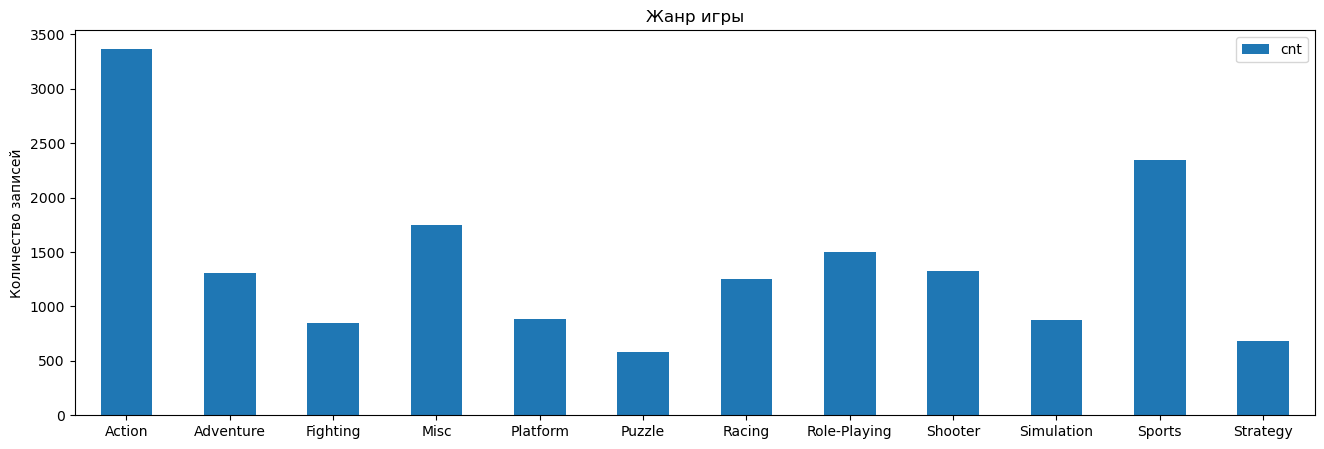


NA_sales - Продажи в Северной Америке (миллионы долларов)

Описание данных:
count   16,715.00
mean         0.26
std          0.81
min          0.00
25%          0.00
50%          0.08
75%          0.24
max         41.36
Name: NA_sales, dtype: float64
Количество записей: 16715 из 16715

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


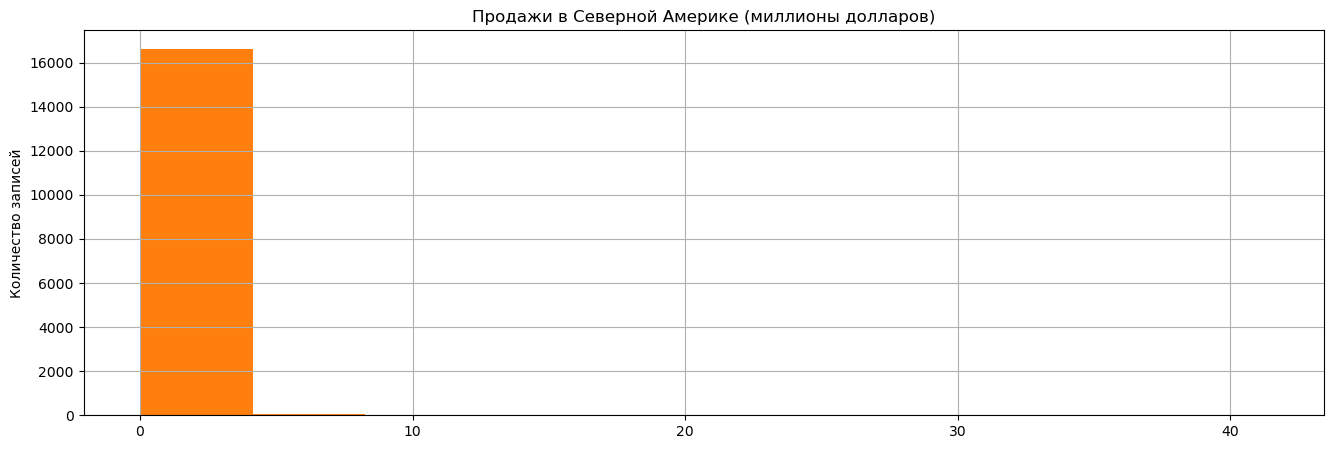


EU_sales - Продажи в Европе (миллионы долларов)

Описание данных:
count   16,715.00
mean         0.15
std          0.50
min          0.00
25%          0.00
50%          0.02
75%          0.11
max         28.96
Name: EU_sales, dtype: float64
Количество записей: 16715 из 16715

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


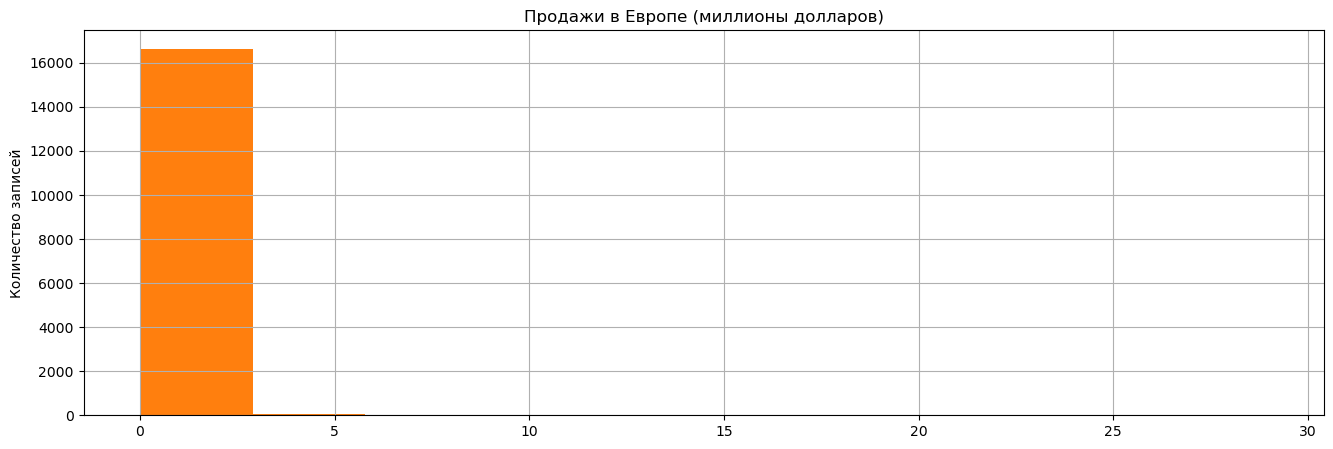


JP_sales - Продажи в Японии (миллионы долларов)

Описание данных:
count   16,715.00
mean         0.08
std          0.31
min          0.00
25%          0.00
50%          0.00
75%          0.04
max         10.22
Name: JP_sales, dtype: float64
Количество записей: 16715 из 16715

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


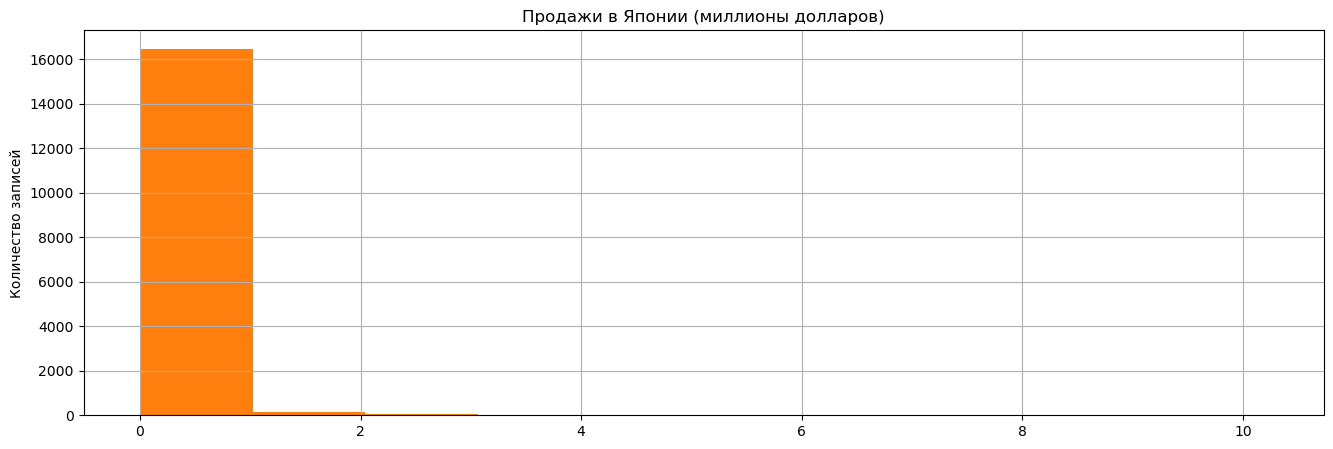


Other_sales - Продажи в других странах (миллионы долларов)

Описание данных:
count   16,715.00
mean         0.05
std          0.19
min          0.00
25%          0.00
50%          0.01
75%          0.03
max         10.57
Name: Other_sales, dtype: float64
Количество записей: 16715 из 16715

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


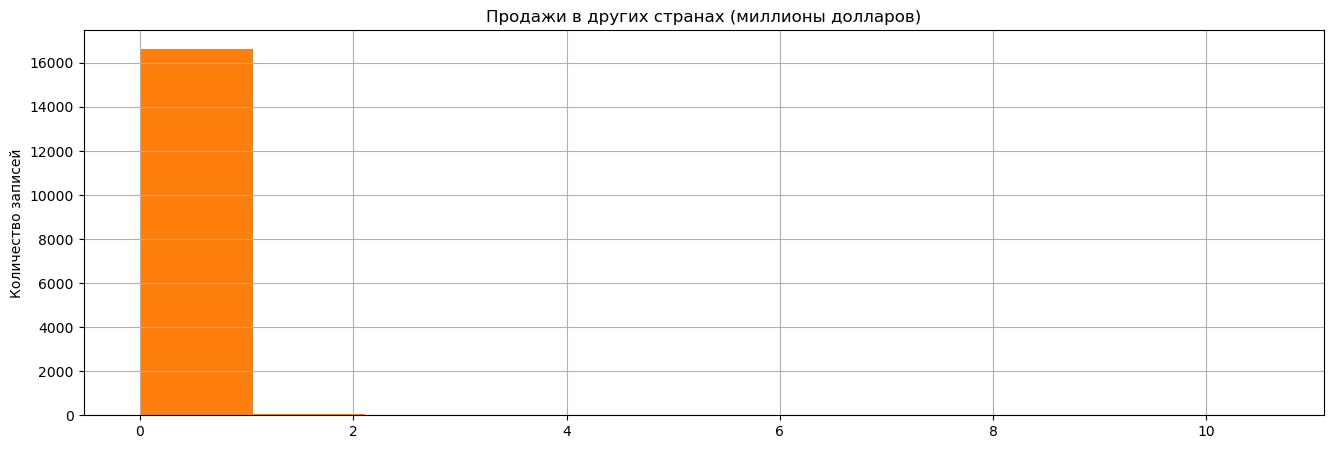


Critic_Score - Оценка критиков (максимум 100)

Описание данных:
count   8,137.00
mean       68.97
std        13.94
min        13.00
25%        60.00
50%        71.00
75%        79.00
max        98.00
Name: Critic_Score, dtype: float64
Количество записей: 8137 из 16715
Пропущено: 8578


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


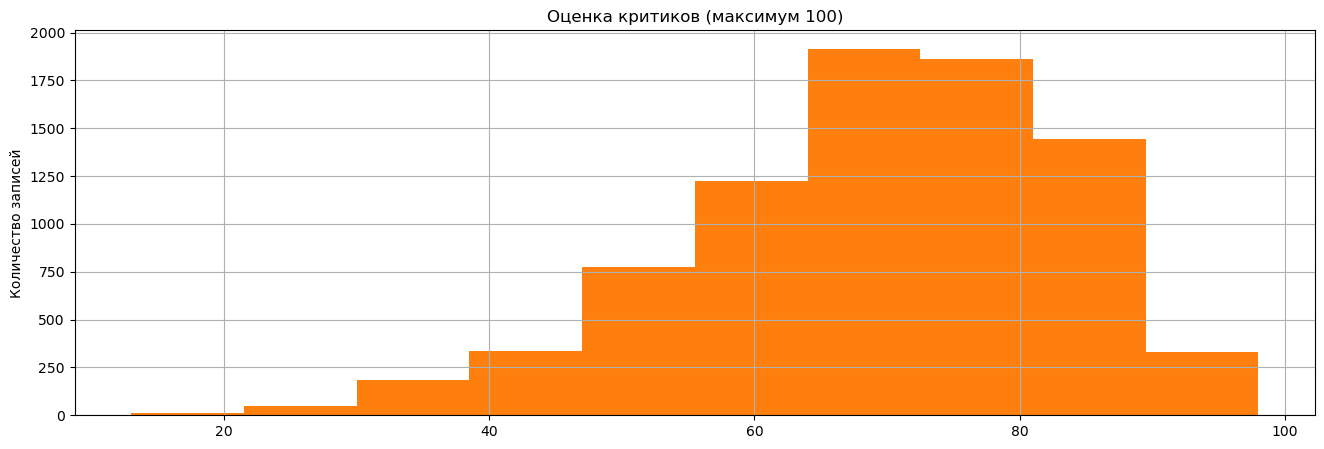


User_Score - Оценка пользователей (максимум 10)

Описание данных:
count     10014
unique       96
top         tbd
freq       2424
Name: User_Score, dtype: object
Количество записей: 10014 из 16715
Пропущено: 6701


Тип:
 <class 'str'>

Rating - Рейтинг от организации ESRB

Описание данных:
count     9949
unique       8
top          E
freq      3990
Name: Rating, dtype: object
Количество записей: 9949 из 16715
Пропущено: 6766


Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


Rating   cnt
0      E  3990
1      T  2961
2      M  1563
3   E10+  1420
4     EC     8
5    K-A     3
6     RP     3
7     AO     1


Гистограмма значений:


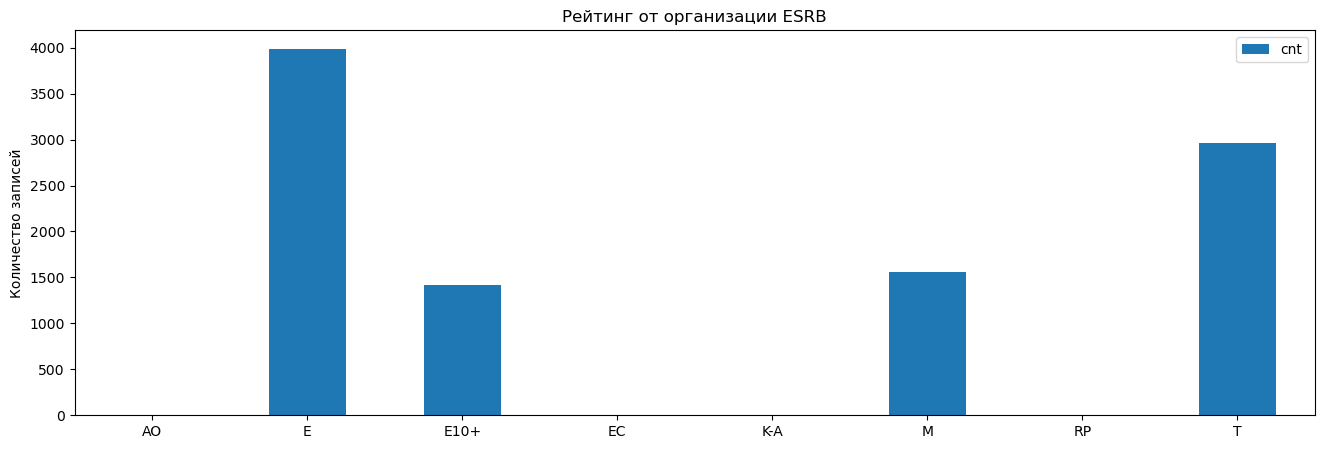

In [11]:
df_reaper(data, data_name, data_fields)

### Дополнительные данные:

**Загрузка данных о игровых платформах: дата выпуска, дата прекращения поддержки:**

In [12]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/5Az8vCLSsIbAxw' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
platforms_live = pd.read_csv(download_url) 

In [13]:
platforms_live

platform  year   end
0       Wii  2006  2013
1       NES  1983  2003
2        GB  1989  2003
3        DS  2004  2013
4      X360  2005  2016
5       PS3  2006  2017
6       PS2  2000  2013
7      SNES  1990  2005
8       GBA  2001  2008
9       PS4  2013  2023
10      3DS  2011  2020
11      N64  1996  2002
12       PS  1994  2006
13       XB  2001  2009
14       PC  1978  2023
15     2600  1977  1991
16      PSP  2004  2014
17     XOne  2013  2020
18     WiiU  2012  2017
19       GC  2001  2007
20      GEN  1990  1994
21       DC  1998  2001
22      PSV  2011  2019
23      SAT  1994  2000
24      SCD  1992  1996
25       WS  1999  2001
26       NG  1990  1997
27     TG16  1986  1995
28      3DO  1993  1996
29       GG  1992  1992
30     PCFX  1994  1996

### Общий вывод анализа входной информации

1. В предоставленных данных находится информация о 16715 компьютерных играх, выпущенных с 1980 по 2016 годы.
2. Состояние данных - среднее, много пропущенных данных.
3. Часть данных требует предобработки

## **Подготовка данных**

### Приведение названий столбцов к нижнему регистру

#### Подготовка новых названий столбцов

In [14]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [15]:
old_columns = list(data.columns)

In [16]:
new_columns = []
for col in data.columns:
    new_columns.append(col.lower())

#### Обновление столбцов в датафрейме

In [17]:
data.columns = new_columns

In [18]:
data.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii         2,006.00        Sports     41.36   
1         Super Mario Bros.      NES         1,985.00      Platform     29.08   
2            Mario Kart Wii      Wii         2,008.00        Racing     15.68   
3         Wii Sports Resort      Wii         2,009.00        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB         1,996.00  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  
0     28.96      3.77         8.45         76.00          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29         82.00        8.3      E  
3     10.93      3.28         2.95         80.00          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

#### Обновление ключей в словаре с описанием столбцов:

In [19]:
for field in data_fields:
    if field in old_columns:
        i = old_columns.index(field)
        data_fields[new_columns[i]] = data_fields.pop(old_columns[i])

In [20]:
data_fields

{'name': 'Название игры',
 'platform': 'Платформа',
 'year_of_release': 'Год выпуска',
 'genre': 'Жанр игры',
 'na_sales': 'Продажи в Северной Америке (миллионы долларов)',
 'eu_sales': 'Продажи в Европе (миллионы долларов)',
 'jp_sales': 'Продажи в Японии (миллионы долларов)',
 'other_sales': 'Продажи в других странах (миллионы долларов)',
 'critic_score': 'Оценка критиков (максимум 100)',
 'user_score': 'Оценка пользователей (максимум 10)',
 'rating': 'Рейтинг от организации ESRB'}

### Обработка пропусков и дубликатов

#### Вспомогательная функция

Функция **friendly_filler** ищет в датафрейме **df** строки с пропущенными значениями столбца **target**, <br />
для которых в **df** есть строки с таким же значением столбца **base** c непустыми значениями,<br />
и заполняет их в зависимости от значения параметра **agg**:
- *'none'* (по умолчанию) - первым непустым значением;
- *'median'* - медианным значением;
- *'mean'* - средним значением.

In [21]:
def friendly_filler(df,base,target,agg='none'):
    
    target_no = df.query(target+'.isna()')[base].unique()
    target_yes = df.query(target+'.notna()')[base].unique()
    target_yes_no = pd.Series(list(set(target_yes).intersection(set(target_no))))
    
    for t in target_yes_no:
        if agg =='none':
            x = list(df[(data[base] == t) & (df[target].notna())][target])[0]
        elif agg =='median':
            x = df[(data[base] == t) & (df[target].notna())][target].median()
        elif agg =='mean':
            x = df[(data[base] == t) & (df[target].notna())][target].mean()
            
        df.loc[(df[base] == t) & (df[target].isna()),target] = x
    return df  

#### **name** - Название игры

##### Анализ данных столбца

In [22]:
col_reaper(data,'name')

name - Название игры

Описание данных:
count                           16713
unique                          11559
top       Need for Speed: Most Wanted
freq                               12
Name: name, dtype: object
Количество записей: 16713 из 16715
Пропущено: 2


Тип:
 <class 'str'>



##### Удаление битых данных

Игры без названий:

In [23]:
data.query('name.isna()')

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN         1,993.00   NaN      1.78      0.53      0.00   
14244  NaN      GEN         1,993.00   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

К сожалению, информацию об играх без названия обработать не удастся - придется их удалить:

In [24]:
data = data.dropna(subset=['name'])

##### Поиск дубликатов

Количество неуникальных значений очень велико:

In [25]:
len(data['name']) - len(data['name'].unique())

5154

Возможно одна и та же игра для разных платформ считается разной игрой. Найдем дубликаты имен и платформ:

In [26]:
data[data.duplicated(subset=['name','platform'], keep=False)].sort_values(by='name')

name platform  year_of_release     genre  \
604                  Madden NFL 13      PS3         2,012.00    Sports   
16230                Madden NFL 13      PS3         2,012.00    Sports   
1190   Need for Speed: Most Wanted     X360         2,012.00    Racing   
1591   Need for Speed: Most Wanted     X360         2,005.00    Racing   
5972   Need for Speed: Most Wanted       PC         2,005.00    Racing   
11715  Need for Speed: Most Wanted       PC         2,012.00    Racing   
1745            Sonic the Hedgehog      PS3         2,006.00  Platform   
4127            Sonic the Hedgehog      PS3              NaN  Platform   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
604        2.11      0.22      0.00         0.23         83.00        5.5   
16230      0.00      0.01      0.00         0.00         83.00        5.5   
1190       0.62      0.78      0.01         0.15         83.00        8.5   
1591       1.00      0.13      0.02         0.10         83.00        8.5   
5972       0.02      0.23      0.00         0.04         82.00        8.5   
11715      0.00      0.06      0.00         0.02         82.00        8.5   
1745       0.41      0.06      0.04         0.66         43.00        4.1   
4127       0.00      0.48      0.00         0.00         43.00        4.1   

      rating  
604        E  
16230      E  
1190       T  
1591       T  
5972       T  
11715      T  
1745    E10+  
4127    E10+

Need for Speed: Most Wanted на самом деле выходила дважды: в 2005 и 2012 годах.
У Madden NFL 13 и Sonic the Hedgehog - скорее всего, правильная информация - в строке с ненулевыми na_sales и jp_sales.<br />
Неправильные строки стоит тоже удалить

In [27]:
del_index = []
del_index.append(data[(data['name']=='Madden NFL 13') &  (data['platform']=='PS3') & (data['na_sales']==0.0)].index[0])
del_index.append(data[(data['name']=='Sonic the Hedgehog') &  (data['platform']=='PS3') & (data['na_sales']==0.0)].index[0])
#del_index
data = data.drop(index=del_index)

Проверим результат:

In [28]:
data[data.duplicated(subset=['name','platform'], keep=False)].sort_values(by='name')

name platform  year_of_release   genre  \
1190   Need for Speed: Most Wanted     X360         2,012.00  Racing   
1591   Need for Speed: Most Wanted     X360         2,005.00  Racing   
5972   Need for Speed: Most Wanted       PC         2,005.00  Racing   
11715  Need for Speed: Most Wanted       PC         2,012.00  Racing   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
1190       0.62      0.78      0.01         0.15         83.00        8.5   
1591       1.00      0.13      0.02         0.10         83.00        8.5   
5972       0.02      0.23      0.00         0.04         82.00        8.5   
11715      0.00      0.06      0.00         0.02         82.00        8.5   

      rating  
1190       T  
1591       T  
5972       T  
11715      T

Дубликаты удалены

##### Выводы и итоги

1. Удалены пустые данные
2. Удалены дубликаты
3. Данные в столбце подготовлены к анализу

 ####  **platform** - Платформа

##### Анализ данных столбца

platform - Платформа

Описание данных:
count     16711
unique       31
top         PS2
freq       2161
Name: platform, dtype: object
Количество записей: 16711 из 16711

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


platform   cnt
0      PS2  2161
1       DS  2151
2      PS3  1329
3      Wii  1320
4     X360  1262
5      PSP  1209
6       PS  1197
7       PC   974
8       XB   824
9      GBA   822


Гистограмма значений:


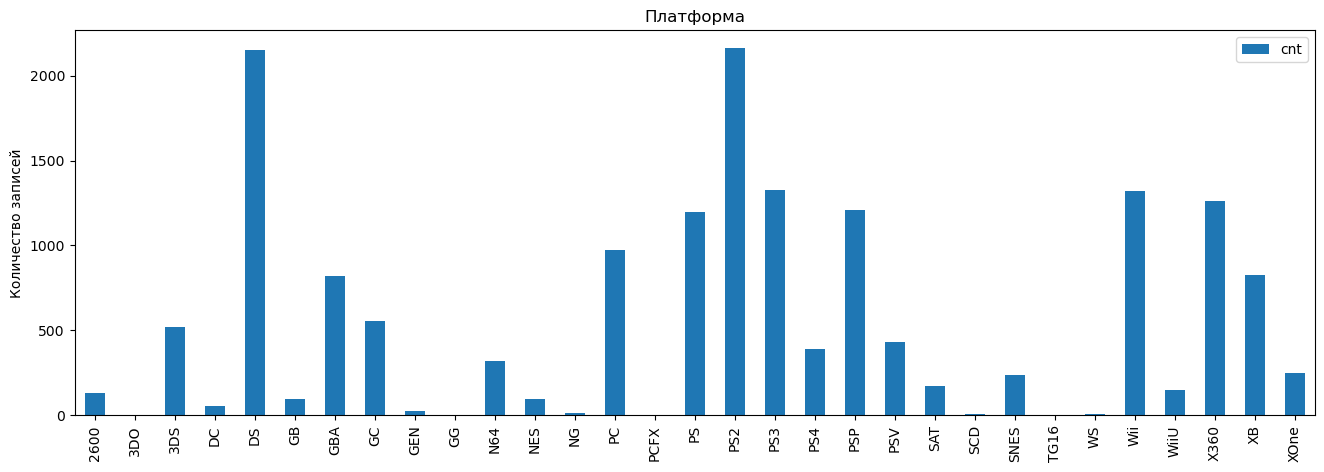

In [29]:
col_reaper(data,'platform')

Данные полны и не требуют обработки

##### Создадим список платформ для дальнейшей обработки:

In [30]:
platforms = data['platform'].unique()
platforms

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

##### Выводы и итоги

1. Данные полны и не требуют обработки
2. Данные в столбце подготовлены к анализу

#### **year_of_release** - Год выпуска

##### Анализ данных столбца

year_of_release - Год выпуска

Описание данных:
count   16,443.00
mean     2,006.49
std          5.88
min      1,980.00
25%      2,003.00
50%      2,007.00
75%      2,010.00
max      2,016.00
Name: year_of_release, dtype: float64
Количество записей: 16443 из 16711
Пропущено: 268


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


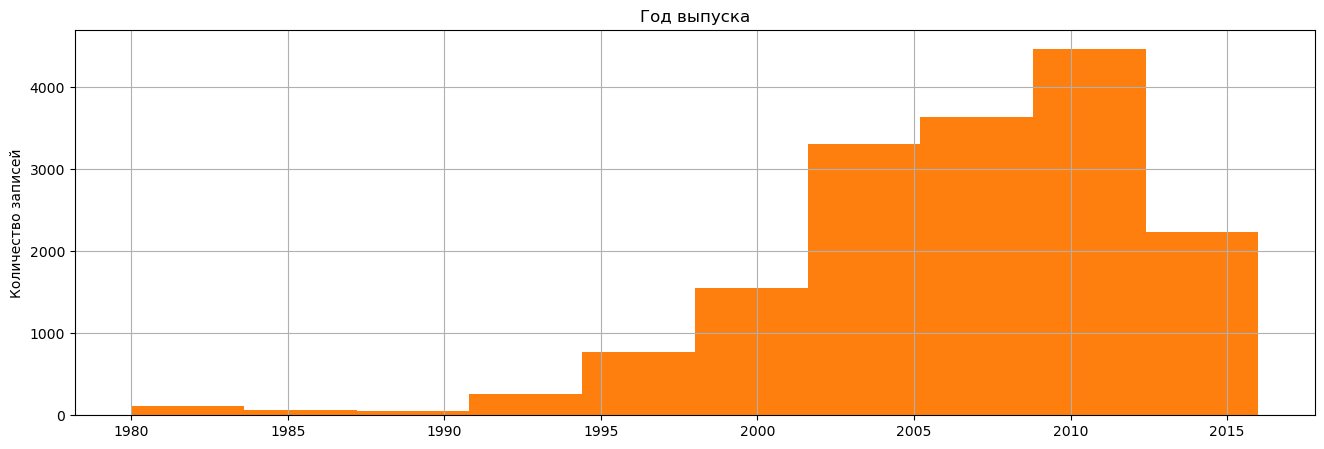

In [31]:
col_reaper(data,'year_of_release')

Анализ пропушенных значений:

In [32]:
len(data[data['year_of_release'].isna()])

268

##### Заполнение пропущенных данных значениями с других платформ

Найдем эти игры на других платформах и заполним медианными значениями годов выпуска пропущенные данные:

In [33]:
data = friendly_filler(data,'name','year_of_release','median')

Осталось пропущенных значений:

In [34]:
len(data[data['year_of_release'].isna()])

146

Из них уникальных:

In [35]:
game_year_no = data[data['year_of_release'].isna()]['name'].unique()
len(game_year_no)

133

Осталось незаполненными:

In [36]:
len(data[data['year_of_release'].isna()])

146

##### Заполнение пропущенных данных медианными значениями для каждой из платформ

У оставшихся игр определение года выпуска затруднено. <br />
Заполним пустые данные медианными значениями для типа каждого типа приставок. <br />

In [37]:
def median_year(row):
    global data
    plat = row['platform']
    row['median'] = data.query('platform == @plat')['year_of_release'].median()
    if row['median'] < row['year'] or row['median'] > row['end']:
        print(row['platform'],' - за пределами интервала!')
    return row

In [38]:
platforms_live = platforms_live.apply(median_year, axis =1)
platforms_live['median'] = platforms_live['median'].astype('int64')

In [39]:
platforms_live.head()

platform  year   end  median
0      Wii  2006  2013    2009
1      NES  1983  2003    1986
2       GB  1989  2003    1997
3       DS  2004  2013    2008
4     X360  2005  2016    2010

Добавим эти данные к таблице:

In [40]:
platforms_live.columns = ['platform','plat_begin','plat_end', 'plat_median']

In [41]:
platforms_live.head()

platform  plat_begin  plat_end  plat_median
0      Wii        2006      2013         2009
1      NES        1983      2003         1986
2       GB        1989      2003         1997
3       DS        2004      2013         2008
4     X360        2005      2016         2010

In [42]:
data = pd.merge(data,platforms_live)

In [43]:
data.head()

name platform  year_of_release     genre  na_sales  \
0                 Wii Sports      Wii         2,006.00    Sports     41.36   
1             Mario Kart Wii      Wii         2,008.00    Racing     15.68   
2          Wii Sports Resort      Wii         2,009.00    Sports     15.61   
3                   Wii Play      Wii         2,006.00      Misc     13.96   
4  New Super Mario Bros. Wii      Wii         2,009.00  Platform     14.44   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  \
0     28.96      3.77         8.45         76.00          8      E   
1     12.76      3.79         3.29         82.00        8.3      E   
2     10.93      3.28         2.95         80.00          8      E   
3      9.18      2.93         2.84         58.00        6.6      E   
4      6.94      4.70         2.24         87.00        8.4      E   

   plat_begin  plat_end  plat_median  
0        2006      2013         2009  
1        2006      2013         2009  
2        2006      2013         2009  
3        2006      2013         2009  
4        2006      2013         2009

Добавим данные в информацию о столбцах:

In [44]:
data_fields['plat_begin'] = 'Год выпуска платформы'
data_fields['plat_end'] = 'Год окончания поддержки платформы'
data_fields['plat_median'] = 'Медианное значение года выпуска игр для платформы'

In [45]:
data_fields

{'name': 'Название игры',
 'platform': 'Платформа',
 'year_of_release': 'Год выпуска',
 'genre': 'Жанр игры',
 'na_sales': 'Продажи в Северной Америке (миллионы долларов)',
 'eu_sales': 'Продажи в Европе (миллионы долларов)',
 'jp_sales': 'Продажи в Японии (миллионы долларов)',
 'other_sales': 'Продажи в других странах (миллионы долларов)',
 'critic_score': 'Оценка критиков (максимум 100)',
 'user_score': 'Оценка пользователей (максимум 10)',
 'rating': 'Рейтинг от организации ESRB',
 'plat_begin': 'Год выпуска платформы',
 'plat_end': 'Год окончания поддержки платформы',
 'plat_median': 'Медианное значение года выпуска игр для платформы'}

Заполнение пропущенных данных:

In [46]:
data.loc[data['year_of_release'].isna(),'year_of_release'] = data.loc[data['year_of_release'].isna(),'plat_median']

In [47]:
len(data[data['year_of_release'].isna()])

0

Пропуски заполнены

##### Проверка того, что год выпуска игр попадает в жизненный цикл приставки

In [48]:
change_count = 0

In [49]:
def live_finder(row):
    global change_count    

    if row['year_of_release'] < row['plat_begin']:
        row['year_of_release'] = row['plat_begin']
        change_count += 1
    elif row['year_of_release'] > row['plat_end']:
        row['year_of_release'] = row['plat_end']
        change_count += 1
  
    return row

In [50]:
data = data.apply(live_finder, axis=1)

Количество замен:

In [51]:
change_count

26

##### Приведение столбца к целому типу

In [52]:
data['year_of_release'] =data['year_of_release'].astype('int64')

##### Выводы и итоги

1. Заполнены пустые данные
2. Исправлены некорректные данные
3. Данные приведены к целому типу
4. Данные в столбце подготовлены к анализу

In [53]:
data.head()

name platform  year_of_release     genre  na_sales  \
0                 Wii Sports      Wii             2006    Sports     41.36   
1             Mario Kart Wii      Wii             2008    Racing     15.68   
2          Wii Sports Resort      Wii             2009    Sports     15.61   
3                   Wii Play      Wii             2006      Misc     13.96   
4  New Super Mario Bros. Wii      Wii             2009  Platform     14.44   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  \
0     28.96      3.77         8.45         76.00          8      E   
1     12.76      3.79         3.29         82.00        8.3      E   
2     10.93      3.28         2.95         80.00          8      E   
3      9.18      2.93         2.84         58.00        6.6      E   
4      6.94      4.70         2.24         87.00        8.4      E   

   plat_begin  plat_end  plat_median  
0        2006      2013         2009  
1        2006      2013         2009  
2        2006      2013         2009  
3        2006      2013         2009  
4        2006      2013         2009

#### **genre** - Жанр игры

##### Анализ данных столбца

genre - Жанр игры

Описание данных:
count      16711
unique        12
top       Action
freq        3369
Name: genre, dtype: object
Количество записей: 16711 из 16711

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


genre   cnt
0        Action  3369
1        Sports  2347
2          Misc  1750
3  Role-Playing  1498
4       Shooter  1323
5     Adventure  1303
6        Racing  1249
7      Platform   887
8    Simulation   873
9      Fighting   849


Гистограмма значений:


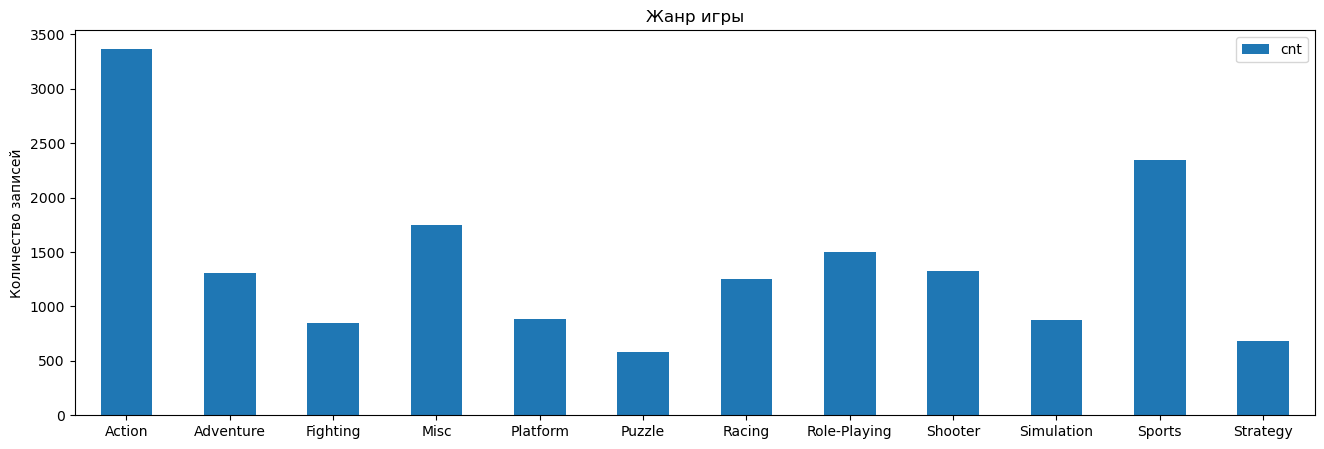

In [54]:
col_reaper(data,'genre')

##### Выводы и итоги

1. Данные полны и не требуют обработки
2. Данные в столбце подготовлены к анализу

#### **na_sales** -  Продажи в Северной Америке (миллионы долларов)

##### Анализ данных столбца

na_sales - Продажи в Северной Америке (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.26
std          0.81
min          0.00
25%          0.00
50%          0.08
75%          0.24
max         41.36
Name: na_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


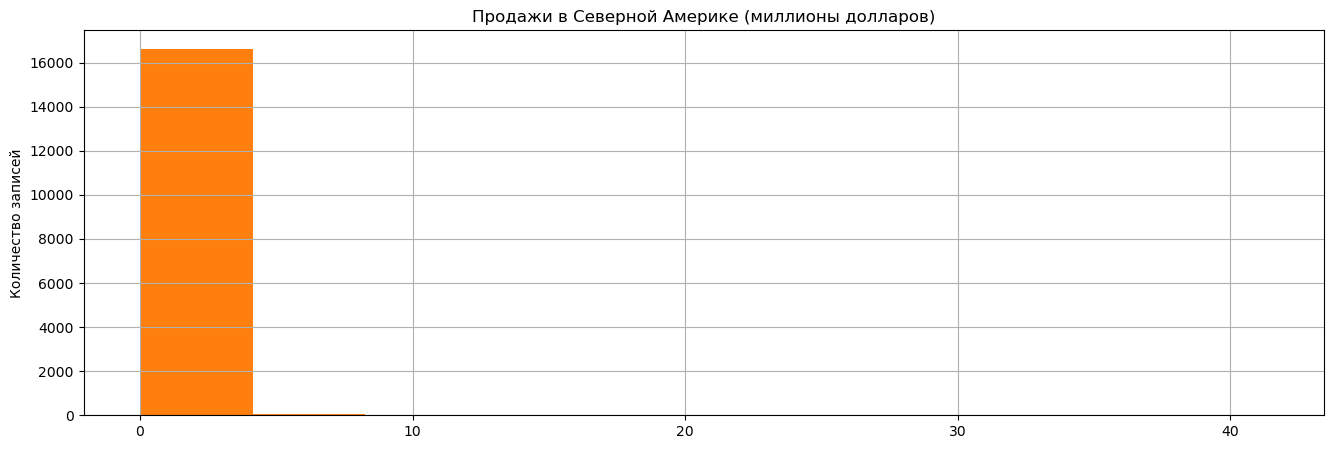

In [55]:
col_reaper(data,'na_sales')

In [56]:
len(data.query('na_sales == 0'))

4505

##### Выводы и итоги

1. Значительная часть данных имеет нулевое значение. Это может быть объяснено как неполнотой данных, так и естественными причинами:
- игра распространялась бесплатно или по подписке;
- игра не распространялась в данном регионе;
- продажи игры в данном регионе составили менее $10000.<br />
Поскольку выделить данные ситуации не представляется возможным, возможно, придется не учитывать эти данные в некоторых из аналитических расчётов
2. Данные в столбце подготовлены к анализу

#### **eu_sales** - Продажи в Европе (миллионы долларов)

##### Анализ данных столбца

eu_sales - Продажи в Европе (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.15
std          0.50
min          0.00
25%          0.00
50%          0.02
75%          0.11
max         28.96
Name: eu_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


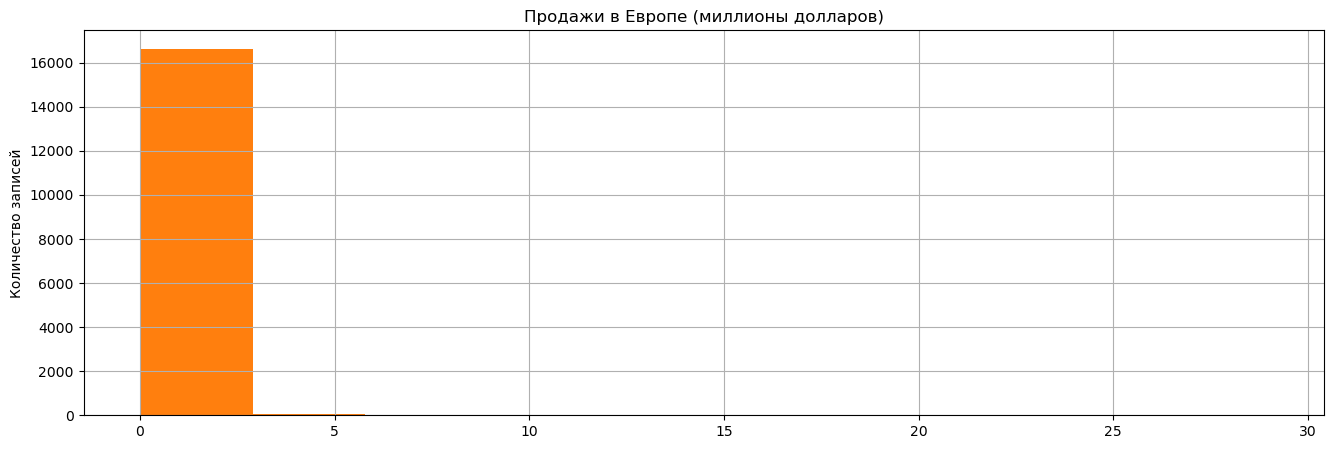

In [57]:
col_reaper(data,'eu_sales')

##### Выводы и итоги

1. Значительная часть данных имеет нулевое значение. Это может быть объяснено как неполнотой данных, так и естественными причинами:
- игра распространялась бесплатно или по подписке;
- игра не распространялась в данном регионе;
- продажи игры в данном регионе составили менее $10000.<br />
Поскольку выделить данные ситуации не представляется возможным, возможно, придется не учитывать эти данные в некоторых из аналитических расчётов
2. Данные в столбце подготовлены к анализу

#### **jp_sales** - Продажи в Японии (миллионы долларов)

##### Анализ данных столбца

jp_sales - Продажи в Японии (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.08
std          0.31
min          0.00
25%          0.00
50%          0.00
75%          0.04
max         10.22
Name: jp_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


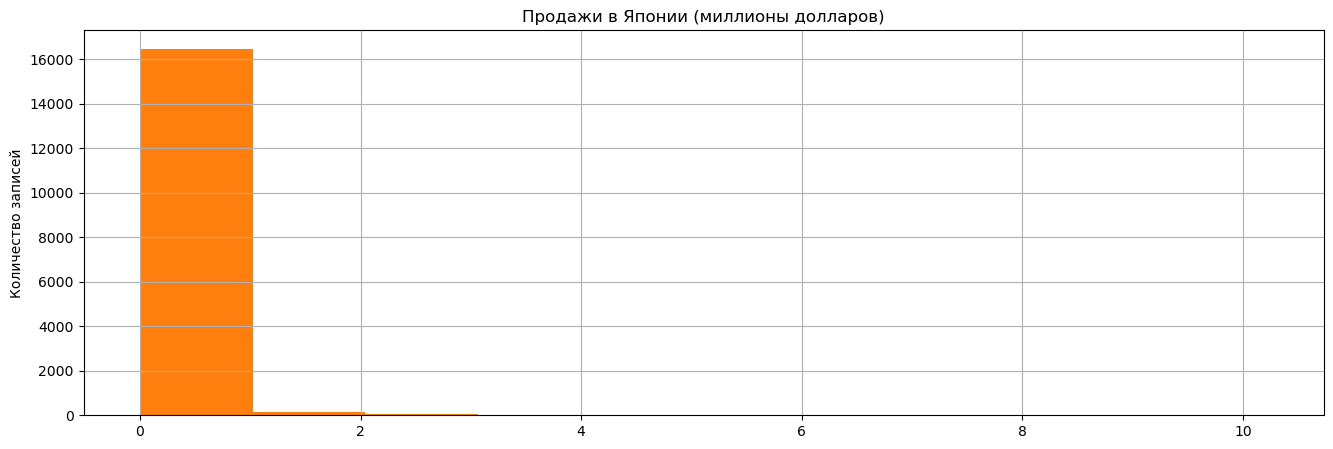

In [58]:
col_reaper(data,'jp_sales')

##### Выводы и итоги

1. Значительная часть данных имеет нулевое значение. Это может быть объяснено как неполнотой данных, так и естественными причинами:
- игра распространялась бесплатно или по подписке;
- игра не распространялась в данном регионе;
- продажи игры в данном регионе составили менее $10000.<br />
Поскольку выделить данные ситуации не представляется возможным, возможно, придется не учитывать эти данные в некоторых из аналитических расчётов
2. Данные в столбце подготовлены к анализу

#### **other_sales** - Продажи в других странах (миллионы долларов)

##### Анализ данных столбца

other_sales - Продажи в других странах (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.05
std          0.19
min          0.00
25%          0.00
50%          0.01
75%          0.03
max         10.57
Name: other_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


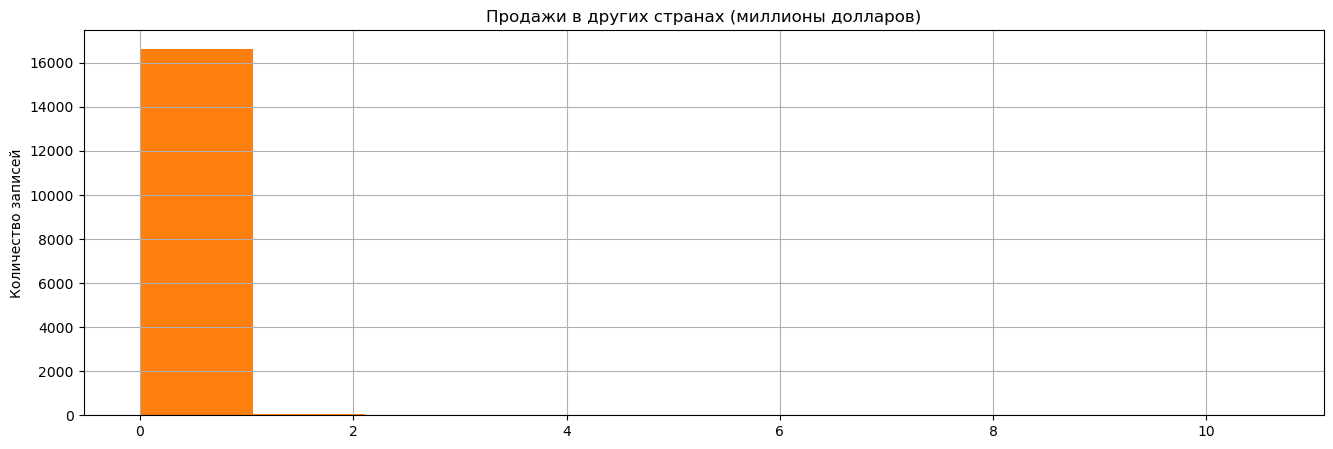

In [59]:
col_reaper(data,'other_sales')

##### Выводы и итоги

1. Значительная часть данных имеет нулевое значение. Это может быть объяснено как неполнотой данных, так и естественными причинами:
- игра распространялась бесплатно или по подписке;
- игра не распространялась в данном регионе;
- продажи игры в данном регионе составили менее $10000.<br />
Поскольку выделить данные ситуации не представляется возможным, возможно, придется не учитывать эти данные в некоторых из аналитических расчётов
2. Данные в столбце подготовлены к анализу

#### **sum_sales** - Суммарные продажи (миллионы долларов) - новый столбец

##### Обобщим данные по продажам:

In [60]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [61]:
data_fields['sum_sales'] = 'Суммарные продажи (миллионы долларов)'

##### Анализ данных полученного столбца

sum_sales - Суммарные продажи (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.53
std          1.55
min          0.00
25%          0.06
50%          0.17
75%          0.47
max         82.54
Name: sum_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


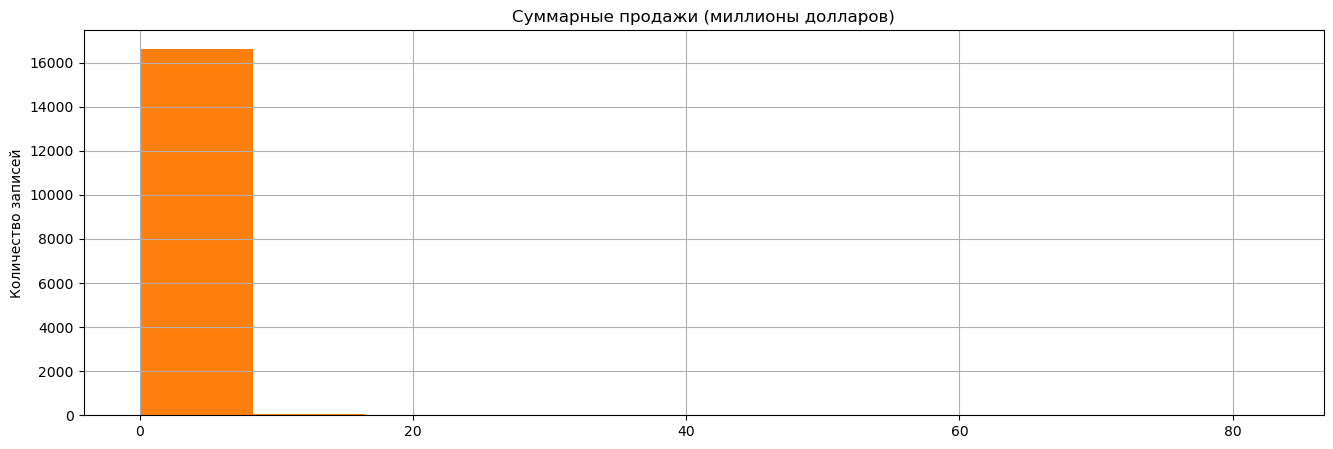

In [62]:
col_reaper(data,'sum_sales')

Игры, не принесшие денег:

In [63]:
data.query('sum_sales == 0')

name platform  \
6255                                  G1 Jockey 4 2008      PS3   
8418  SCORE International Baja 1000: The Official Game      PS2   

      year_of_release   genre  na_sales  eu_sales  jp_sales  other_sales  \
6255             2008  Sports      0.00      0.00      0.00         0.00   
8418             2008  Racing      0.00      0.00      0.00         0.00   

      critic_score user_score rating  plat_begin  plat_end  plat_median  \
6255           NaN        NaN    NaN        2006      2017         2011   
8418           NaN        NaN    NaN        2000      2013         2004   

      sum_sales  
6255       0.00  
8418       0.00

##### Выводы и итоги

1. Добавлен столбец с суммарным значением продаж
2. Удалось получить данные по почти всем столбцам
3. Данные в столбце подготовлены к анализу

#### **critic_score**  - Оценка критиков (максимум 100)

##### Анализ данных столбца

critic_score - Оценка критиков (максимум 100)

Описание данных:
count   8,135.00
mean       68.97
std        13.94
min        13.00
25%        60.00
50%        71.00
75%        79.00
max        98.00
Name: critic_score, dtype: float64
Количество записей: 8135 из 16711
Пропущено: 8576


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


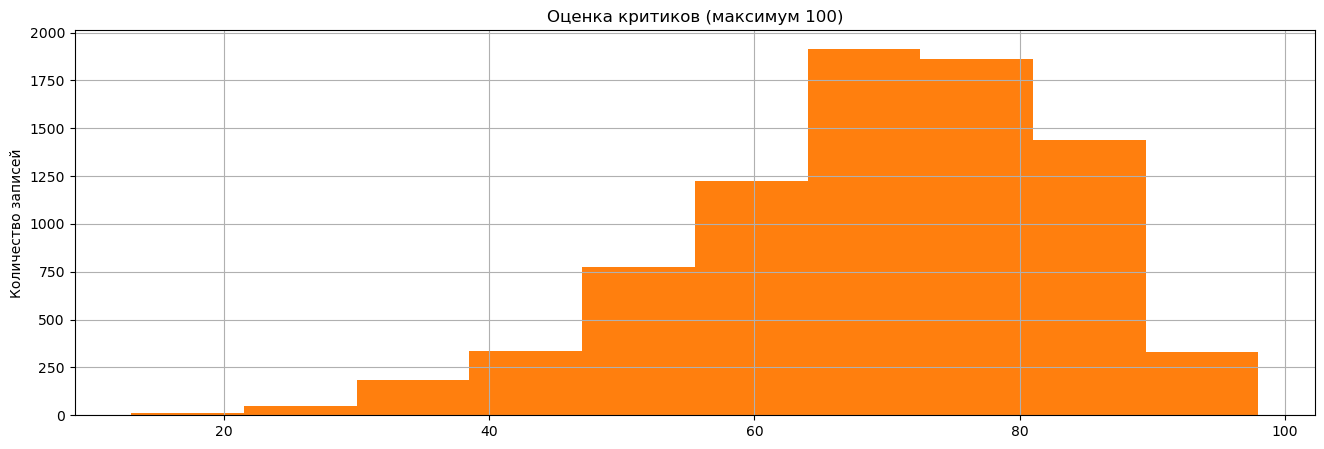

In [64]:
col_reaper(data,'critic_score')

##### Заполнение пропущенных данных значениями с других платформ

Большое количество пропущенных. Но, возможно, у этих игр есть оценки надругих платформах?

In [65]:
data = friendly_filler(data,'name','critic_score','median')

Пропущенных осталось:

In [66]:
len(data.query('critic_score.isna()'))

7615

Остальные игры, видимо, не удостоились оценки. 

##### Выводы и итоги

1. Заполнены пустые данные
2. Данные в столбце подготовлены к анализу

#### **user_score** - Оценка пользователей (максимум 10)

##### Анализ данных столбца

In [67]:
col_reaper(data,'user_score')

user_score - Оценка пользователей (максимум 10)

Описание данных:
count     10012
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object
Количество записей: 10012 из 16711
Пропущено: 6699


Тип:
 <class 'str'>



##### Требуется перевод в численные значения

In [68]:
data['user_score'].unique()

array(['8', '8.3', '6.6', '8.4', '7.7', '7.4', '8.9', '7.8', '7.3', '6.3',
       nan, '9.1', '9', 'tbd', '8.6', '7.1', '7.6', '6', '8.7', '6.9',
       '7.9', '6.2', '4.6', '6.8', '7', '5.3', '5.6', '5.4', '4.3', '5.7',
       '6.7', '5.2', '8.5', '7.2', '4.2', '8.1', '7.5', '2.5', '6.1',
       '5.8', '6.5', '5', '2', '8.2', '4.4', '8.8', '3.3', '3.6', '4.5',
       '5.9', '4.9', '1.8', '6.4', '1.6', '5.5', '9.3', '4', '3.7', '2.8',
       '1.1', '4.8', '3', '2.1', '5.1', '3.1', '3.5', '3.4', '3.8', '1.4',
       '1', '1.7', '2.7', '4.7', '4.1', '0.3', '0.7', '0.2', '0.6', '9.2',
       '1.9', '0', '2.6', '3.2', '3.9', '9.5', '2.4', '0.9', '2.2', '2.9',
       '1.3', '1.2', '0.5', '2.3', '9.4', '9.6', '1.5', '9.7'],
      dtype=object)

 TBD - To Be Determined - оценка, которую хотели поставить позже, но - забыли :( Ну, или не успели.<br />
 Заменим TBD пустыми значениями:

In [69]:
data.loc[data['user_score']=='tbd','user_score'] = np.nan

In [70]:
data['user_score'] = data['user_score'].astype('float64')

##### Коррекция данных

Оценка ставится от 1 до 10, значит 0 - это "нет оценки"

In [71]:
data.loc[data['user_score']==0.0,'user_score'] = np.nan

По той же причине рейтинги не могут быть меньше 1:

In [72]:
data[data['user_score']<1.0]

name platform  year_of_release  \
1136   Billy the Wizard: Rocket Broomstick Racing      Wii             2007   
1142                                   Pool Party      Wii             2007   
1162               Myth Makers: Trixie in Toyland      Wii             2008   
1242                             Kawasaki Jet Ski      Wii             2008   
1987                                   Happy Feet       DS             2006   
2953                                  Johnny Test       DS             2011   
4471                                Madden NFL 17     X360             2016   
5837             Power Gig: Rise of the SixString      PS3             2010   
5891                                Madden NFL 17      PS3             2016   
12403           Charlie and the Chocolate Factory       XB             2005   
14390                  Thrillville: Off the Rails      PSP             2007   
14411                      Dragon Ball: Evolution      PSP             2009   

           genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
1136      Racing      0.04      0.00      0.00         0.00           NaN   
1142      Sports      0.04      0.00      0.00         0.00         32.00   
1162    Platform      0.04      0.00      0.00         0.00           NaN   
1242      Racing      0.02      0.00      0.00         0.00           NaN   
1987      Action      0.27      0.01      0.00         0.02         46.00   
2953    Platform      0.06      0.00      0.00         0.00           NaN   
4471      Sports      0.14      0.02      0.00         0.02         82.50   
5837        Misc      0.13      0.00      0.00         0.01         36.00   
5891      Sports      0.07      0.02      0.00         0.02         82.50   
12403  Adventure      0.08      0.02      0.00         0.00         39.00   
14390   Strategy      0.09      0.00      0.00         0.01         72.00   
14411   Fighting      0.09      0.00      0.00         0.01         28.00   

       user_score rating  plat_begin  plat_end  plat_median  sum_sales  
1136         0.30      E        2006      2013         2009       0.04  
1142         0.70      E        2006      2013         2009       0.04  
1162         0.20      E        2006      2013         2009       0.04  
1242         0.60      E        2006      2013         2009       0.02  
1987         0.30      E        2004      2013         2008       0.30  
2953         0.90      E        2004      2013         2008       0.06  
4471         0.70      E        2005      2016         2010       0.18  
5837         0.50      T        2006      2017         2011       0.14  
5891         0.20      E        2006      2017         2011       0.11  
12403        0.50      E        2001      2009         2004       0.10  
14390        0.60   E10+        2004      2014         2009       0.10  
14411        0.90      T        2004      2014         2009       0.10

Скорее всего, эти рейтинги - в долях единицы. Надо увеличить их в 10 раз:

In [73]:
data.loc[data['user_score']<1.0,'user_score'] = data.loc[data['user_score']<1.0,'user_score']*10

##### Результат обработки данных:

user_score - Оценка пользователей (максимум 10)

Описание данных:
count   7,587.00
mean        7.13
std         1.48
min         1.00
25%         6.40
50%         7.50
75%         8.20
max         9.70
Name: user_score, dtype: float64
Количество записей: 7587 из 16711
Пропущено: 9124


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


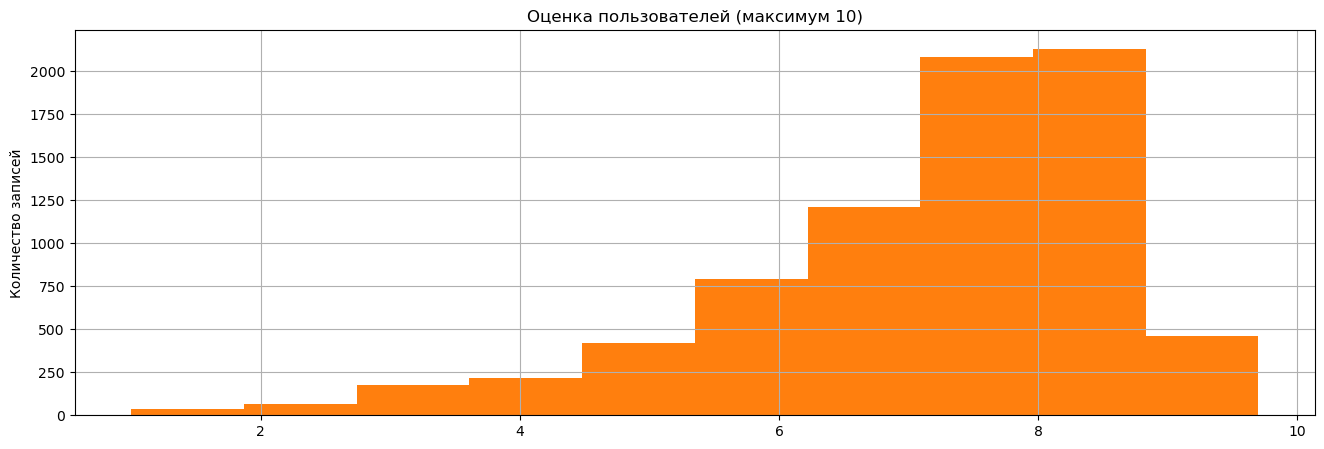

In [74]:
col_reaper(data,'user_score')

##### Выводы и итоги

1. Исправлены некорректные данные
2. Данные приведены к типу float64
3. Данные в столбце подготовлены к анализу

#### **sum_score** - Суммарная оценка - новый столбец 

##### Расчёт суммарного рейтинга:

In [75]:
data.head()

name platform  year_of_release     genre  na_sales  \
0                 Wii Sports      Wii             2006    Sports     41.36   
1             Mario Kart Wii      Wii             2008    Racing     15.68   
2          Wii Sports Resort      Wii             2009    Sports     15.61   
3                   Wii Play      Wii             2006      Misc     13.96   
4  New Super Mario Bros. Wii      Wii             2009  Platform     14.44   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45         76.00        8.00      E   
1     12.76      3.79         3.29         82.00        8.30      E   
2     10.93      3.28         2.95         80.00        8.00      E   
3      9.18      2.93         2.84         58.00        6.60      E   
4      6.94      4.70         2.24         87.00        8.40      E   

   plat_begin  plat_end  plat_median  sum_sales  
0        2006      2013         2009      82.54  
1        2006      2013         2009      35.52  
2        2006      2013         2009      32.77  
3        2006      2013         2009      28.91  
4        2006      2013         2009      28.32

Суммарный рейтинг расчитаем как среднее между оценкой критиков и пользователей

In [76]:
def rating_calc(row):
    if  not np.isnan(row['critic_score'])  and not np.isnan(row['user_score']):
        row['sum_score'] = (row['critic_score']+ row['user_score']*10)/2
    elif  not np.isnan(row['critic_score']) and np.isnan(row['user_score']):
        row['sum_score'] = row['critic_score']
    elif  np.isnan(row['critic_score']) and not np.isnan(row['user_score']):
        row['sum_score'] = row['user_score']*10
                           
    return row

In [77]:
data = data.apply(rating_calc, axis=1)

In [78]:
data_fields['sum_score'] = 'Суммарная оценка (максимум 100)'

##### Анализ результата

sum_score - Суммарная оценка (максимум 100)

Описание данных:
count   9,331.00
mean       69.25
std        13.27
min        11.00
25%        61.50
50%        71.50
75%        79.00
max        97.00
Name: sum_score, dtype: float64
Количество записей: 9331 из 16711
Пропущено: 7380


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


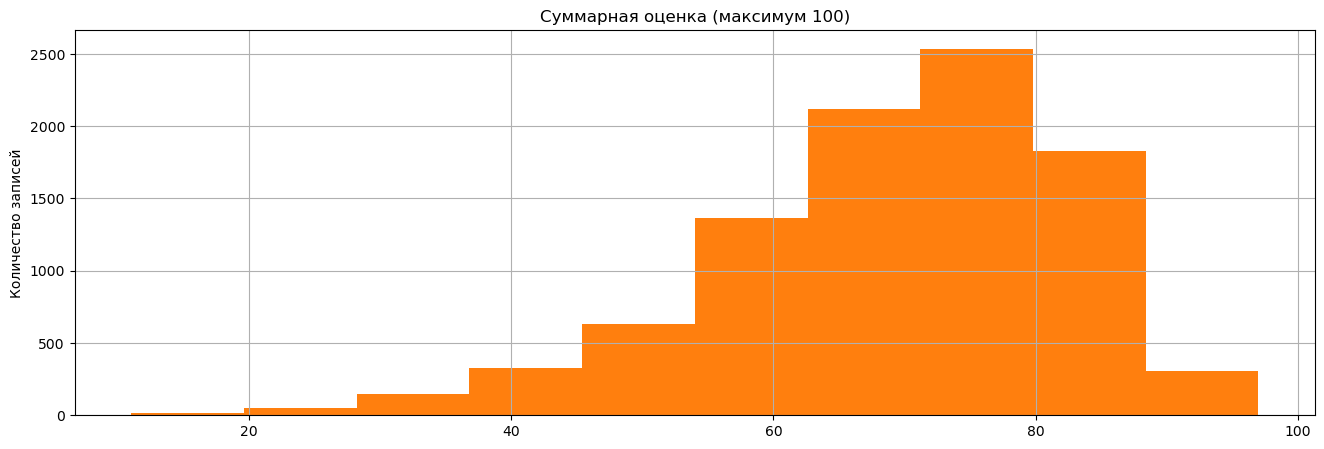

In [79]:
col_reaper(data,'sum_score')

##### Выводы и итоги

1. Добавлен столбец с суммарным рейтингом
2. Удалось уменьшить количество неоцененых игр
3. Данные в столбце подготовлены к анализу

#### **rating** - Рейтинг от организации ESRB

##### Анализ данных столбца

rating - Рейтинг от организации ESRB

Описание данных:
count     9947
unique       8
top          E
freq      3989
Name: rating, dtype: object
Количество записей: 9947 из 16711
Пропущено: 6764


Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


rating   cnt
0      E  3989
1      T  2961
2      M  1563
3   E10+  1419
4     EC     8
5    K-A     3
6     RP     3
7     AO     1


Гистограмма значений:


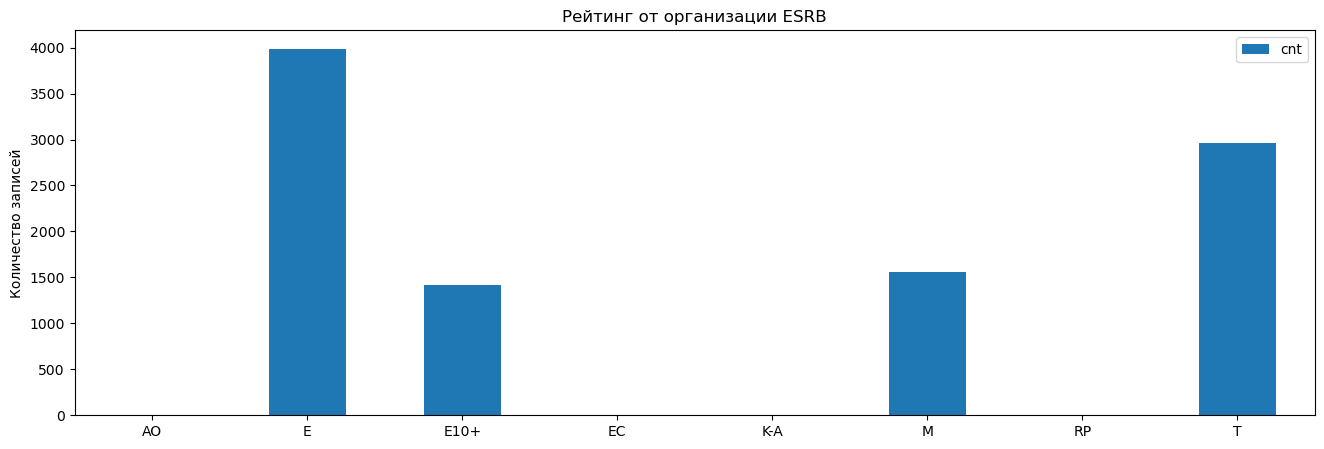

In [80]:
col_reaper(data,'rating')

**Рейтинг ESRB:**
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»
- «K-A» («Kids to Adults») — «Для детей и взрослых». В настоящее время преобразован в «E»

##### Заполнение пустых значений:

Количество пустых значений:

In [81]:
len(data.query('rating.isna()'))

6764

Заполняем пустые значения данными с других платформ:

In [82]:
data = friendly_filler(data,'name','rating')

In [83]:
len(data.query('rating.isna()'))

6327

Заменим рейтинг "К-А" рейтингом "E"

In [84]:
data.loc[data['rating'] == 'K-A','rating'] = 'E'

Сделаем рейтинг-заглушку "ND" - "No data" и заполним оставшиеся пропущенные данные этим рейтингом

In [85]:
data.loc[(data['rating'].isna()),'rating'] = 'ND'

In [86]:
len(data.query('rating.isna()'))

0

Все данные заполнены

### Результат подготовки данных

Исторические данные об играх 

Количество записей:


16711


Первые 5 строк данных:


critic_score  eu_sales     genre  jp_sales  na_sales  \
0         76.00     28.96    Sports      3.77     41.36   
1         82.00     12.76    Racing      3.79     15.68   
2         80.00     10.93    Sports      3.28     15.61   
3         58.00      9.18      Misc      2.93     13.96   
4         87.00      6.94  Platform      4.70     14.44   

                        name  other_sales  plat_begin  plat_end  plat_median  \
0                 Wii Sports         8.45        2006      2013         2009   
1             Mario Kart Wii         3.29        2006      2013         2009   
2          Wii Sports Resort         2.95        2006      2013         2009   
3                   Wii Play         2.84        2006      2013         2009   
4  New Super Mario Bros. Wii         2.24        2006      2013         2009   

  platform rating  sum_sales  sum_score  user_score  year_of_release  
0      Wii      E      82.54      78.00        8.00             2006  
1      Wii      E      35.52      82.50        8.30             2008  
2      Wii      E      32.77      80.00        8.00             2009  
3      Wii      E      28.91      62.00        6.60             2006  
4      Wii      E      28.32      85.50        8.40             2009


Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16710
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   critic_score     9096 non-null   float64
 1   eu_sales         16711 non-null  float64
 2   genre            16711 non-null  object 
 3   jp_sales         16711 non-null  float64
 4   na_sales         16711 non-null  float64
 5   name             16711 non-null  object 
 6   other_sales      16711 non-null  float64
 7   plat_begin       16711 non-null  int64  
 8   plat_end         16711 non-null  int64  
 9   plat_median      16711 non-null  int64  
 10  platform         16711 non-null  object 
 11  rating           16711 non-null  object 
 12  sum_sales        16711 non-null  float64
 13  sum_score        9331 non-null   float64
 14  user_score       7587 non-null   float64
 15  year_of_release  16711 non-null  int64  
dtypes: float64(8), int64(4), object

None

Описание данных в столбцах с числовыми значениями:


column     count     mean   std      min      25%      50%  \
0      critic_score  9,096.00    68.79 14.12    13.00    60.00    71.00   
1          eu_sales 16,711.00     0.15  0.50     0.00     0.00     0.02   
2          jp_sales 16,711.00     0.08  0.31     0.00     0.00     0.00   
3          na_sales 16,711.00     0.26  0.81     0.00     0.00     0.08   
4       other_sales 16,711.00     0.05  0.19     0.00     0.00     0.01   
5        plat_begin 16,711.00 2,001.12  8.01 1,977.00 2,000.00 2,004.00   
6          plat_end 16,711.00 2,012.95  5.63 1,991.00 2,009.00 2,013.00   
7       plat_median 16,711.00 2,006.47  5.53 1,982.00 2,004.00 2,008.00   
8         sum_sales 16,711.00     0.53  1.55     0.00     0.06     0.17   
9         sum_score  9,331.00    69.25 13.27    11.00    61.50    71.50   
10       user_score  7,587.00     7.13  1.48     1.00     6.40     7.50   
11  year_of_release 16,711.00 2,006.47  5.89 1,980.00 2,003.00 2,007.00   

        75%      max  
0     79.00    98.00  
1      0.11    28.96  
2      0.04    10.22  
3      0.24    41.36  
4      0.03    10.57  
5  2,006.00 2,013.00  
6  2,016.00 2,023.00  
7  2,010.00 2,015.00  
8      0.47    82.54  
9     79.00    97.00  
10     8.20     9.70  
11 2,010.00 2,016.00

Столбцы: 

critic_score - Оценка критиков (максимум 100)

Описание данных:
count   9,096.00
mean       68.79
std        14.12
min        13.00
25%        60.00
50%        71.00
75%        79.00
max        98.00
Name: critic_score, dtype: float64
Количество записей: 9096 из 16711
Пропущено: 7615


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


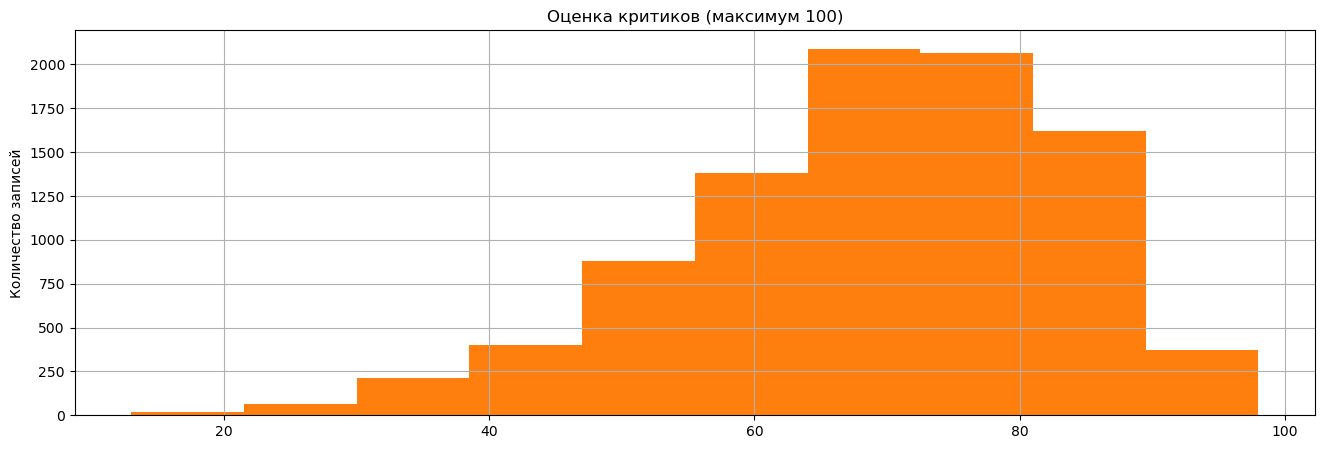


eu_sales - Продажи в Европе (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.15
std          0.50
min          0.00
25%          0.00
50%          0.02
75%          0.11
max         28.96
Name: eu_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


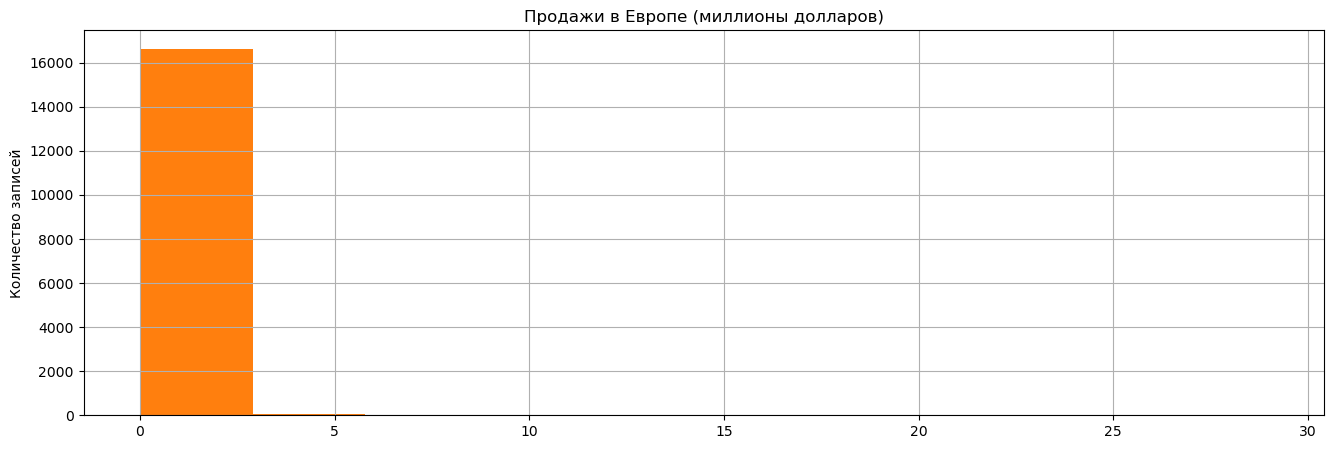


genre - Жанр игры

Описание данных:
count      16711
unique        12
top       Action
freq        3369
Name: genre, dtype: object
Количество записей: 16711 из 16711

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


genre   cnt
0        Action  3369
1        Sports  2347
2          Misc  1750
3  Role-Playing  1498
4       Shooter  1323
5     Adventure  1303
6        Racing  1249
7      Platform   887
8    Simulation   873
9      Fighting   849


Гистограмма значений:


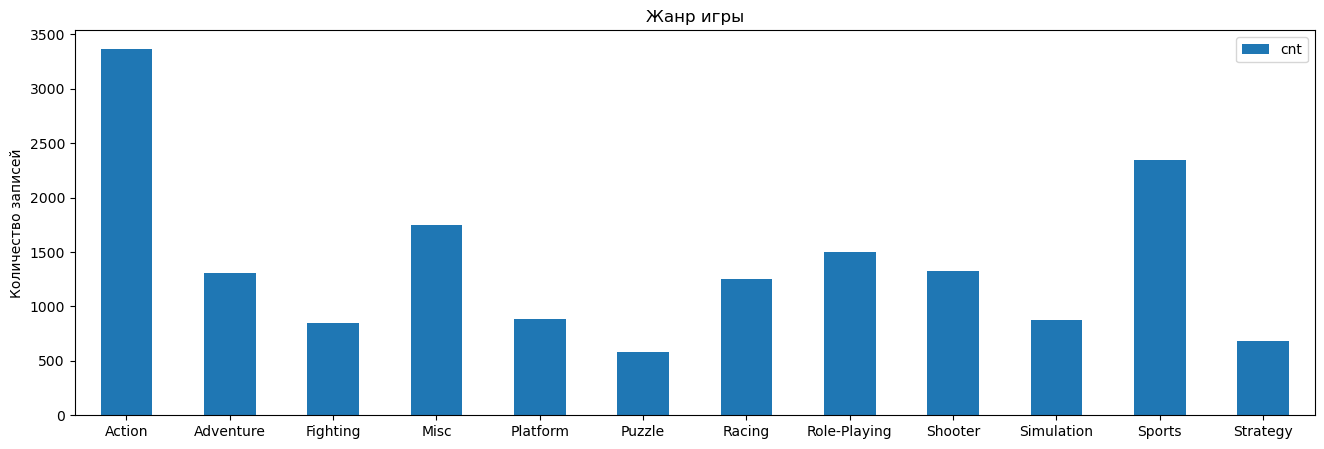


jp_sales - Продажи в Японии (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.08
std          0.31
min          0.00
25%          0.00
50%          0.00
75%          0.04
max         10.22
Name: jp_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


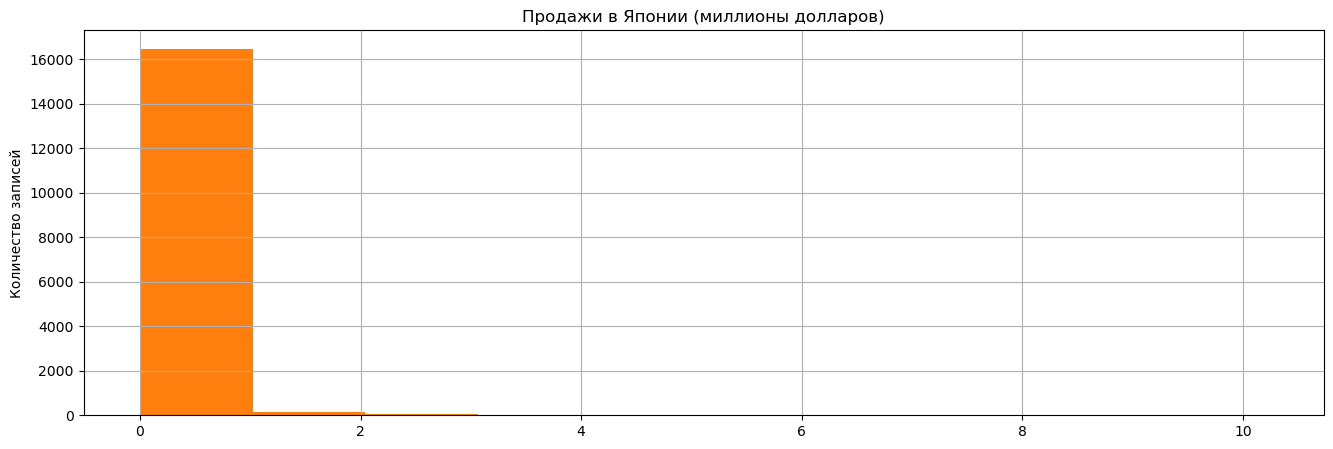


na_sales - Продажи в Северной Америке (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.26
std          0.81
min          0.00
25%          0.00
50%          0.08
75%          0.24
max         41.36
Name: na_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


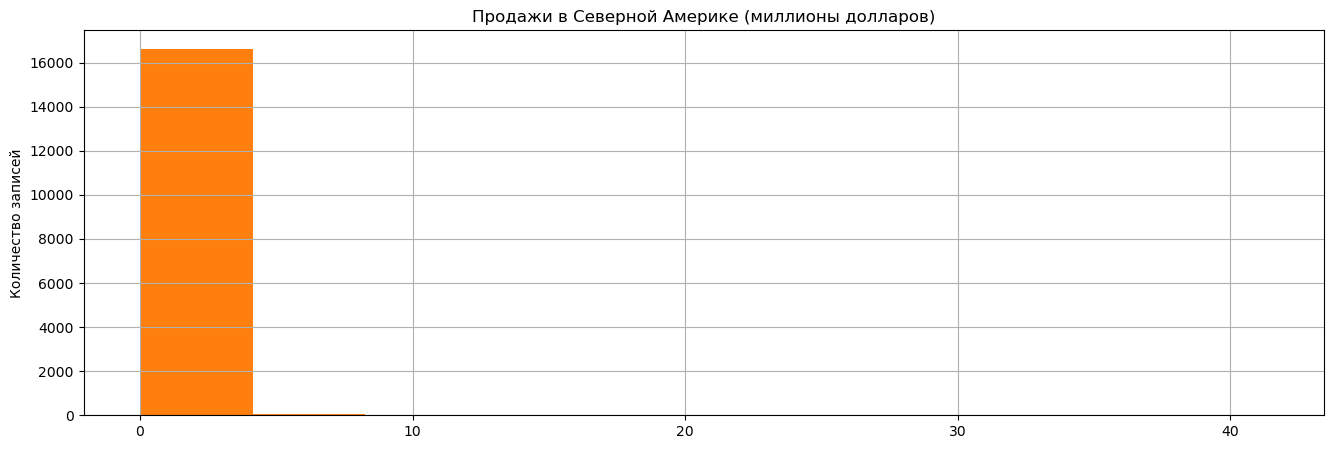


name - Название игры

Описание данных:
count                           16711
unique                          11559
top       Need for Speed: Most Wanted
freq                               12
Name: name, dtype: object
Количество записей: 16711 из 16711

Тип:
 <class 'str'>

other_sales - Продажи в других странах (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.05
std          0.19
min          0.00
25%          0.00
50%          0.01
75%          0.03
max         10.57
Name: other_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


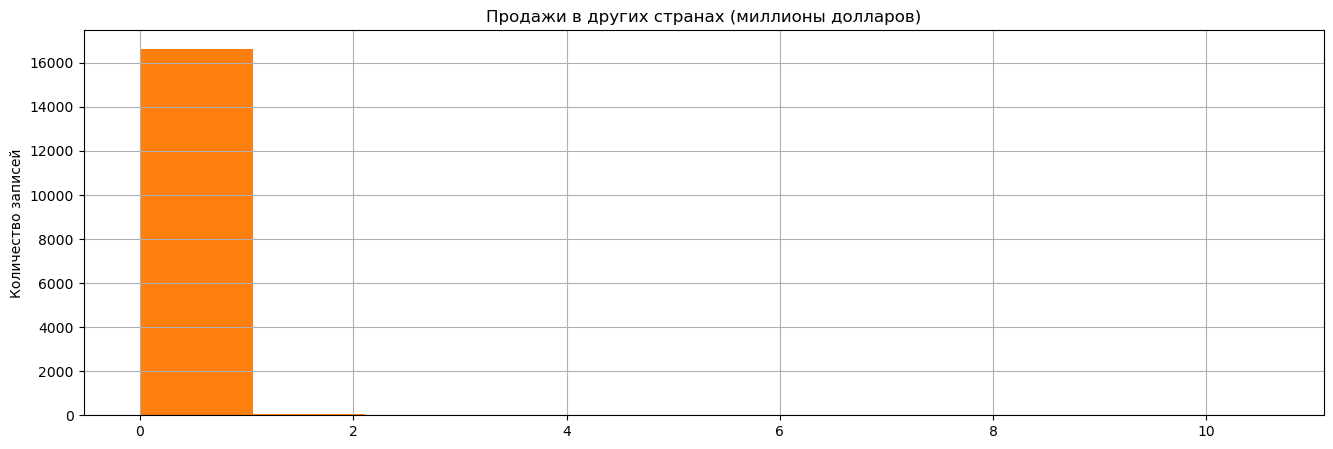


plat_begin - Год выпуска платформы

Описание данных:
count   16,711.00
mean     2,001.12
std          8.01
min      1,977.00
25%      2,000.00
50%      2,004.00
75%      2,006.00
max      2,013.00
Name: plat_begin, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


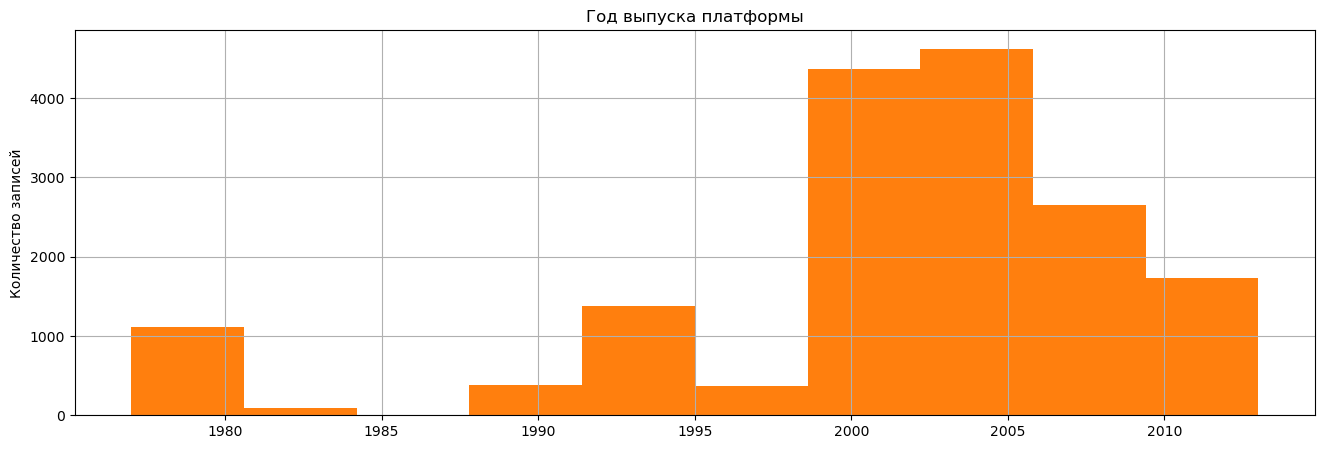


plat_end - Год окончания поддержки платформы

Описание данных:
count   16,711.00
mean     2,012.95
std          5.63
min      1,991.00
25%      2,009.00
50%      2,013.00
75%      2,016.00
max      2,023.00
Name: plat_end, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


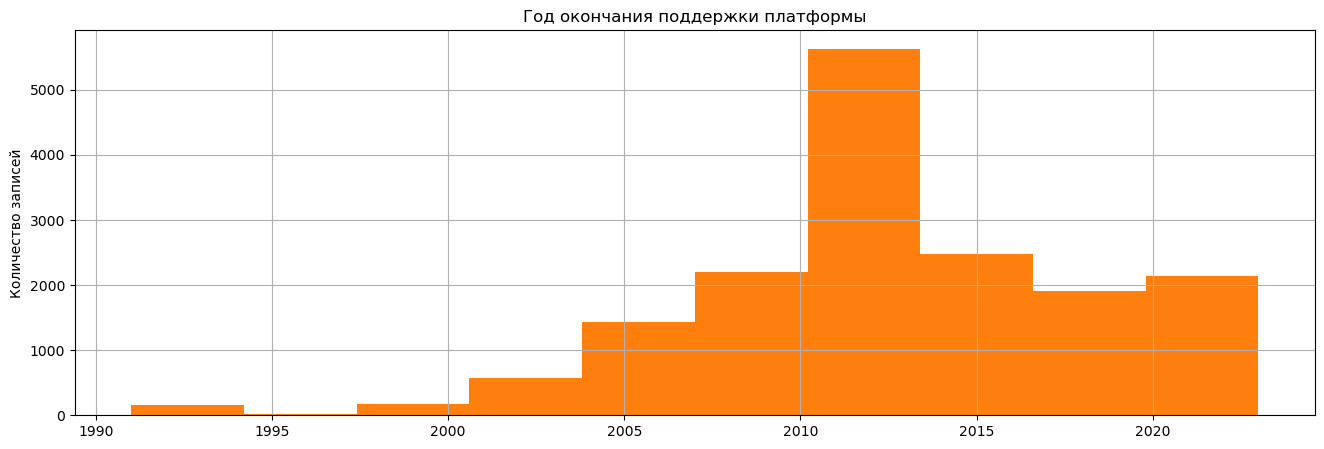


plat_median - Медианное значение года выпуска игр для платформы

Описание данных:
count   16,711.00
mean     2,006.47
std          5.53
min      1,982.00
25%      2,004.00
50%      2,008.00
75%      2,010.00
max      2,015.00
Name: plat_median, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


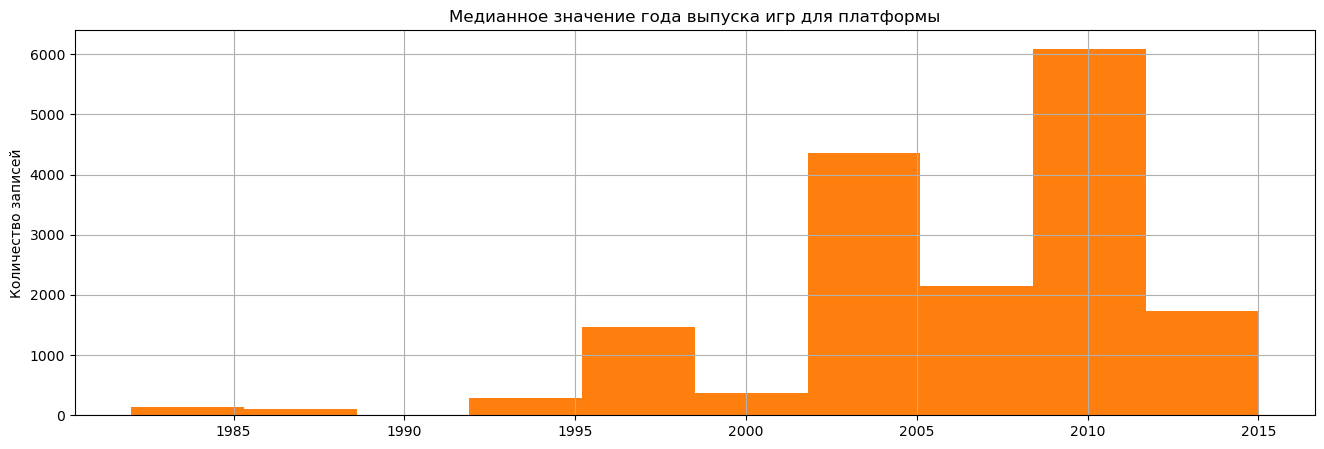


platform - Платформа

Описание данных:
count     16711
unique       31
top         PS2
freq       2161
Name: platform, dtype: object
Количество записей: 16711 из 16711

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


platform   cnt
0      PS2  2161
1       DS  2151
2      PS3  1329
3      Wii  1320
4     X360  1262
5      PSP  1209
6       PS  1197
7       PC   974
8       XB   824
9      GBA   822


Гистограмма значений:


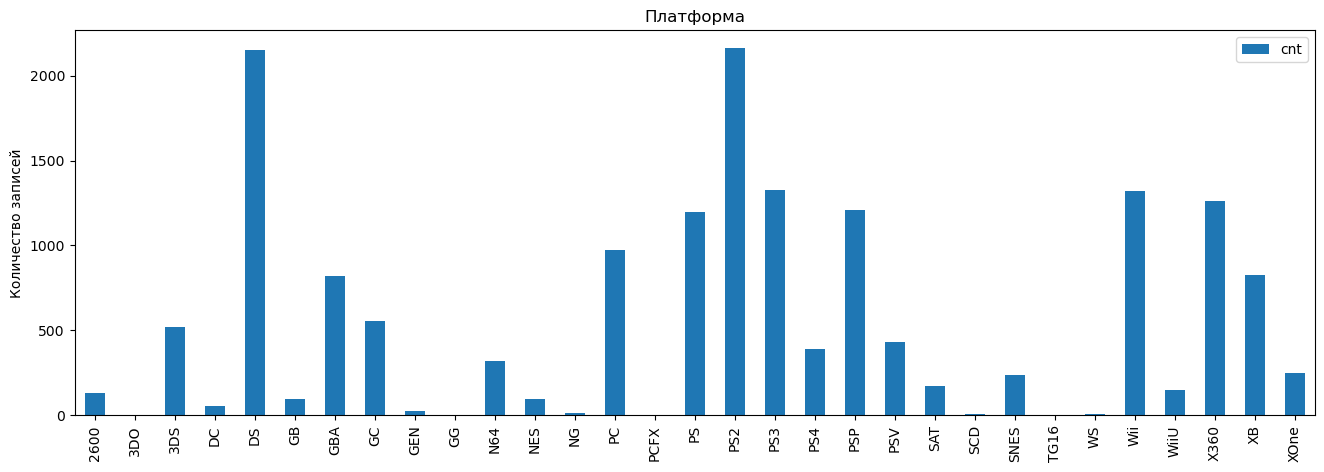


rating - Рейтинг от организации ESRB

Описание данных:
count     16711
unique        8
top          ND
freq       6327
Name: rating, dtype: object
Количество записей: 16711 из 16711

Тип:
 <class 'str'>

Распределение уникальных значений (первые 10 значений в порядке убывания):


rating   cnt
0     ND  6327
1      E  4158
2      T  3090
3      M  1653
4   E10+  1469
5     EC    10
6     RP     3
7     AO     1


Гистограмма значений:


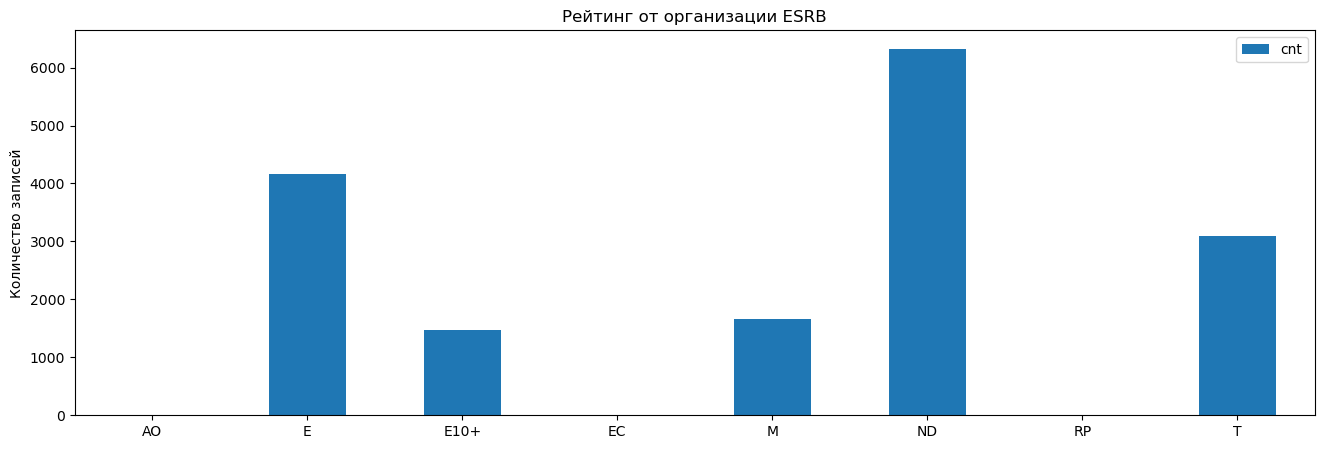


sum_sales - Суммарные продажи (миллионы долларов)

Описание данных:
count   16,711.00
mean         0.53
std          1.55
min          0.00
25%          0.06
50%          0.17
75%          0.47
max         82.54
Name: sum_sales, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.float64'>

Гистограмма значений:


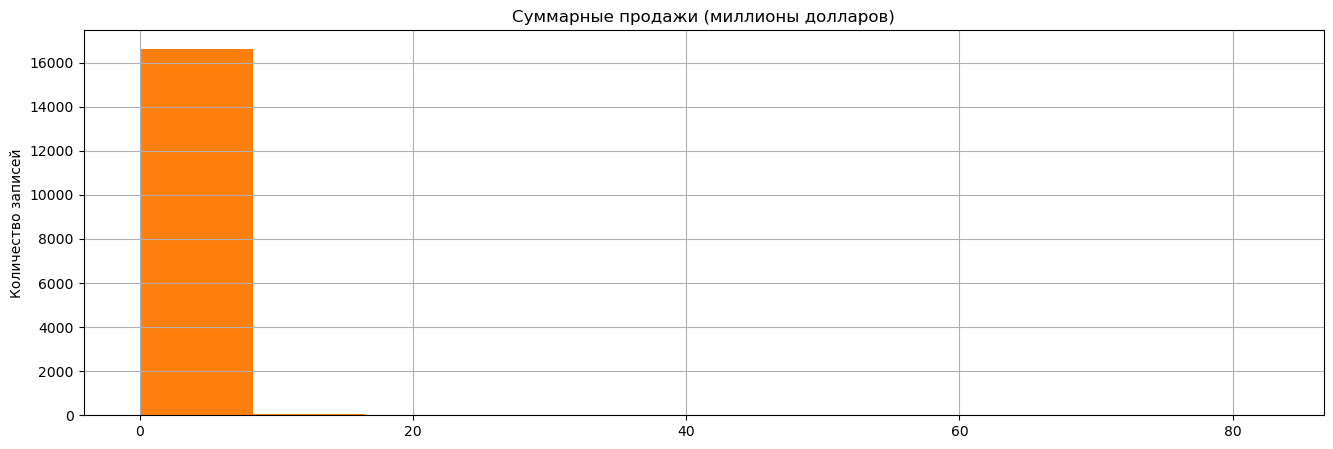


sum_score - Суммарная оценка (максимум 100)

Описание данных:
count   9,331.00
mean       69.25
std        13.27
min        11.00
25%        61.50
50%        71.50
75%        79.00
max        97.00
Name: sum_score, dtype: float64
Количество записей: 9331 из 16711
Пропущено: 7380


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


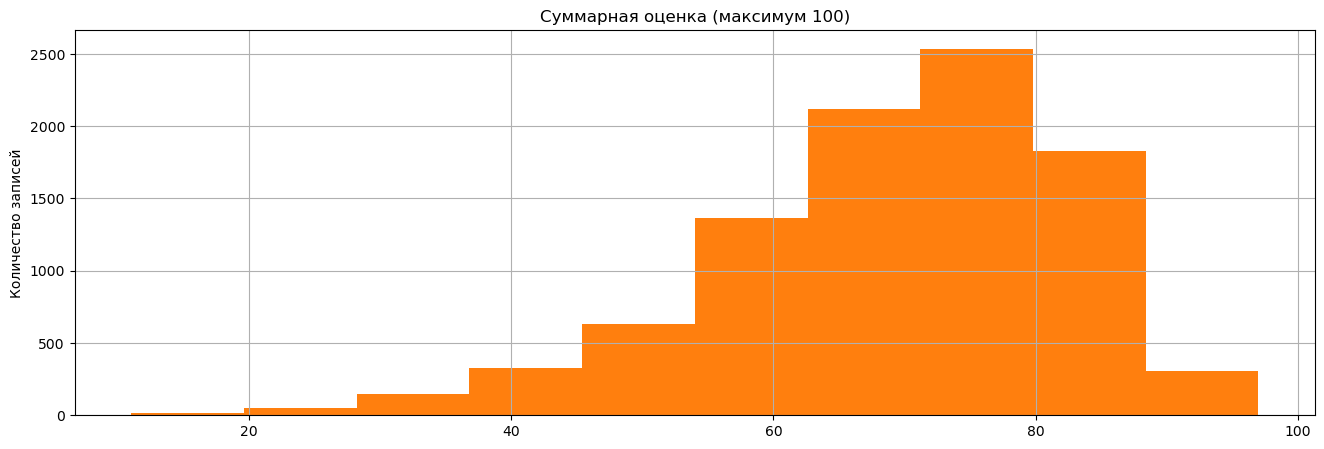


user_score - Оценка пользователей (максимум 10)

Описание данных:
count   7,587.00
mean        7.13
std         1.48
min         1.00
25%         6.40
50%         7.50
75%         8.20
max         9.70
Name: user_score, dtype: float64
Количество записей: 7587 из 16711
Пропущено: 9124


Тип:
 <class 'numpy.float64'>

Гистограмма значений:


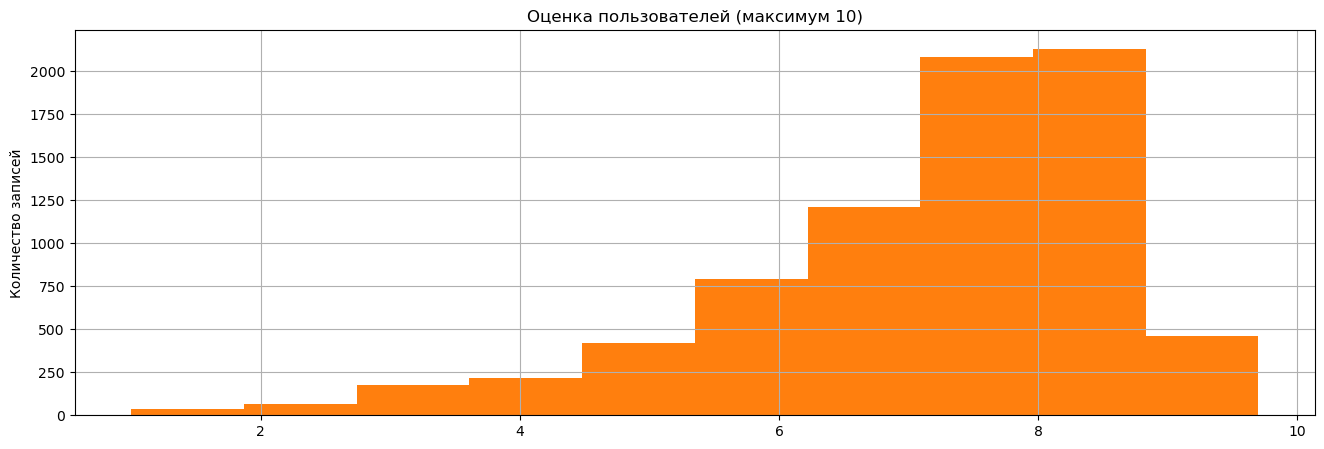


year_of_release - Год выпуска

Описание данных:
count   16,711.00
mean     2,006.47
std          5.89
min      1,980.00
25%      2,003.00
50%      2,007.00
75%      2,010.00
max      2,016.00
Name: year_of_release, dtype: float64
Количество записей: 16711 из 16711

Тип:
 <class 'numpy.int64'>

Гистограмма значений:


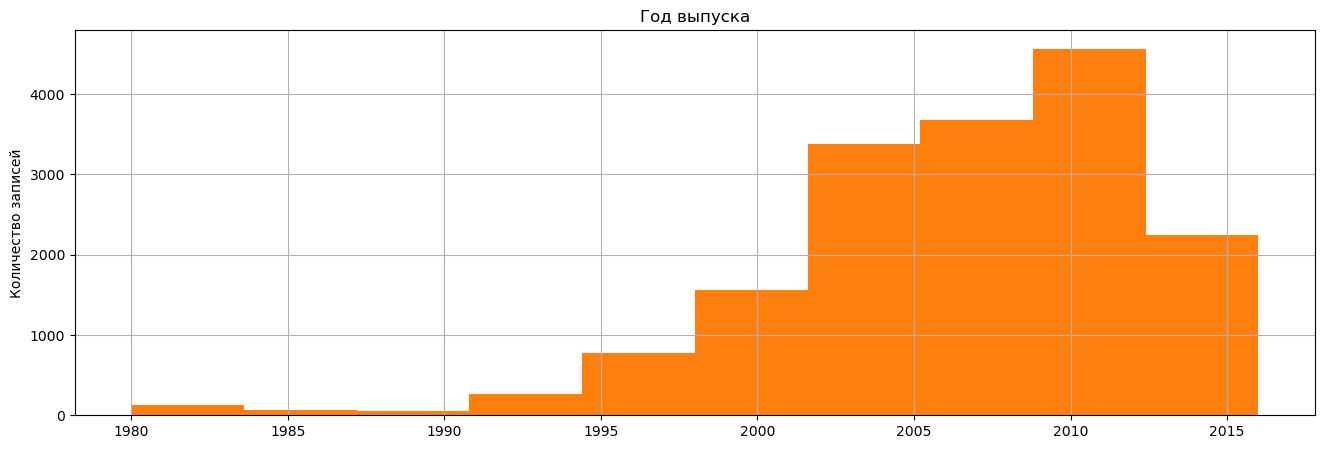

In [87]:
df_reaper(data, data_name, data_fields)

### Общий вывод по результатам подготовки данных

1. Удалены данные об играх, не имеющих информации о наименование.
Пропуски в  остальных данных частично заполнены, в том числе, за счёт взаимного использования информации из об тех же играх на других платформах, пропуски в рейтинге ESRB заполнены значением-"заглушкой"<br />
2. Удалены дубликаты
3. Добавлены новые столбцы, которые облегчают проведение предобработки и анализа данных
4. После предобработки данные подготовлены к проведению исследовательского анализа

## **Исследовательский анализ данных**

### Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

#### Выпущенные игры (по всем платформам):

In [88]:
all_games = data.pivot_table(index='year_of_release', aggfunc=['count','sum'], values='sum_sales').reset_index()
all_games.columns = ['year','count','sum']
all_games

year  count    sum
0   1980      9  11.38
1   1981     46  35.68
2   1982     52  36.85
3   1983     17  16.80
4   1984     14  50.35
5   1985     13  53.93
6   1986     21  37.08
7   1987     16  21.70
8   1988     14  45.78
9   1989     18  74.88
10  1990     16  49.37
11  1991     42  34.76
12  1992     43  76.16
13  1993     60  45.99
14  1994    121  79.23
15  1995    219  88.12
16  1996    263 199.15
17  1997    290 202.10
18  1998    386 259.59
19  1999    340 251.45
20  2000    348 200.60
21  2001    491 334.71
22  2002    844 401.39
23  2003    797 371.39
24  2004    793 429.86
25  2005    947 460.02
26  2006   1019 523.11
27  2007   1201 606.14
28  2008   1462 683.04
29  2009   1455 664.19
30  2010   1284 599.83
31  2011   1166 515.37
32  2012    661 360.51
33  2013    564 367.65
34  2014    579 328.16
35  2015    599 266.72
36  2016    501 129.76

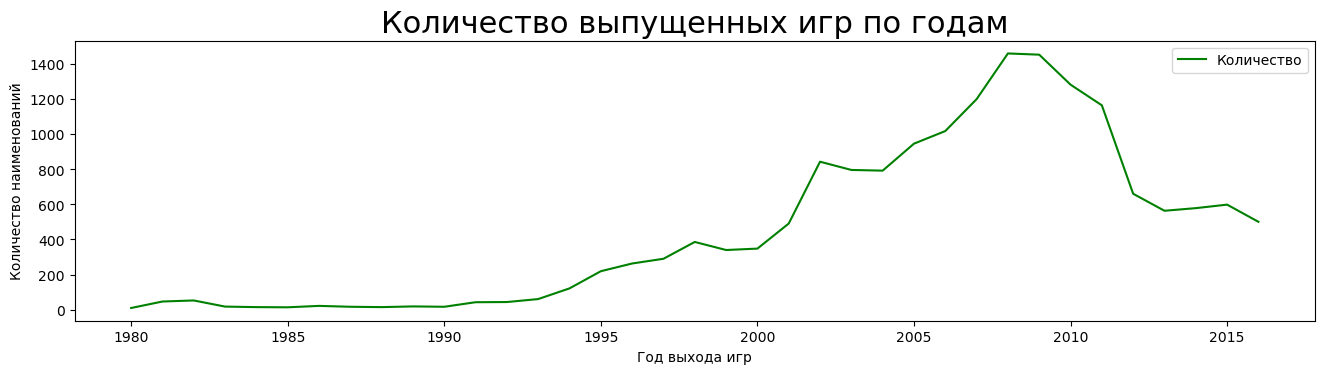

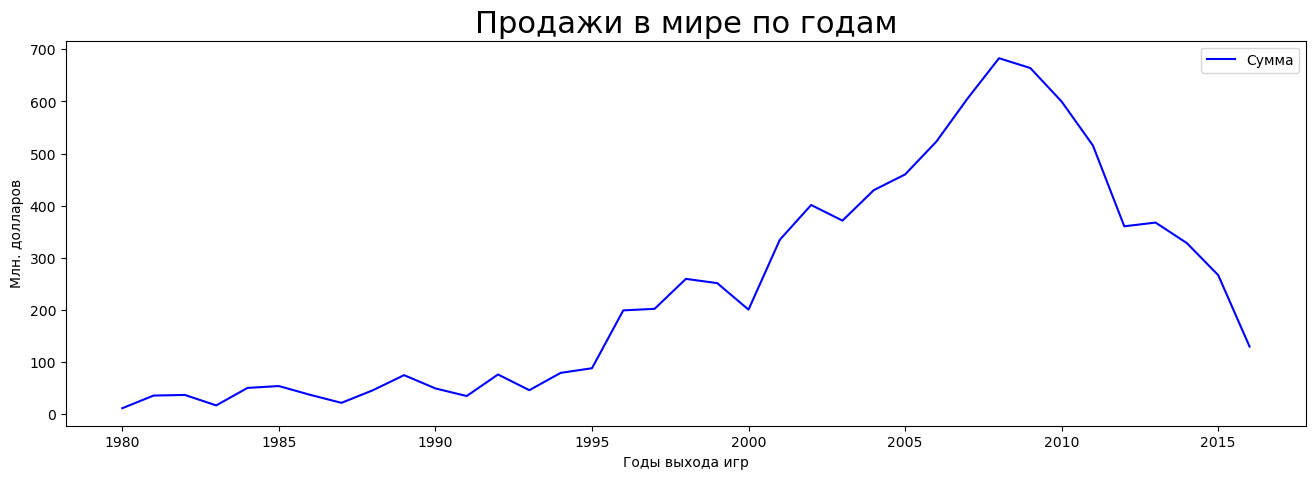

In [89]:
plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plt.title('Количество выпущенных игр по годам', fontsize=22)
sns.lineplot(data=all_games, x="year", y="count", color="g", label="Количество")
plt.xlabel('Год выхода игр') 
plt.ylabel('Количество наименований')
plt.figure(figsize=(16,5))
plt.title('Продажи в мире по годам', fontsize=22)
sns.lineplot(data=all_games, x="year", y="sum", color="b", label="Сумма")
plt.xlabel('Годы выхода игр') 
plt.ylabel('Млн. долларов')
plt.legend()
plt.show()

Пик продаж пришелся на игры, выпущенные в 2008 году

Проанализируем данные по количеству продаж:

#### Важны ли данные за все периоды?

Можно оставить только те данные, которые относятся к платформам, актуальным на конец 2016 года.<br />
Поэтому предлагаю считать актуальным период, в который существовали все актуальные игровые платформы

Платформы, актуальные на конец 2016 года:

In [90]:
platforms_actual = list(platforms_live.query('plat_end >= 2016')['platform'])
platforms_actual

['X360', 'PS3', 'PS4', '3DS', 'PC', 'XOne', 'WiiU', 'PSV']

И год, начиная с которого данные можно считать актуальными:

In [91]:
actual_begin = platforms_live.query('plat_end >= 2016')['plat_begin'].max()
actual_begin

2013

То есть, будем считать актуальным период с 2013 по 2016 гг.

#### Изменения продаж по платформам

##### По количеству игр:

In [92]:
plat_games = data.pivot_table(index='year_of_release', columns='platform', aggfunc='count', values='name')
plat_games_show = plat_games.fillna(0).astype('int').astype('str').replace('0','-').reset_index()

games_count = {}
games_count['year_of_release'] = 'Сумма'
cols = plat_games.columns
for col in cols:
    games_count[col] = plat_games[col].sum().astype('int64')
plat_games_show = plat_games_show.append(games_count,ignore_index=True)

plat_games_show

year_of_release 2600 3DO  3DS  DC    DS  GB  GBA   GC GEN GG  N64 NES  NG  \
0             1980    9   -    -   -     -   -    -    -   -  -    -   -   -   
1             1981   46   -    -   -     -   -    -    -   -  -    -   -   -   
2             1982   52   -    -   -     -   -    -    -   -  -    -   -   -   
3             1983   11   -    -   -     -   -    -    -   -  -    -   6   -   
4             1984    1   -    -   -     -   -    -    -   -  -    -  13   -   
5             1985    1   -    -   -     -   -    -    -   -  -    -  11   -   
6             1986    2   -    -   -     -   -    -    -   -  -    -  19   -   
7             1987    6   -    -   -     -   -    -    -   -  -    -  10   -   
8             1988    2   -    -   -     -   -    -    -   -  -    -  11   -   
9             1989    2   -    -   -     -  11    -    -   -  -    -   5   -   
10            1990    -   -    -   -     -   3    -    -   1  -    -   8   -   
11            1991    1   -    -   -     -   9    -    -   1  -    -   7   -   
12            1992    -   -    -   -     -   7    -    -   6  1    -   3   -   
13            1993    -   -    -   -     -   -    -    -   7  -    -   4   2   
14            1994    -   1    -   -     -   3    -    -  12  -    -   1   4   
15            1995    -   2    -   -     -   4    -    -   -  -    -   -   4   
16            1996    -   -    -   -     -   6    -    -   -  -   18   -   2   
17            1997    -   -    -   -     -   9    -    -   -  -   49   -   -   
18            1998    -   -    -   7     -   8    -    -   -  -   77   -   -   
19            1999    -   -    -  14     -  11    -    -   -  -  104   -   -   
20            2000    -   -    -  20     -  17    -    -   -  -   60   -   -   
21            2001    -   -    -  11     -  10  108   23   -  -    9   -   -   
22            2002    -   -    -   -     -   -  198  154   -  -    2   -   -   
23            2003    -   -    -   -     -   -  159  153   -  -    -   -   -   
24            2004    -   -    -   -    24   -  175   83   -  -    -   -   -   
25            2005    -   -    -   -   118   -  136   98   -  -    -   -   -   
26            2006    -   -    -   -   201   -   40   41   -  -    -   -   -   
27            2007    -   -    -   -   377   -    6    4   -  -    -   -   -   
28            2008    -   -    -   -   516   -    -    -   -  -    -   -   -   
29            2009    -   -    -   -   404   -    -    -   -  -    -   -   -   
30            2010    -   -    -   -   324   -    -    -   -  -    -   -   -   
31            2011    -   -  118   -   155   -    -    -   -  -    -   -   -   
32            2012    -   -   94   -    24   -    -    -   -  -    -   -   -   
33            2013    -   -   96   -     8   -    -    -   -  -    -   -   -   
34            2014    -   -   80   -     -   -    -    -   -  -    -   -   -   
35            2015    -   -   86   -     -   -    -    -   -  -    -   -   -   
36            2016    -   -   46   -     -   -    -    -   -  -    -   -   -   
37           Сумма  133   3  520  52  2151  98  822  556  27  1  319  98  12   

     PC PCFX    PS   PS2   PS3  PS4   PSP  PSV  SAT SCD SNES TG16 WS   Wii  \
0     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
1     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
2     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
3     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
4     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
5     1    -     -     -     -    -     -    -    -   -    -    -  -     -   
6     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
7     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
8     1    -     -     -     -    -     -    -    -   -    -    -  -     -   
9     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
10    -    -     -     -

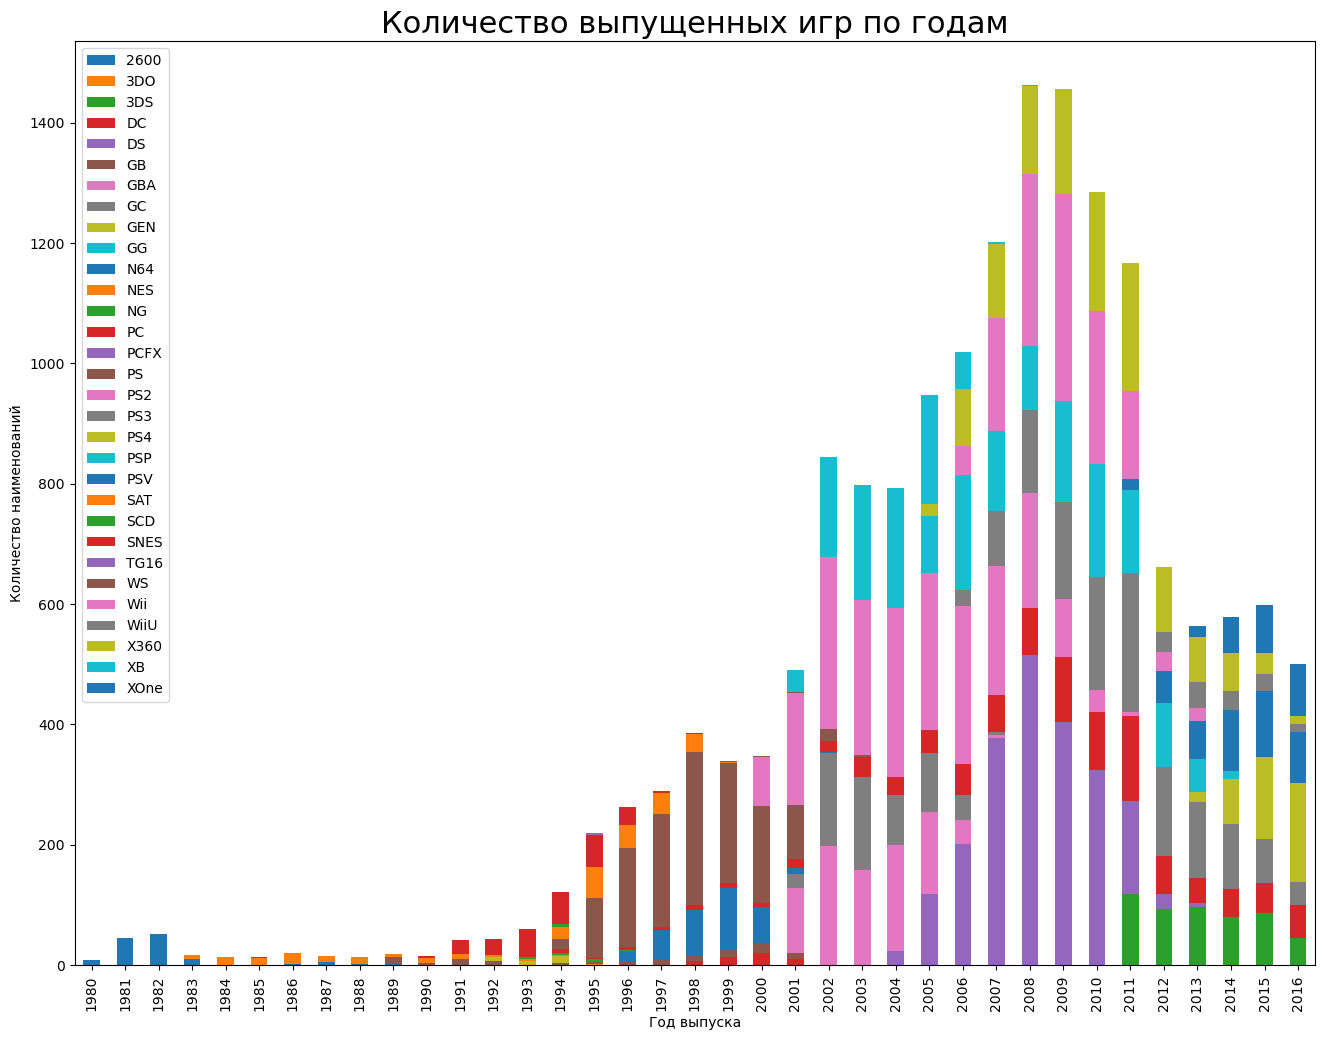

In [93]:
plat_games.plot(kind='bar', stacked= True,figsize=(16,12))
plt.title('Количество выпущенных игр по годам', fontsize=22)
plt.xlabel('Год выпуска')
plt.ylabel('Количество наименований')
plt.legend()
plt.show()

**Платформы, для которых было выпущено больше всего игр (Топ-10):**

In [94]:
data_games_count = pd.DataFrame(list(games_count.items()),columns=['platform', 'count']).query('count != "Сумма"')
data_games_count.sort_values(by='count', ascending=False).reset_index(drop=True).head(10)

platform count
0      PS2  2161
1       DS  2151
2      PS3  1329
3      Wii  1320
4     X360  1262
5      PSP  1209
6       PS  1197
7       PC   974
8       XB   824
9      GBA   822

По годам:

In [95]:
col_list = list(data_games_count.sort_values(by='count', ascending=False).head(10)['platform'])
top10_plat_games = plat_games[col_list]
col_list.insert(0,'year_of_release')
top10_plat_games_show = plat_games_show[col_list]

In [96]:
top10_plat_games_show

year_of_release   PS2    DS   PS3   Wii  X360   PSP    PS   PC   XB  GBA
0             1980     -     -     -     -     -     -     -    -    -    -
1             1981     -     -     -     -     -     -     -    -    -    -
2             1982     -     -     -     -     -     -     -    -    -    -
3             1983     -     -     -     -     -     -     -    -    -    -
4             1984     -     -     -     -     -     -     -    -    -    -
5             1985     -     -     -     -     -     -     -    1    -    -
6             1986     -     -     -     -     -     -     -    -    -    -
7             1987     -     -     -     -     -     -     -    -    -    -
8             1988     -     -     -     -     -     -     -    1    -    -
9             1989     -     -     -     -     -     -     -    -    -    -
10            1990     -     -     -     -     -     -     -    -    -    -
11            1991     -     -     -     -     -     -     -    -    -    -
12            1992     -     -     -     -     -     -     -    5    -    -
13            1993     -     -     -     -     -     -     -    -    -    -
14            1994     -     -     -     -     -     -    17    6    -    -
15            1995     -     -     -     -     -     -    99    2    -    -
16            1996     -     -     -     -     -     -   164    4    -    -
17            1997     -     -     -     -     -     -   188    6    -    -
18            1998     -     -     -     -     -     -   255    8    -    -
19            1999     -     -     -     -     -     -   200    7    -    -
20            2000    82     -     -     -     -     -   160    7    -    -
21            2001   185     -     -     -     -     -    91   15   37  108
22            2002   285     -     -     -     -     -    20   19  166  198
23            2003   258     -     -     -     -     -     3   34  190  159
24            2004   281    24     -     -     -    15     -   30  185  175
25            2005   261   118     -     -    21    95     -   38  180  136
26            2006   262   201    28    48    94   191     -   52   62   40
27            2007   215   377    90   187   123   134     -   62    3    6
28            2008   191   516   139   286   147   105     -   77    1    -
29            2009    96   404   162   344   174   167     -  108    -    -
30            2010    38   324   187   254   197   188     -   96    -    -
31            2011     7   155   230   146   212   139     -  141    -    -
32            2012     -    24   148    32   108   107     -   63    -    -
33            2013     -     8   126    23    75    55     -   41    -    -
34            2014     -     -   108     -    63    13     -   47    -    -
35            2015     -     -    73     -    35     -     -   50    -    -
36            2016     -     -    38     -    13     -     -   54    -    -
37           Сумма  2161  2151  1329  1320  1262  1209  1197  974  824  822

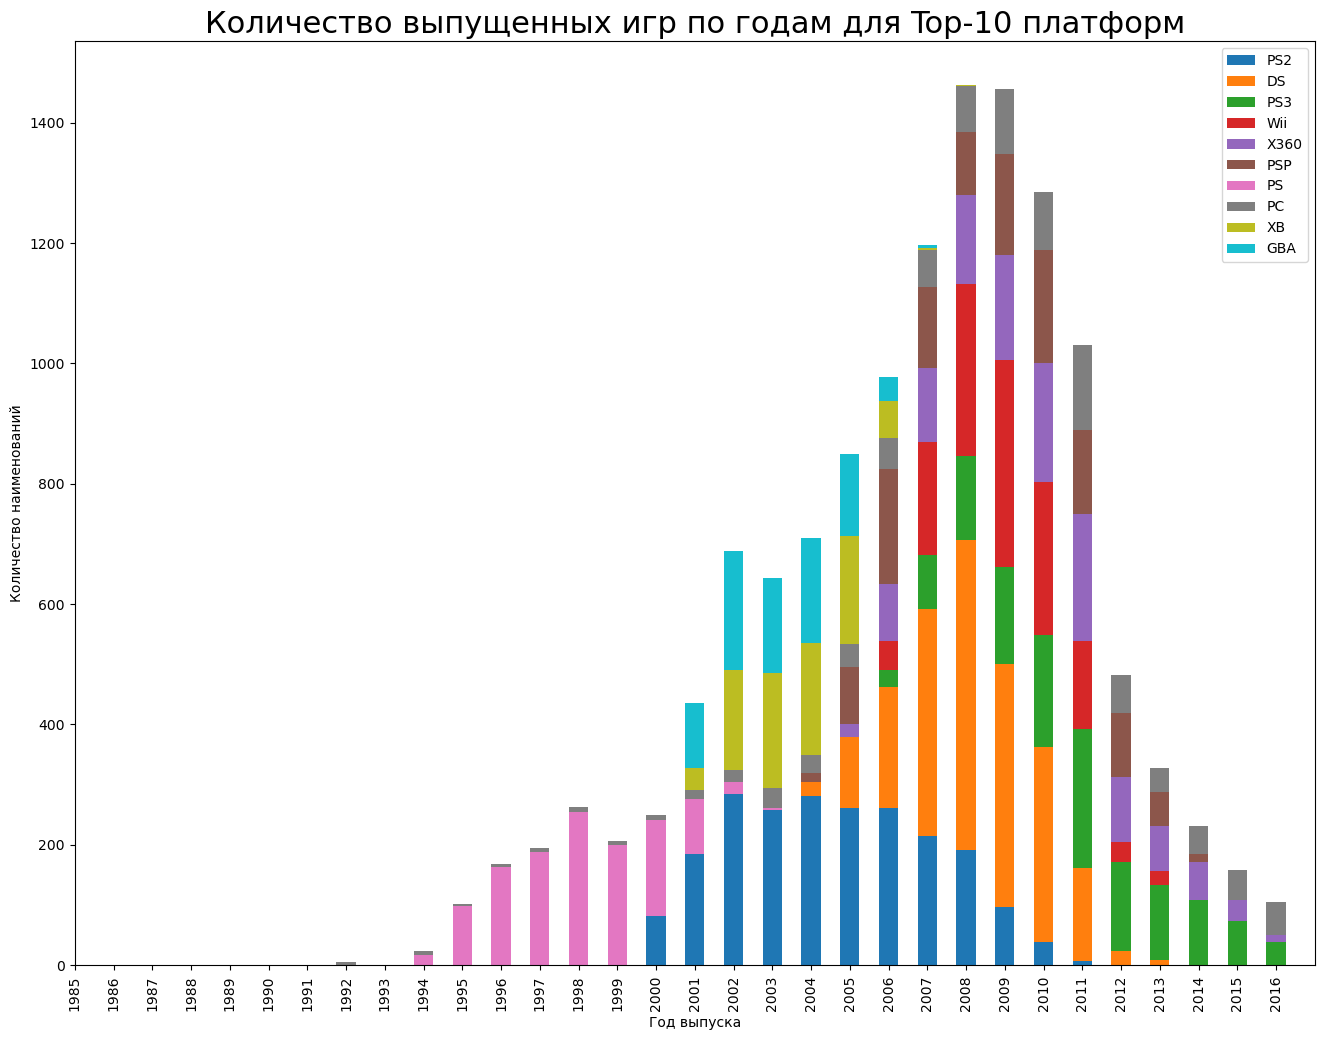

In [97]:
top10_plat_games.plot(kind='bar', stacked=True,figsize=(16,12))
plt.title('Количество выпущенных игр по годам для Top-10 платформ', fontsize=22)
plt.xlabel('Год выпуска')
plt.ylabel('Количество наименований')
plt.legend()
plt.xlim([5, 37])
plt.show()

##### По суммам продаж:

(данные округлены до целых миллионов долларов)

In [98]:
plat_sum = data.pivot_table(index='year_of_release', columns='platform', aggfunc='sum', values='sum_sales')
plat_sum_show = plat_sum.fillna(0).apply(np.round).astype('int').astype('str').replace('0','-').reset_index()

games_sum = {}
games_sum['year_of_release'] = 'Сумма'
cols = plat_sum.columns
for col in cols:
    games_sum[col] = plat_sum[col].sum()
plat_sum_show = plat_sum_show.append(games_count,ignore_index=True)

plat_sum_show

year_of_release 2600 3DO  3DS  DC    DS  GB  GBA   GC GEN GG  N64 NES  NG  \
0             1980   11   -    -   -     -   -    -    -   -  -    -   -   -   
1             1981   36   -    -   -     -   -    -    -   -  -    -   -   -   
2             1982   37   -    -   -     -   -    -    -   -  -    -   -   -   
3             1983    6   -    -   -     -   -    -    -   -  -    -  11   -   
4             1984    -   -    -   -     -   -    -    -   -  -    -  50   -   
5             1985    -   -    -   -     -   -    -    -   -  -    -  53   -   
6             1986    1   -    -   -     -   -    -    -   -  -    -  36   -   
7             1987    2   -    -   -     -   -    -    -   -  -    -  20   -   
8             1988    1   -    -   -     -   -    -    -   -  -    -  45   -   
9             1989    1   -    -   -     -  66    -    -   -  -    -   8   -   
10            1990    -   -    -   -     -   5    -    -   3  -    -  16   -   
11            1991    3   -    -   -     -   6    -    -   4  -    -   6   -   
12            1992    -   -    -   -     -  25    -    -  13  -    -   2   -   
13            1993    -   -    -   -     -   -    -    -   1  -    -   4   -   
14            1994    -   -    -   -     -  12    -    -   8  -    -   -   1   
15            1995    -   -    -   -     -   4    -    -   -  -    -   -   -   
16            1996    -   -    -   -     -  36    -    -   -  -   34   -   -   
17            1997    -   -    -   -     -   7    -    -   -  -   40   -   -   
18            1998    -   -    -   3     -  27    -    -   -  -   49   -   -   
19            1999    -   -    -   5     -  38    -    -   -  -   58   -   -   
20            2000    -   -    -   6     -  20    -    -   -  -   34   -   -   
21            2001    -   -    -   1     -   9   62   27   -  -    3   -   -   
22            2002    -   -    -   -     -   -   74   52   -  -    -   -   -   
23            2003    -   -    -   -     -   -   61   52   -  -    -   -   -   
24            2004    -   -    -   -    17   -   78   29   -  -    -   -   -   
25            2005    -   -    -   -   130   -   35   28   -  -    -   -   -   
26            2006    -   -    -   -   120   -    5   12   -  -    -   -   -   
27            2007    -   -    -   -   147   -    3    -   -  -    -   -   -   
28            2008    -   -    -   -   147   -    -    -   -  -    -   -   -   
29            2009    -   -    -   -   120   -    -    -   -  -    -   -   -   
30            2010    -   -    -   -    85   -    -    -   -  -    -   -   -   
31            2011    -   -   64   -    26   -    -    -   -  -    -   -   -   
32            2012    -   -   52   -    12   -    -    -   -  -    -   -   -   
33            2013    -   -   57   -     2   -    -    -   -  -    -   -   -   
34            2014    -   -   44   -     -   -    -    -   -  -    -   -   -   
35            2015    -   -   28   -     -   -    -    -   -  -    -   -   -   
36            2016    -   -   15   -     -   -    -    -   -  -    -   -   -   
37           Сумма  133   3  520  52  2151  98  822  556  27  1  319  98  12   

     PC PCFX    PS   PS2   PS3  PS4   PSP  PSV  SAT SCD SNES TG16 WS   Wii  \
0     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
1     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
2     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
3     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
4     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
5     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
6     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
7     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
8     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
9     -    -     -     -     -    -     -    -    -   -    -    -  -     -   
10    -    -     -     -

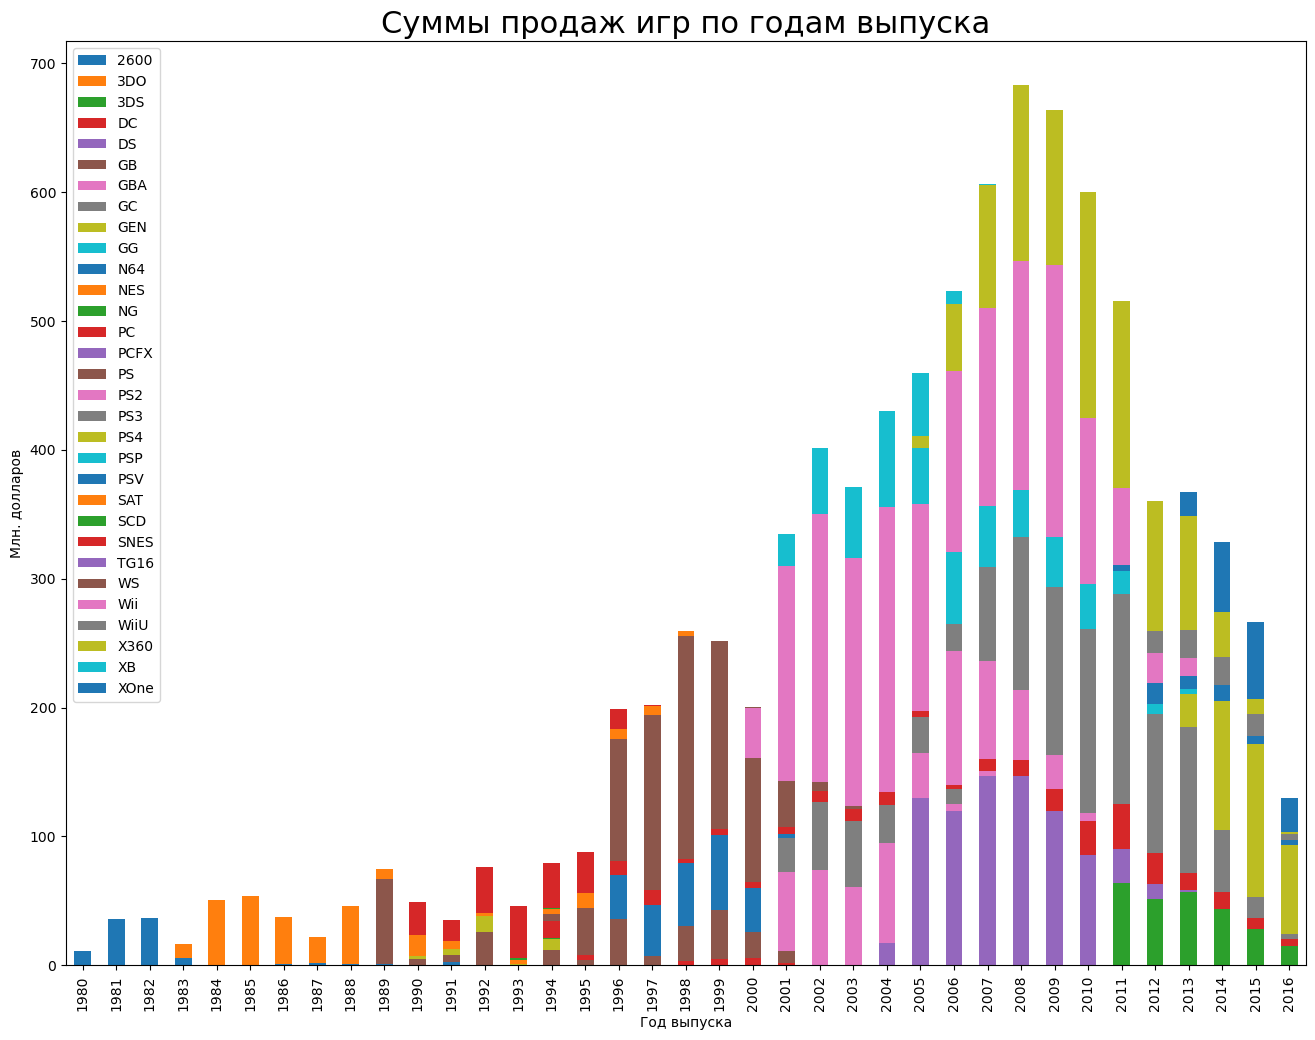

In [99]:
plat_sum.plot(kind='bar', stacked= True,figsize=(16,12))
plt.title('Суммы продаж игр по годам выпуска', fontsize=22)
plt.xlabel('Год выпуска')
plt.ylabel('Млн. долларов')
plt.legend()
plt.show()

**Платформы, игры для которых заработали больше всего (Топ-10):**

In [100]:
data_games_sum = pd.DataFrame(list(games_sum.items()),columns=['platform', 'sum']).query('sum != "Сумма"')
data_games_sum.sort_values(by='sum', ascending=False).reset_index(drop=True).head(10)

platform      sum
0      PS2 1,255.77
1     X360   971.42
2      PS3   939.16
3      Wii   907.51
4       DS   806.12
5       PS   730.86
6      GBA   317.85
7      PS4   314.14
8      PSP   294.05
9       PC   259.52

По годам:

In [101]:
col_list = list(data_games_sum.sort_values(by='sum', ascending=False).head(10)['platform'])
top10_plat_sum = plat_games[col_list]
col_list.insert(0,'year_of_release')
top10_plat_sum_show = plat_games_show[col_list]

In [102]:
top10_plat_sum_show

year_of_release   PS2  X360   PS3   Wii    DS    PS  GBA  PS4   PSP   PC
0             1980     -     -     -     -     -     -    -    -     -    -
1             1981     -     -     -     -     -     -    -    -     -    -
2             1982     -     -     -     -     -     -    -    -     -    -
3             1983     -     -     -     -     -     -    -    -     -    -
4             1984     -     -     -     -     -     -    -    -     -    -
5             1985     -     -     -     -     -     -    -    -     -    1
6             1986     -     -     -     -     -     -    -    -     -    -
7             1987     -     -     -     -     -     -    -    -     -    -
8             1988     -     -     -     -     -     -    -    -     -    1
9             1989     -     -     -     -     -     -    -    -     -    -
10            1990     -     -     -     -     -     -    -    -     -    -
11            1991     -     -     -     -     -     -    -    -     -    -
12            1992     -     -     -     -     -     -    -    -     -    5
13            1993     -     -     -     -     -     -    -    -     -    -
14            1994     -     -     -     -     -    17    -    -     -    6
15            1995     -     -     -     -     -    99    -    -     -    2
16            1996     -     -     -     -     -   164    -    -     -    4
17            1997     -     -     -     -     -   188    -    -     -    6
18            1998     -     -     -     -     -   255    -    -     -    8
19            1999     -     -     -     -     -   200    -    -     -    7
20            2000    82     -     -     -     -   160    -    -     -    7
21            2001   185     -     -     -     -    91  108    -     -   15
22            2002   285     -     -     -     -    20  198    -     -   19
23            2003   258     -     -     -     -     3  159    -     -   34
24            2004   281     -     -     -    24     -  175    -    15   30
25            2005   261    21     -     -   118     -  136    -    95   38
26            2006   262    94    28    48   201     -   40    -   191   52
27            2007   215   123    90   187   377     -    6    -   134   62
28            2008   191   147   139   286   516     -    -    -   105   77
29            2009    96   174   162   344   404     -    -    -   167  108
30            2010    38   197   187   254   324     -    -    -   188   96
31            2011     7   212   230   146   155     -    -    -   139  141
32            2012     -   108   148    32    24     -    -    -   107   63
33            2013     -    75   126    23     8     -    -   16    55   41
34            2014     -    63   108     -     -     -    -   75    13   47
35            2015     -    35    73     -     -     -    -  137     -   50
36            2016     -    13    38     -     -     -    -  164     -   54
37           Сумма  2161  1262  1329  1320  2151  1197  822  392  1209  974

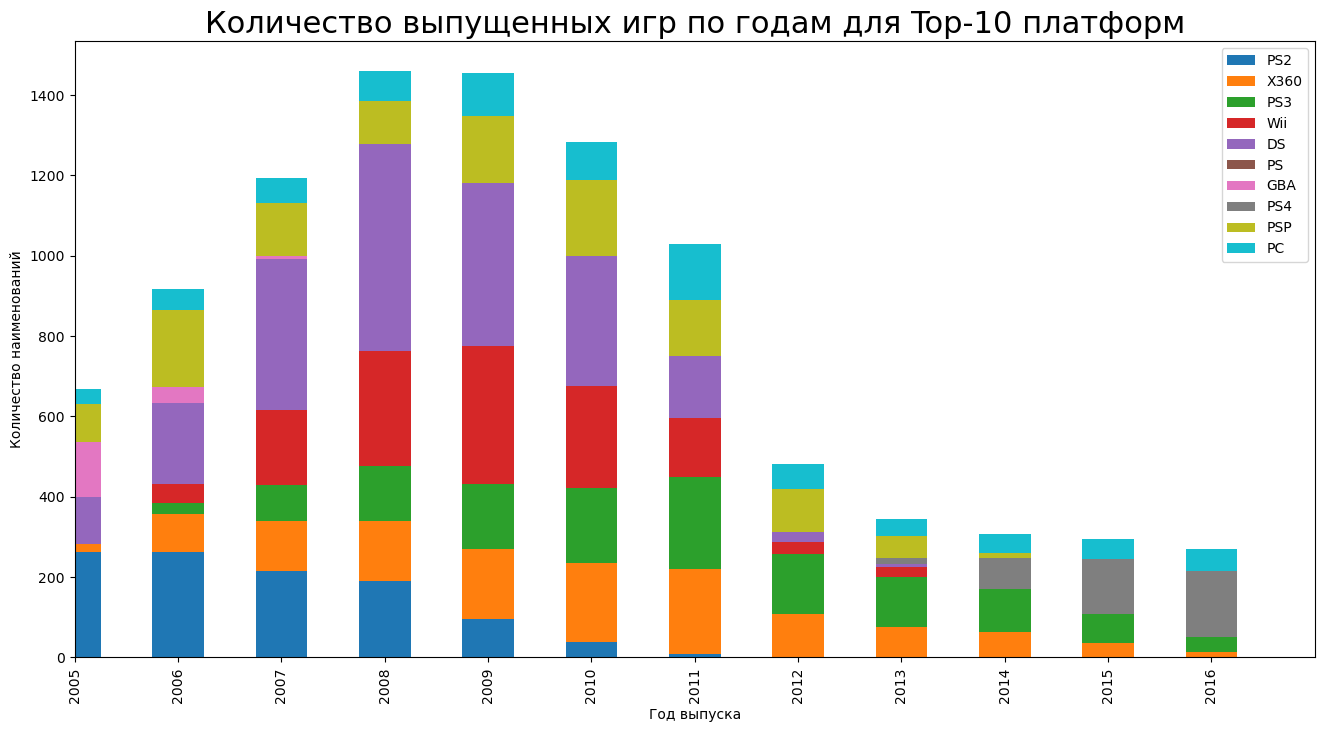

In [103]:
top10_plat_sum.plot(kind='bar', stacked=True,figsize=(16,8))
plt.title('Количество выпущенных игр по годам для Top-10 платформ', fontsize=22)
plt.xlabel('Год выпуска')
plt.ylabel('Количество наименований')
plt.legend()
plt.xlim([25, 37])
plt.show()

##### За какой характерный срок появляются новые и исчезают старые платформы?

У нас есть данные по жизненным циклам платформ:

In [104]:
platforms_live.head()

platform  plat_begin  plat_end  plat_median
0      Wii        2006      2013         2009
1      NES        1983      2003         1986
2       GB        1989      2003         1997
3       DS        2004      2013         2008
4     X360        2005      2016         2010

In [105]:
plat_born = platforms_live.pivot_table(index='plat_begin', values = 'platform', aggfunc='count' ).reset_index()

#df= pd.DataFrame(columns = plat_born.columns)
for year in range(1998,2017):
    if len(plat_born.query('plat_begin == @year')) == 0:
        plat_born = plat_born.append({'plat_begin':year,'platform':0}, ignore_index=True)
plat_born = plat_born.sort_values(by='plat_begin')
plat_born

plat_begin  platform
0         1977         1
1         1978         1
2         1983         1
3         1986         1
4         1989         1
5         1990         3
6         1992         2
7         1993         1
8         1994         3
9         1996         1
10        1998         1
11        1999         1
12        2000         1
13        2001         3
20        2002         0
21        2003         0
14        2004         2
15        2005         1
16        2006         2
22        2007         0
23        2008         0
24        2009         0
25        2010         0
17        2011         2
18        2012         1
19        2013         2
26        2014         0
27        2015         0
28        2016         0

In [106]:
plat_born['platform'].describe()

count   29.00
mean     1.07
std      0.96
min      0.00
25%      0.00
50%      1.00
75%      2.00
max      3.00
Name: platform, dtype: float64

Обычно в год появляется от 0 до 2 игровых платформ.

Рассчитаем для время жизни игровых платформ:

In [107]:
platforms_live['plat_live'] = platforms_live['plat_end'] - platforms_live['plat_begin']+1

In [108]:
platforms_live.head()

platform  plat_begin  plat_end  plat_median  plat_live
0      Wii        2006      2013         2009          8
1      NES        1983      2003         1986         21
2       GB        1989      2003         1997         15
3       DS        2004      2013         2008         10
4     X360        2005      2016         2010         12

И проанализируем эти данные:

In [109]:
platforms_live['plat_live'].describe()

count   31.00
mean    10.26
std      7.95
min      1.00
25%      6.50
50%      9.00
75%     12.00
max     46.00
Name: plat_live, dtype: float64

<AxesSubplot:>

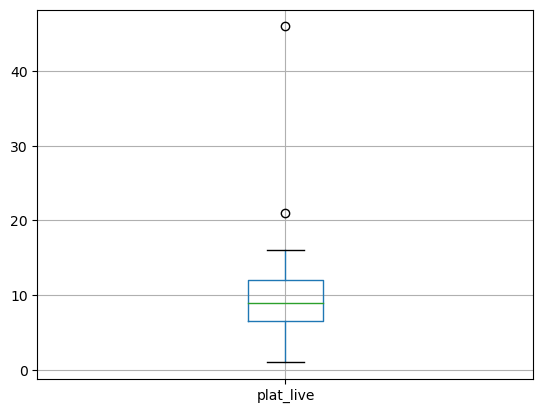

In [110]:
platforms_live.boxplot(column='plat_live')

Характерный срок жизни платформ составляет от 6.5 до 12 лет

### Оставим только актуальные данные:

Создадим новый датафрейм, включающие только данные по актуальным платформам и за актуальный период

In [111]:
act_data = data.query('year_of_release >= @actual_begin and platform in @platforms_actual')
act_data.head()

critic_score  eu_sales    genre  jp_sales  na_sales  \
3668         97.00      5.14   Action      0.06      9.66   
3675         73.00      2.56  Shooter      0.04      6.73   
3679           NaN      2.65     Misc      0.02      5.70   
3700         81.00      1.11  Shooter      0.00      2.77   
3702         84.00      2.89   Sports      0.01      0.92   

                                name  other_sales  plat_begin  plat_end  \
3668              Grand Theft Auto V         1.41        2005      2016   
3675            Call of Duty: Ghosts         0.91        2005      2016   
3679                       Minecraft         0.81        2005      2016   
3700  Call of Duty: Advanced Warfare         0.40        2005      2016   
3702                         FIFA 14         0.40        2005      2016   

      plat_median platform rating  sum_sales  sum_score  user_score  \
3668         2010     X360      M      16.27      89.00        8.10   
3675         2010     X360      M      10.24      49.50        2.60   
3679         2010     X360     ND       9.18        NaN         NaN   
3700         2010     X360      M       4.28      65.00        4.90   
3702         2010     X360      E       4.22      63.00        4.20   

      year_of_release  
3668             2013  
3675             2013  
3679             2013  
3700             2014  
3702             2013

### Изменения продаж по платформам (для актуальных данных)

#### По количеству игр:

In [112]:
plat_games = act_data.pivot_table(index='year_of_release', columns='platform', aggfunc='count', values='name')
plat_games_show = plat_games.fillna(0).astype('int').astype('str').replace('0','-').reset_index()

games_count = {}
games_count['year_of_release'] = 'Сумма'
cols = plat_games.columns
for col in cols:
    games_count[col] = plat_games[col].sum().astype('int64')
plat_games_show = plat_games_show.append(games_count,ignore_index=True)

plat_games_show

year_of_release  3DS   PC  PS3  PS4  PSV WiiU X360 XOne
0            2013   96   41  126   16   63   42   75   19
1            2014   80   47  108   75  101   31   63   61
2            2015   86   50   73  137  110   28   35   80
3            2016   46   54   38  164   85   14   13   87
4           Сумма  308  192  345  392  359  115  186  247

In [113]:
data_games_count = pd.DataFrame(list(games_count.items()),columns=['platform', 'count']).query('count != "Сумма"')
data_games_count.sort_values(by='count', ascending=False).reset_index(drop=True).head(10)

platform count
0      PS4   392
1      PSV   359
2      PS3   345
3      3DS   308
4     XOne   247
5       PC   192
6     X360   186
7     WiiU   115

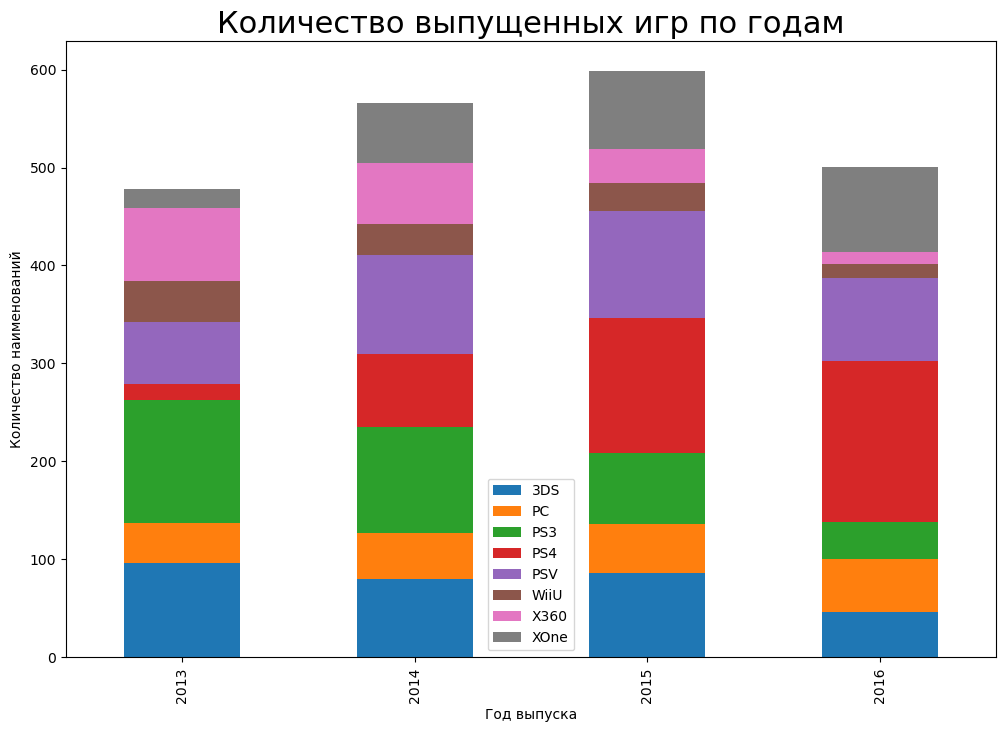

In [114]:
plat_games.plot(kind='bar', stacked= True,figsize=(12,8))
plt.title('Количество выпущенных игр по годам', fontsize=22)
plt.xlabel('Год выпуска')
plt.ylabel('Количество наименований')
plt.legend()
plt.show()

Количество новых игр каждый год растёт! (за 2016 данные не полны)

#### По суммам продаж:

(данные округлены до целых миллионов долларов)

In [115]:
plat_sum = act_data.pivot_table(index='year_of_release', columns='platform', aggfunc='sum', values='sum_sales')
plat_sum_show = plat_sum.fillna(0).apply(np.round).astype('int').astype('str').replace('0','-').reset_index()

games_sum = {}
games_sum['year_of_release'] = 'Сумма'
cols = plat_sum.columns
for col in cols:
    games_sum[col] = plat_sum[col].sum()
plat_sum_show = plat_sum_show.append(games_count,ignore_index=True)

plat_sum_show

year_of_release  3DS   PC  PS3  PS4  PSV WiiU X360 XOne
0            2013   57   13  113   26   11   22   89   19
1            2014   44   13   48  100   12   22   35   54
2            2015   28    9   17  119    6   16   12   60
3            2016   15    5    4   69    4    5    2   26
4           Сумма  308  192  345  392  359  115  186  247

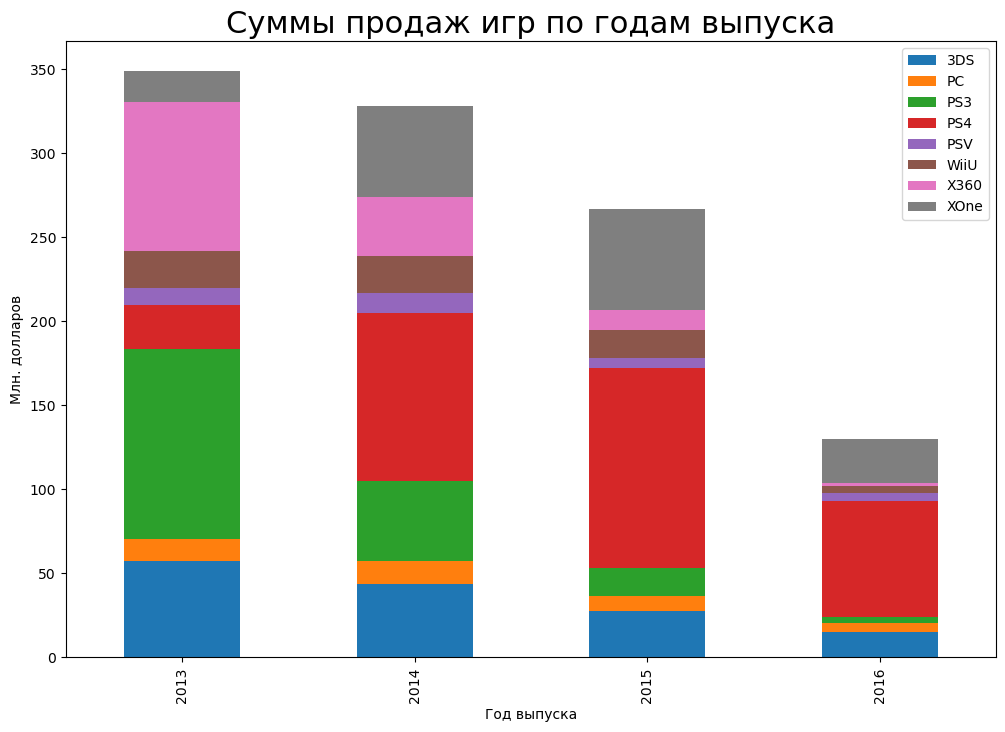

In [116]:
plat_sum.plot(kind='bar', stacked= True,figsize=(12,8))
plt.title('Суммы продаж игр по годам выпуска', fontsize=22)
plt.xlabel('Год выпуска')
plt.ylabel('Млн. долларов')
plt.legend()
plt.show()

А продажи каждый год падают....

#### Какие платформы лидируют по продажам?

В лидерах по продажам за весь выбранный период:

In [117]:
sum_top = act_data.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False)
sum_top
#.plot(kind='pie', y='value_column')

sum_sales
platform           
PS4          314.14
PS3          181.43
XOne         159.32
3DS          143.72
X360         136.80
WiiU          64.63
PC            40.06
PSV           33.25

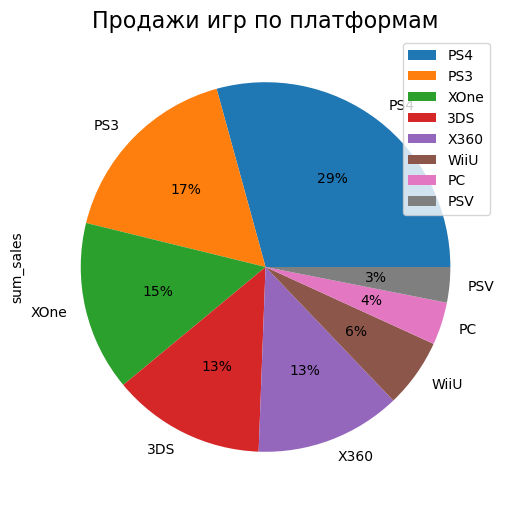

In [118]:
sum_top.plot(kind='pie', y='sum_sales', autopct='%1.0f%%', figsize=(6,6))
plt.title('Продажи игр по платформам', fontsize=16)
#plt.xlabel('Платформы')
#plt.ylabel('Млн. долларов')
#plt.legend()
plt.show()

**Выводы:**<br />
В лидерах - платформы от Sony, причём продажи игр для Playstation 4 уже в 1,7 раза превосходят продажи Playstation 3.<br />
В группе преследования - платформы XBox от Microsoft (из которых новая Xbox One уже немного обходит предшественницу XBox 360) и вклинившаяся между ними мобильная консоль Nintendo 3DS. Вторая мобильная консоль - PS Vita - на последнем месте.

#### Какие платформы растут или падают по продажам? 

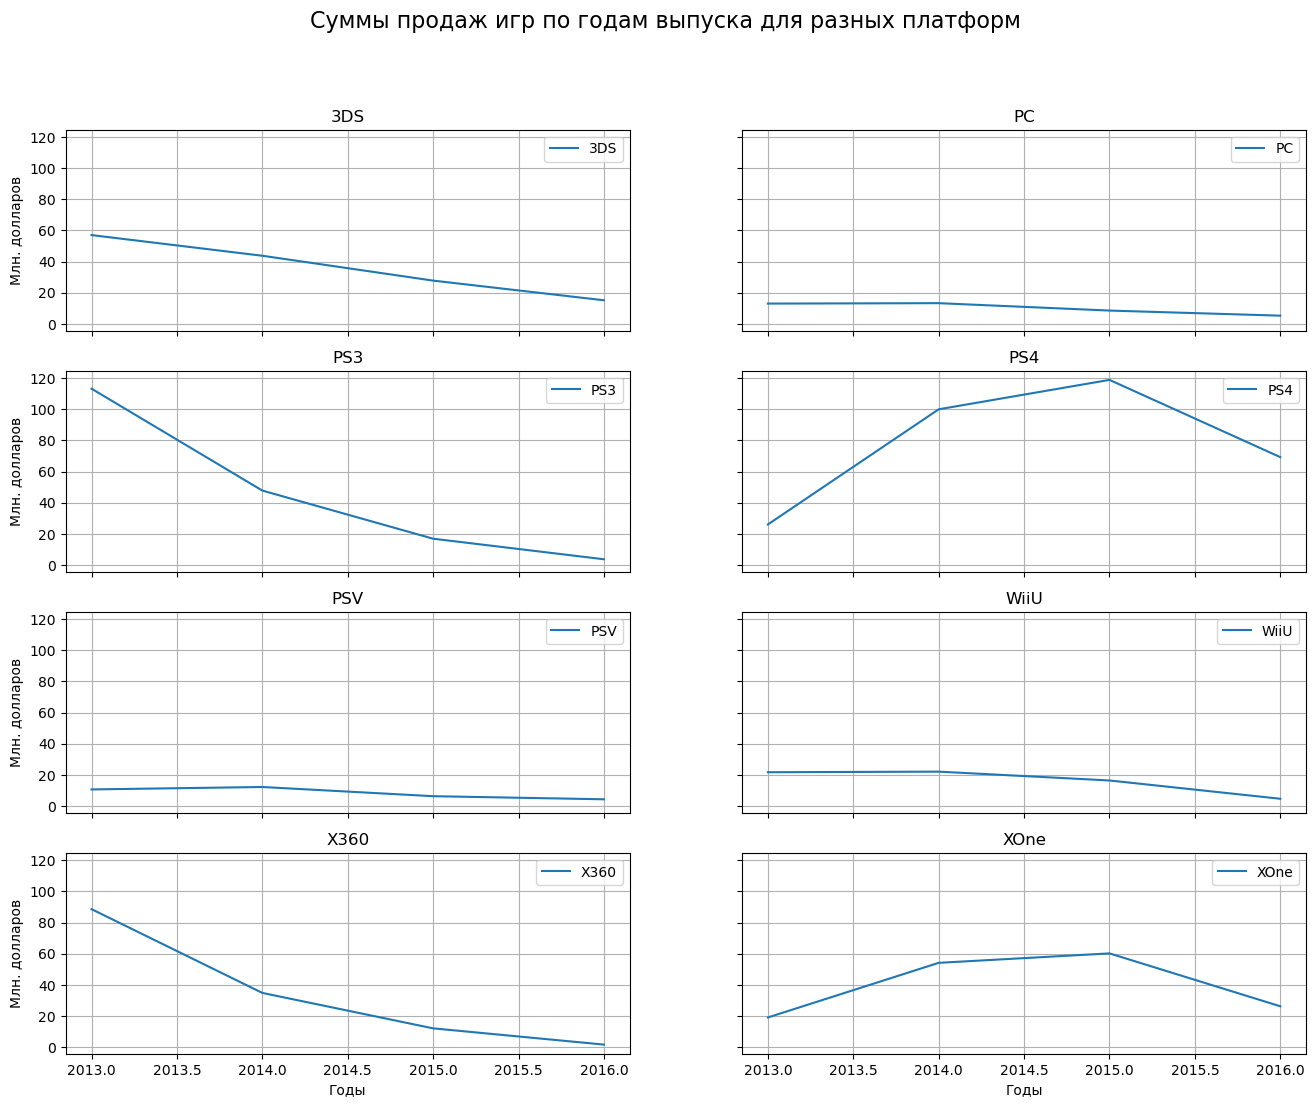

In [119]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,12),sharex='all',sharey='all')

n = 0

for axx in axes.flat:
    axx.set(title=cols[n])#, xticks=[], yticks=[])
    plat_sum.plot(kind='line',ax=axx, y=cols[n], grid=True,  stacked=True, xlabel='Годы', ylabel='Млн. долларов')
    n += 1
fig.suptitle('Суммы продаж игр по годам выпуска для разных платформ', fontsize=16)   
plt.show()

**Выводы:**<br />
Если не рассматривать данные 2016 года (по условиям задачи, он еще не окончился, а предновогодние продажи могут сильно изменить статистику), то 
- pастут продажи у Playstation 4 и Xbox One, 
- более-менее стабильные (стабильно-низкие) показатели у PC,  Playstation Vita  и Wii U, 
- продажи падают у   Playstation 3, XBox 360 и Nintendo 3DS. 

#### Выберите несколько потенциально прибыльных платформ.

Тройку лидеров составляют новые платформы  Playstation 4, Xbox One и мобильная консоль Nintendo 3DS, и их можно считать потенциально прибыльными.<br />
Консоли предыдущего поколения Playstation 3 и XBox 360 начинают терять свои позиции.<br />
Платформа PC очень популярна у игроков, под нее выходит много игр, но она имеет низкие финансовые показатели по следующим причинам:<br />
1. Игры для PC чаще покупаются на онлайн платформах.
2. Игры для PC стоят в 3-4 раза дешевле тех же самых игр для приставок.
3. Пиратские версии игр для PC проще скачать и установить.
<br /><br />
Но из-за постоянности платформы, очень долгого жизненного цикла, совместимости с играми, вышедшими значительно раньше и большей аудитории, чем у приставок, считаю целесообразным также считать PC одной из потенциально прибыльных платформ.

#### «Ящик с усами» по глобальным продажам игр в разбивке по платформам.

In [120]:
plat_names = act_data['platform'].unique()
plat_medians = {}
plat_count = []
for plat in plat_names:
    if plat != 'year_of_release':
        plat_medians[plat] = act_data.query('platform == @plat')['sum_sales'].median()
        plat_count.append(act_data.query('platform == @plat')['sum_sales'].count())

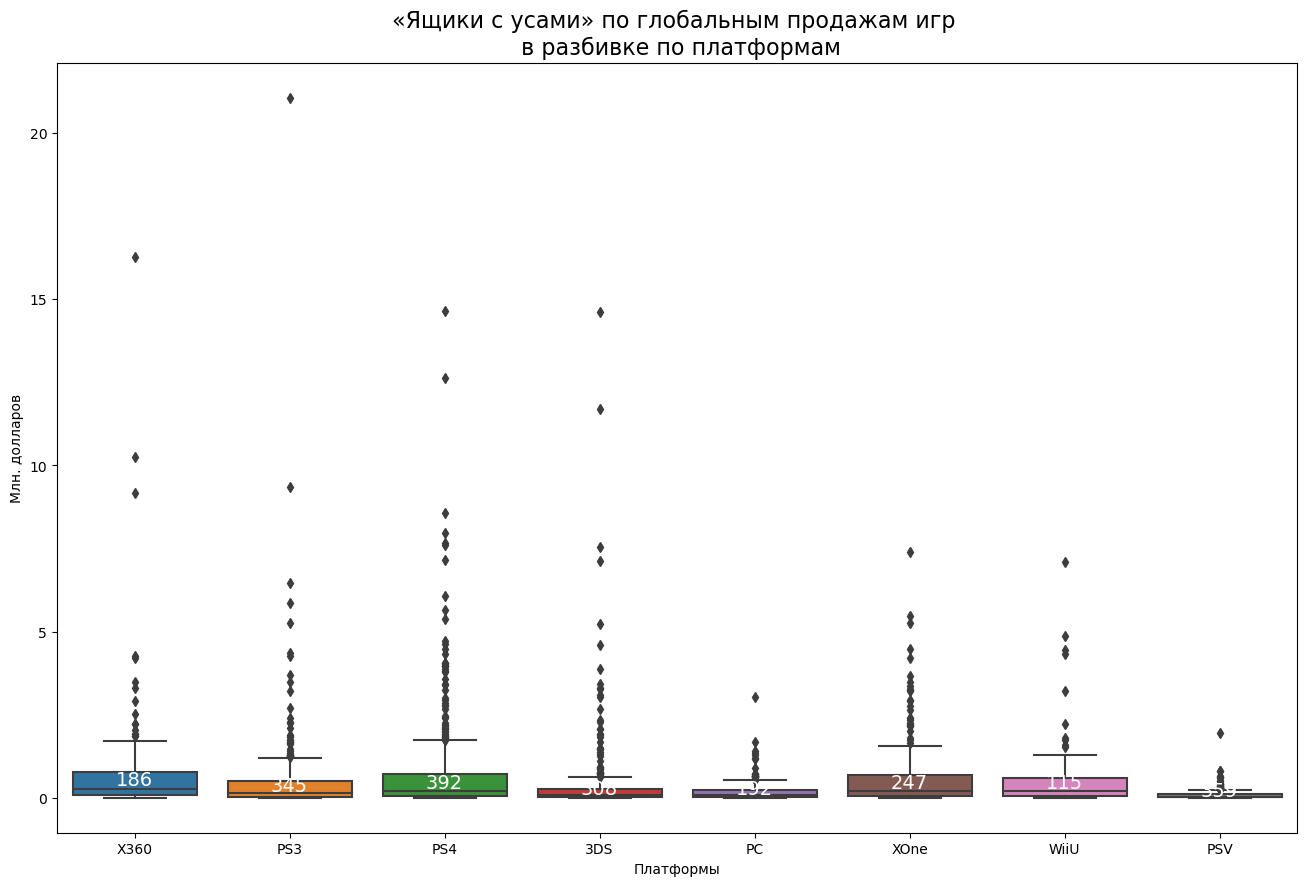

In [121]:
plt.figure(figsize=(16,10))
sns.boxplot(x="platform", y="sum_sales", data=act_data, notch=False)

for i in range(len(plat_names)):
    plt.text(i, plat_medians[plat_names[i]]*1.4, str(plat_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по глобальным продажам игр \n в разбивке по платформам', fontsize=16)
plt.xlabel('Платформы')
plt.ylabel('Млн. долларов')
plt.show()

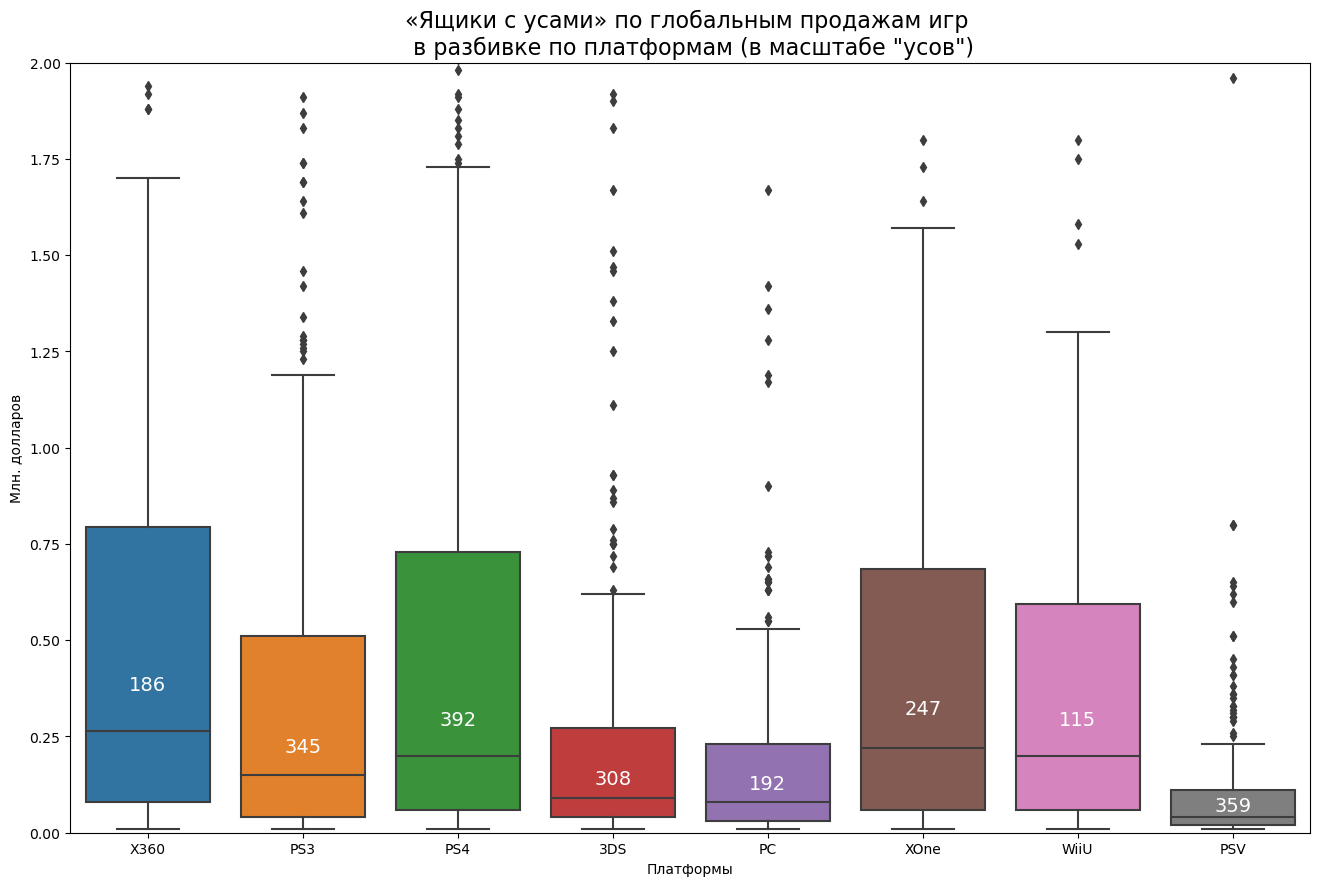

In [122]:
plt.figure(figsize=(16,10))
sns.boxplot(x="platform", y="sum_sales", data=act_data, notch=False)

for i in range(len(plat_names)):
    plt.text(i, plat_medians[plat_names[i]]*1.4, str(plat_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по глобальным продажам игр \n в разбивке по платформам (в масштабе "усов")', fontsize=16)
plt.ylim(0, 2)
plt.xlabel('Платформы')
plt.ylabel('Млн. долларов')
plt.show()

Цифра на "ящике" - количество игр, выпущенных для данной платформы

In [123]:
data_describe = pd.DataFrame(columns=['platform','count','mean','std','min','25%','50%','75%','max'])
for plat in plat_names:
    desc = act_data.query('platform ==@plat')['sum_sales'].describe().to_dict()
    desc['platform'] = plat
    data_describe = data_describe.append(desc, ignore_index=True)
data_describe

platform  count  mean  std  min  25%  50%  75%   max
0     X360 186.00  0.74 1.66 0.01 0.08 0.27 0.80 16.27
1      PS3 345.00  0.53 1.45 0.01 0.04 0.15 0.51 21.05
2      PS4 392.00  0.80 1.61 0.01 0.06 0.20 0.73 14.63
3      3DS 308.00  0.47 1.37 0.01 0.04 0.09 0.27 14.60
4       PC 192.00  0.21 0.35 0.01 0.03 0.08 0.23  3.05
5     XOne 247.00  0.65 1.04 0.01 0.06 0.22 0.69  7.39
6     WiiU 115.00  0.56 1.04 0.01 0.06 0.20 0.60  7.09
7      PSV 359.00  0.09 0.15 0.01 0.02 0.04 0.11  1.96

**Выводы:**
1. Наибольшую прибыль чаще всего приносят игры для станционарных консолей, при этом игры для PlayStation 3 приносят меньше прибыли - пользователи уже стали активно перебираться на PlayStation 4. 
3. Игры для мобильных консолей приносят меньше прибыли, чем стационарные. Из них лидирует Nintendo 3DS, а PlayStation Vita - опять явный аутсайдер.
4. Игры для PC обычно приносят в 2-3 раза меньше, чем игры для стационарных конслей, поскольку, как говорилось выше, сами игры для PC дешевле в 2-3 раза.

### Влияние на продажи отзывов пользователей и критиков для разных платформ

#### Для платформы PlayStation 4 

In [124]:
data_corr = act_data.query('platform == "PS4"')[['name','critic_score','user_score','sum_score','na_sales','eu_sales','jp_sales','other_sales','sum_sales']]
data_corr.head()

name  critic_score  user_score  sum_score  \
9480       Call of Duty: Black Ops 3           NaN         NaN        NaN   
9481              Grand Theft Auto V         97.00        8.30      90.00   
9482                         FIFA 16         82.00        4.30      62.50   
9483    Star Wars Battlefront (2015)           NaN         NaN        NaN   
9484  Call of Duty: Advanced Warfare         83.00        5.70      70.00   

      na_sales  eu_sales  jp_sales  other_sales  sum_sales  
9480      6.03      5.86      0.36         2.38      14.63  
9481      3.96      6.31      0.38         1.97      12.62  
9482      1.12      6.12      0.06         1.28       8.58  
9483      2.99      3.49      0.22         1.28       7.98  
9484      2.81      3.48      0.14         1.23       7.66

**Диаграмма рассеивания:**

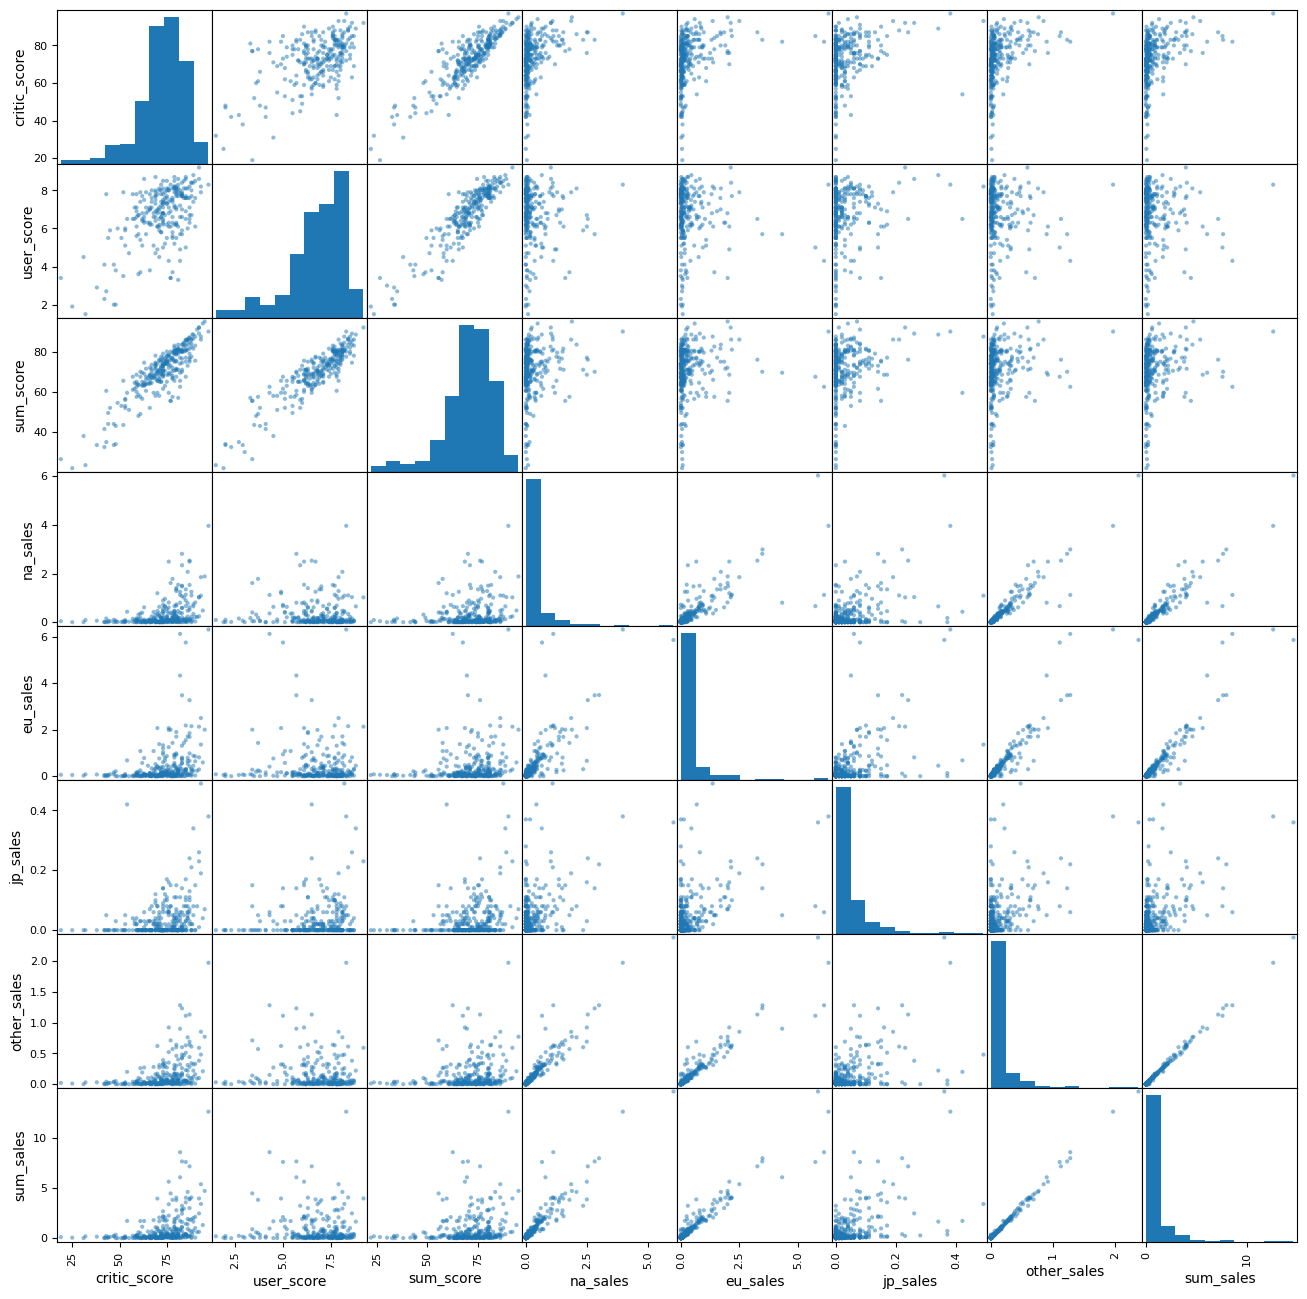

In [125]:
pd.plotting.scatter_matrix(data_corr, figsize=(16, 16)); 

**Корелляция:**

In [126]:
data_corr.corr()

critic_score  user_score  sum_score  na_sales  eu_sales  \
critic_score          1.00        0.56       0.88      0.40      0.33   
user_score            0.56        1.00       0.90     -0.02     -0.05   
sum_score             0.88        0.90       1.00      0.20      0.15   
na_sales              0.40       -0.02       0.20      1.00      0.79   
eu_sales              0.33       -0.05       0.15      0.79      1.00   
jp_sales              0.31        0.17       0.25      0.47      0.46   
other_sales           0.39       -0.04       0.19      0.94      0.94   
sum_sales             0.39       -0.03       0.19      0.93      0.96   

              jp_sales  other_sales  sum_sales  
critic_score      0.31         0.39       0.39  
user_score        0.17        -0.04      -0.03  
sum_score         0.25         0.19       0.19  
na_sales          0.47         0.94       0.93  
eu_sales          0.46         0.94       0.96  
jp_sales          1.00         0.50       0.53  
other_sales       0.50         1.00       1.00  
sum_sales         0.53         1.00       1.00

**Выводы:**
1. Есть частичная зависимость между оценками критиков и продажами игр
2. Оценки пользователей не влияют на продажи во всех регионах, за исключением Японии - там наблюдается слабая корреляция (и, при этом, небольшое уменьшение влияния критиков).

#### Для платформы XBox One

In [127]:
data_corr = act_data.query('platform == "XOne"')[['name','critic_score','user_score','sum_score','na_sales','eu_sales','jp_sales','other_sales','sum_sales']]
data_corr.head()

name  critic_score  user_score  sum_score  \
15048       Call of Duty: Black Ops 3           NaN         NaN        NaN   
15049              Grand Theft Auto V         97.00        7.90      88.00   
15050  Call of Duty: Advanced Warfare         81.00        5.40      67.50   
15051               Halo 5: Guardians         84.00        6.40      74.00   
15052                       Fallout 4         88.00        6.20      75.00   

       na_sales  eu_sales  jp_sales  other_sales  sum_sales  
15048      4.59      2.11      0.01         0.68       7.39  
15049      2.81      2.19      0.00         0.47       5.47  
15050      3.22      1.55      0.01         0.48       5.26  
15051      2.78      1.27      0.03         0.41       4.49  
15052      2.51      1.32      0.01         0.38       4.22

**Диаграмма рассеивания:**

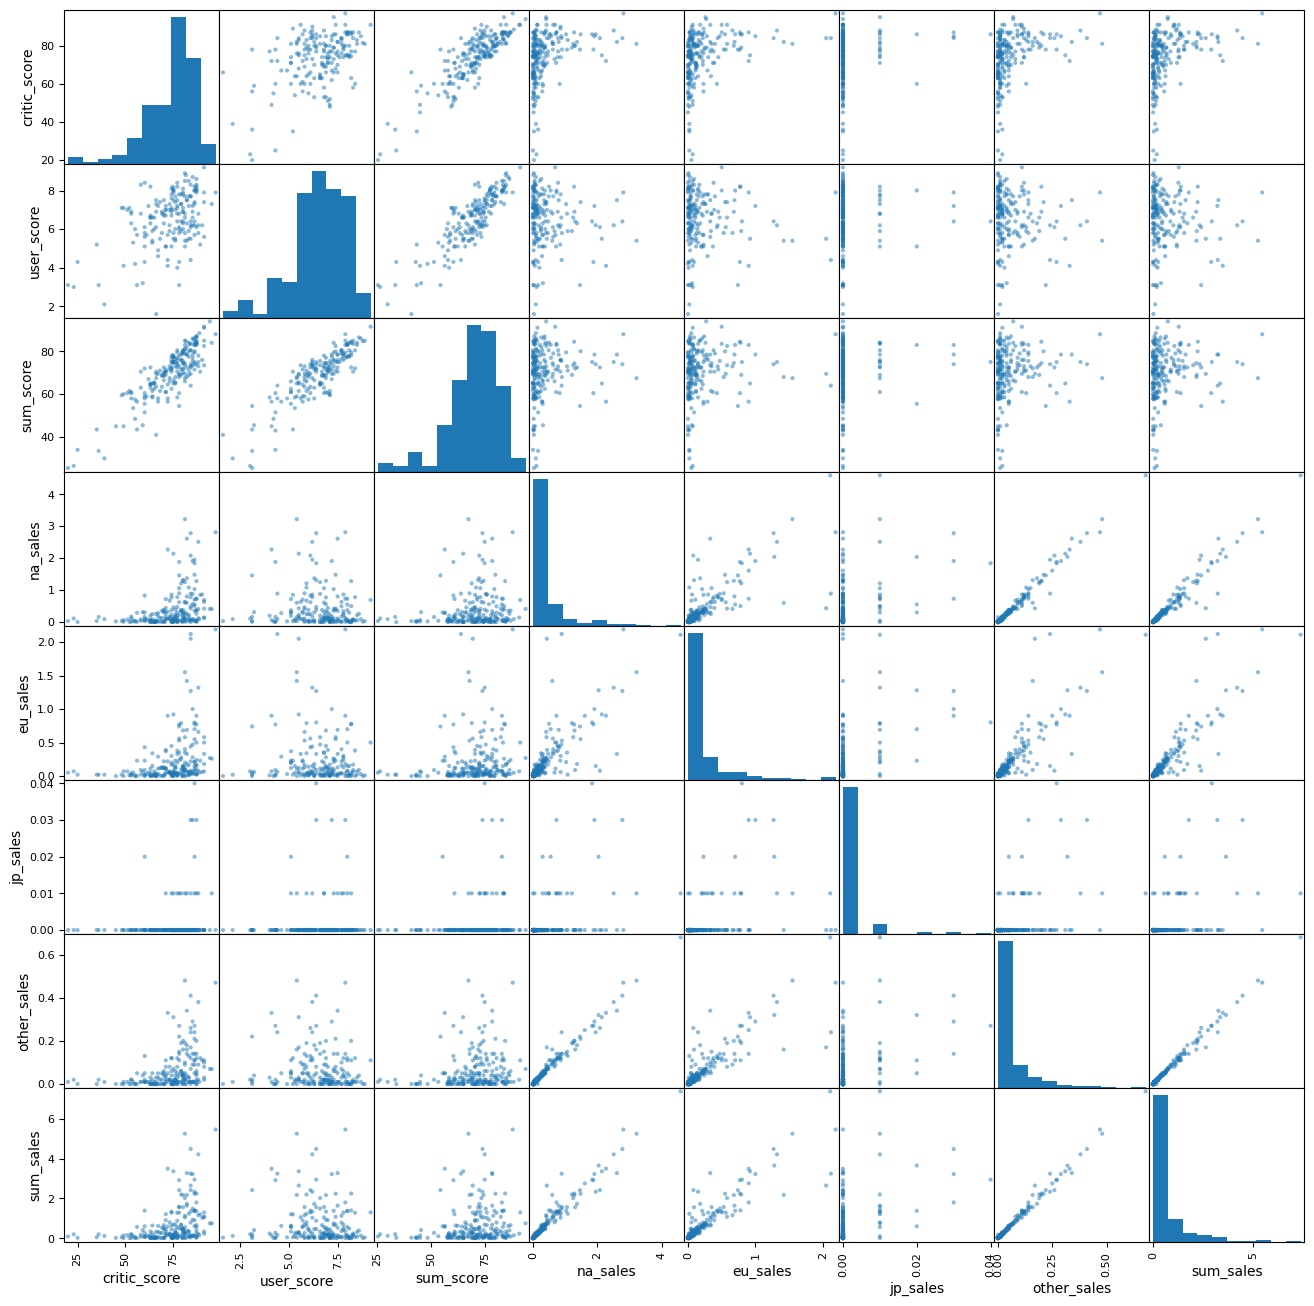

In [128]:
pd.plotting.scatter_matrix(data_corr, figsize=(16, 16)); 

**Корелляция:**

In [129]:
data_corr.corr()

critic_score  user_score  sum_score  na_sales  eu_sales  \
critic_score          1.00        0.47       0.86      0.35      0.34   
user_score            0.47        1.00       0.86     -0.07     -0.06   
sum_score             0.86        0.86       1.00      0.13      0.14   
na_sales              0.35       -0.07       0.13      1.00      0.77   
eu_sales              0.34       -0.06       0.14      0.77      1.00   
jp_sales              0.17        0.07       0.12      0.43      0.42   
other_sales           0.37       -0.07       0.15      0.99      0.85   
sum_sales             0.37       -0.07       0.15      0.97      0.90   

              jp_sales  other_sales  sum_sales  
critic_score      0.17         0.37       0.37  
user_score        0.07        -0.07      -0.07  
sum_score         0.12         0.15       0.15  
na_sales          0.43         0.99       0.97  
eu_sales          0.42         0.85       0.90  
jp_sales          1.00         0.44       0.45  
other_sales       0.44         1.00       1.00  
sum_sales         0.45         1.00       1.00

**Выводы:**
1. Есть частичная зависимость между оценками критиков и продажами игр во всех регионах, кроме Японии - там зависимость значительно слабее
2. Оценки пользователей не влияют на продажи во всех регионах

#### Для платформы Nintendo 3DS

In [130]:
data_corr = act_data.query('platform == "3DS"')[['name','critic_score','user_score','sum_score','na_sales','eu_sales','jp_sales','other_sales','sum_sales']]
data_corr.head()

name  critic_score  user_score  \
9872                        Pokemon X/Pokemon Y           NaN         NaN   
9874  Pokemon Omega Ruby/Pokemon Alpha Sapphire           NaN         NaN   
9878        Super Smash Bros. for Wii U and 3DS           NaN         NaN   
9879                           Pokemon Sun/Moon           NaN         NaN   
9880                             Tomodachi Life           NaN         NaN   

      sum_score  na_sales  eu_sales  jp_sales  other_sales  sum_sales  
9872        NaN      5.28      4.19      4.35         0.78      14.60  
9874        NaN      4.35      3.49      3.10         0.74      11.68  
9878        NaN      3.27      1.37      2.43         0.48       7.55  
9879        NaN      2.98      1.45      2.26         0.45       7.14  
9880        NaN      0.97      2.11      1.90         0.24       5.22

**Диаграмма рассеивания:**

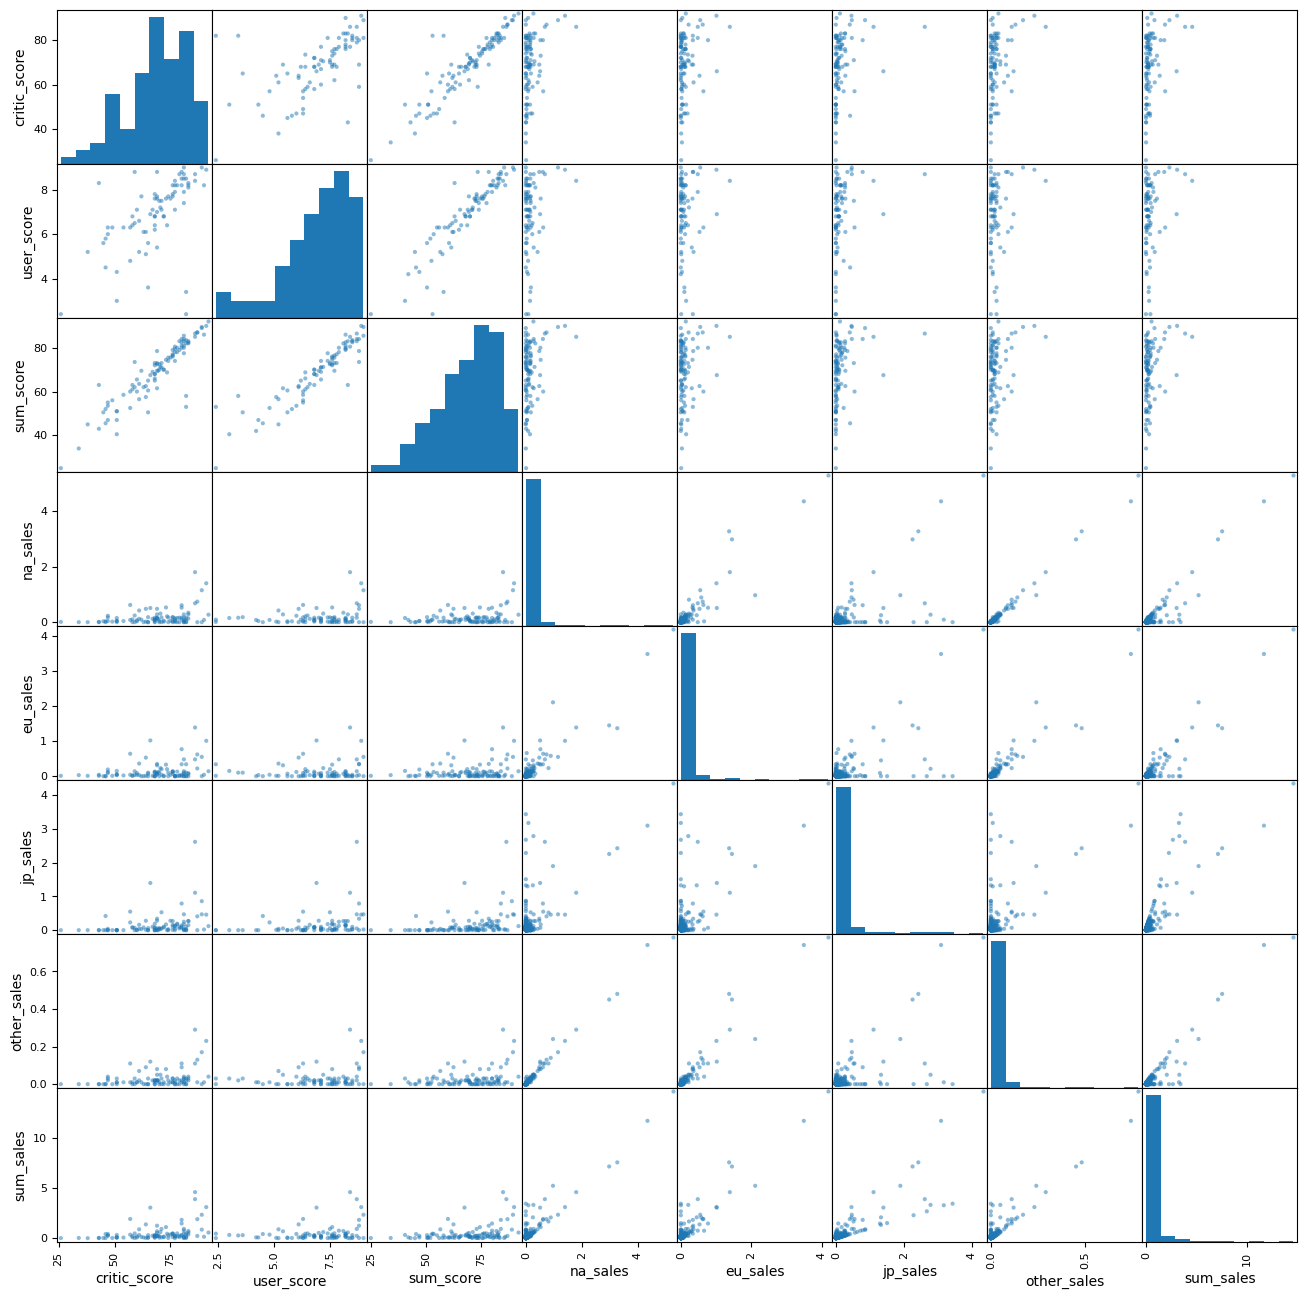

In [131]:
pd.plotting.scatter_matrix(data_corr, figsize=(16, 16)); 

**Корелляция:**

In [132]:
data_corr.corr()

critic_score  user_score  sum_score  na_sales  eu_sales  \
critic_score          1.00        0.59       0.91      0.34      0.27   
user_score            0.59        1.00       0.91      0.25      0.13   
sum_score             0.91        0.91       1.00      0.32      0.23   
na_sales              0.34        0.25       0.32      1.00      0.93   
eu_sales              0.27        0.13       0.23      0.93      1.00   
jp_sales              0.29        0.27       0.31      0.64      0.63   
other_sales           0.33        0.22       0.30      0.99      0.96   
sum_sales             0.35        0.25       0.33      0.94      0.93   

              jp_sales  other_sales  sum_sales  
critic_score      0.29         0.33       0.35  
user_score        0.27         0.22       0.25  
sum_score         0.31         0.30       0.33  
na_sales          0.64         0.99       0.94  
eu_sales          0.63         0.96       0.93  
jp_sales          1.00         0.65       0.85  
other_sales       0.65         1.00       0.95  
sum_sales         0.85         0.95       1.00

**Выводы:**
1. Есть частичная зависимость между оценками критиков и продажами игр
2. Есть несколько меньшая зависимость между оценками критиков и продажами игр
3. В Японии эти зависимости почти одинаковы

#### Для платформы PC

In [133]:
data_corr = act_data.query('platform == "PC"')[['name','critic_score','user_score','sum_score','na_sales','eu_sales','jp_sales','other_sales','sum_sales']]
data_corr.head()

name  critic_score  user_score  sum_score  \
12744                        The Sims 4         70.00        3.90      54.50   
12770  StarCraft II: Heart of the Swarm         86.00        7.90      82.50   
12779                    SimCity (2013)         64.00        2.20      43.00   
12780                     Battlefield 4         81.00        6.00      70.50   
12783                         Fallout 4         84.00        5.40      69.00   

       na_sales  eu_sales  jp_sales  other_sales  sum_sales  
12744      1.00      1.82      0.00         0.23       3.05  
12770      0.83      0.66      0.00         0.18       1.67  
12779      0.48      0.77      0.00         0.17       1.42  
12780      0.39      0.87      0.00         0.10       1.36  
12783      0.51      0.67      0.00         0.10       1.28

**Диаграмма рассеивания:**

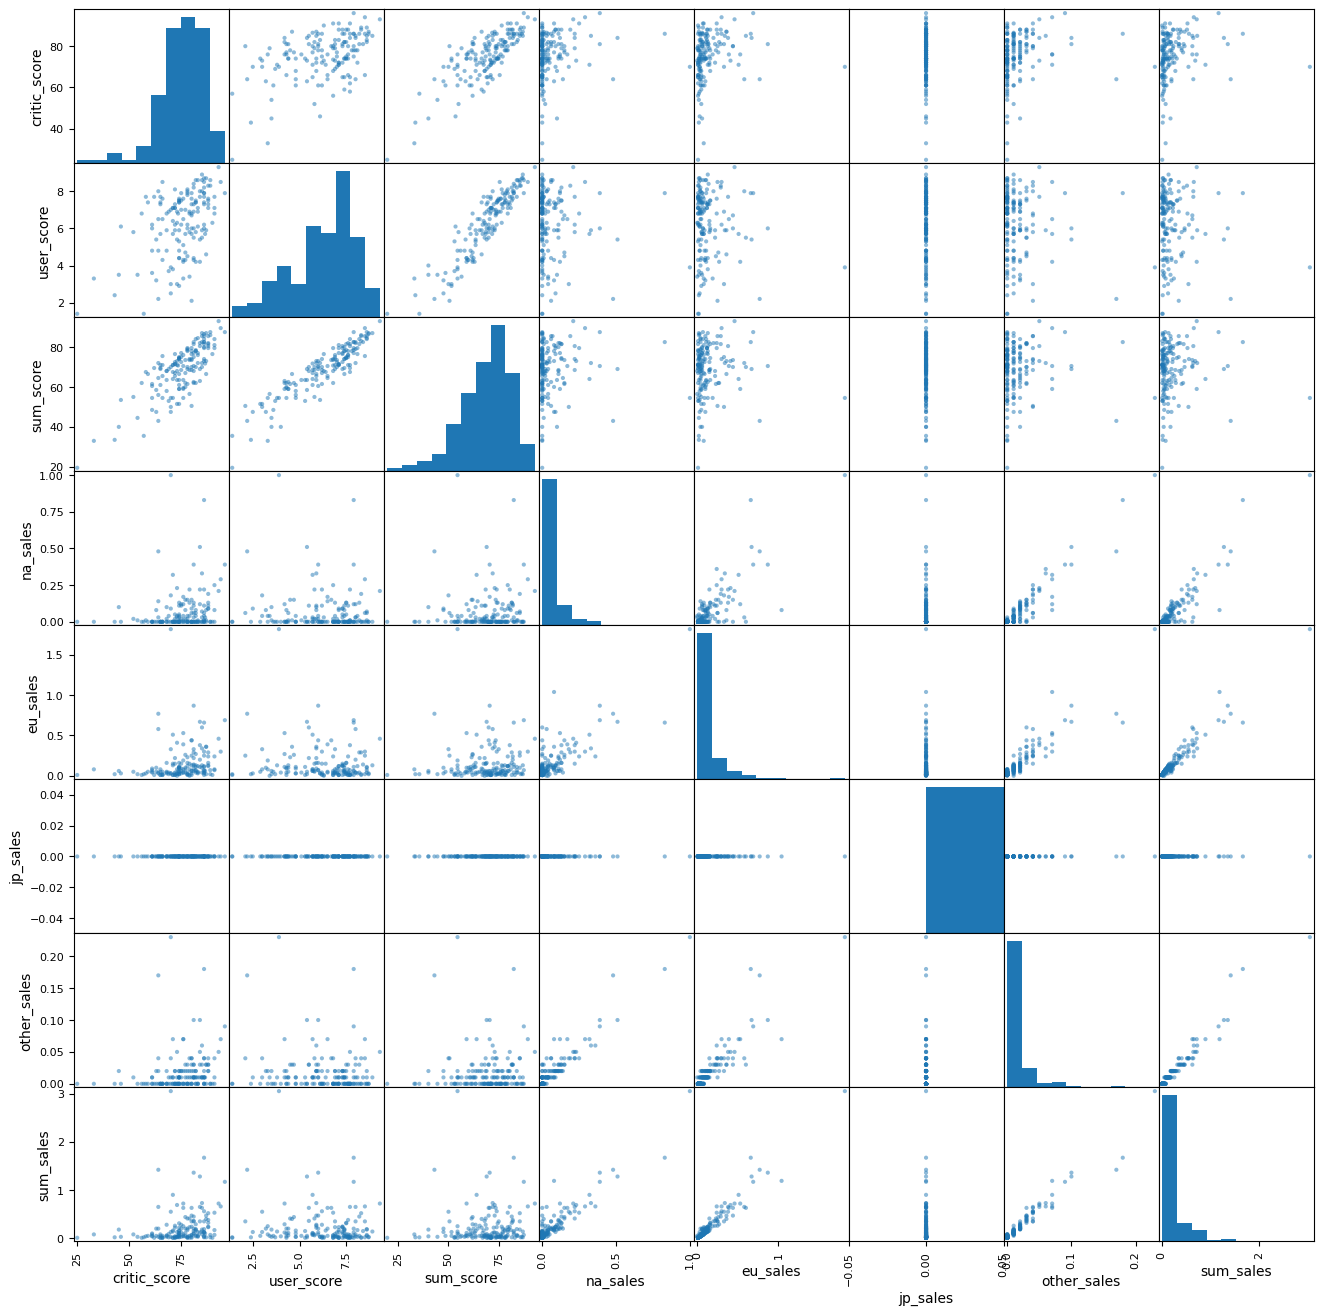

In [134]:
pd.plotting.scatter_matrix(data_corr, figsize=(16, 16)); 

**Корелляция:**

In [135]:
data_corr.corr()

critic_score  user_score  sum_score  na_sales  eu_sales  \
critic_score          1.00        0.47       0.78      0.19      0.19   
user_score            0.47        1.00       0.91     -0.05     -0.10   
sum_score             0.78        0.91       1.00      0.05      0.02   
na_sales              0.19       -0.05       0.05      1.00      0.79   
eu_sales              0.19       -0.10       0.02      0.79      1.00   
jp_sales               NaN         NaN        NaN       NaN       NaN   
other_sales           0.19       -0.11       0.02      0.94      0.90   
sum_sales             0.20       -0.09       0.03      0.92      0.97   

              jp_sales  other_sales  sum_sales  
critic_score       NaN         0.19       0.20  
user_score         NaN        -0.11      -0.09  
sum_score          NaN         0.02       0.03  
na_sales           NaN         0.94       0.92  
eu_sales           NaN         0.90       0.97  
jp_sales           NaN          NaN        NaN  
other_sales        NaN         1.00       0.97  
sum_sales          NaN         0.97       1.00

Что-то странное в Японии творится....

Посмотрим на исходные данные:

In [136]:
data.query('platform =="PC" and jp_sales > 0')

critic_score  eu_sales    genre  jp_sales  na_sales         name  \
12738         96.00      0.00  Shooter      0.09      4.03    Half-Life   
12753         96.00      0.02  Shooter      0.08      2.28  Half-Life 2   

       other_sales  plat_begin  plat_end  plat_median platform rating  \
12738         0.00        1978      2023         2010       PC      M   
12753         0.00        1978      2023         2010       PC      M   

       sum_sales  sum_score  user_score  year_of_release  
12738       4.12      93.50        9.10             1997  
12753       2.38      93.50        9.10             2004

То есть, у нас есть информация только по двум играм для PC, которые продавались в Японии:Half-Life и Half-Life 2 :)<br />
Но и они не попадают в рассматриваемый период....

**Выводы:**
1. Есть небольшая зависимость между оценками критиков и продажами игр
2. Оценки пользователей минимально влияют на продажи (причем - отрицательно!)<br />
~~3. Деревню Гадюкино смыло~~
3. В Японии не продаются игры для PC

#### Общие выводы:

1. Есть частичная зависимость между оценками критиков и продажами игр
2. Везде, кроме Японии, отсутствует зависимость между оценками пользователей и продажами игр (в Японии есть небольшая зависимость).
3. В Японии не продаются игры для PC

### Распределение игр по жанрам

#### По количеству игр:

In [137]:
data_genre = act_data.pivot_table(index='genre', values='sum_sales', aggfunc=['count','sum'])
data_genre.columns = ['count','sum']
data_genre.sort_values(by='count', ascending=False)

count    sum
genre                     
Action          747 318.32
Role-Playing    287 145.15
Adventure       211  22.81
Sports          205 148.98
Shooter         188 233.05
Misc            139  55.51
Racing           86  39.98
Fighting         79  35.29
Platform         70  39.69
Simulation       61  21.60
Strategy         54   9.80
Puzzle           17   3.17

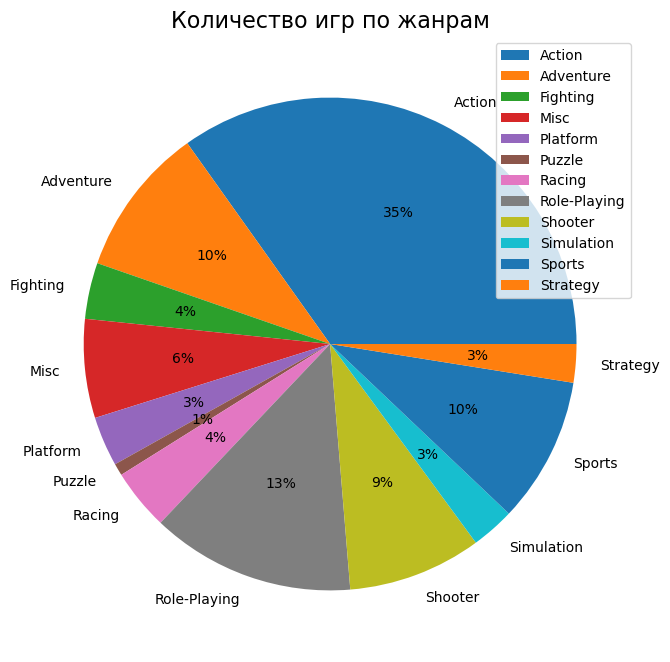

In [138]:
data_genre.plot(kind='pie', y='count', autopct='%1.0f%%', figsize=(8,8))
plt.title('Количество игр по жанрам', fontsize=16)
plt.ylabel('')
plt.legend()
plt.show()

Больше всего игр выходит в жанрах Action.<br /> 
В группе преследования  - РПГ, приключения, спортивные симуляторы и шутеры.<br /> 
Головоломки  безнадежно проигрывают.

#### По прибыли:

In [139]:
data_genre.sort_values(by='sum', ascending=False)

count    sum
genre                     
Action          747 318.32
Shooter         188 233.05
Sports          205 148.98
Role-Playing    287 145.15
Misc            139  55.51
Racing           86  39.98
Platform         70  39.69
Fighting         79  35.29
Adventure       211  22.81
Simulation       61  21.60
Strategy         54   9.80
Puzzle           17   3.17

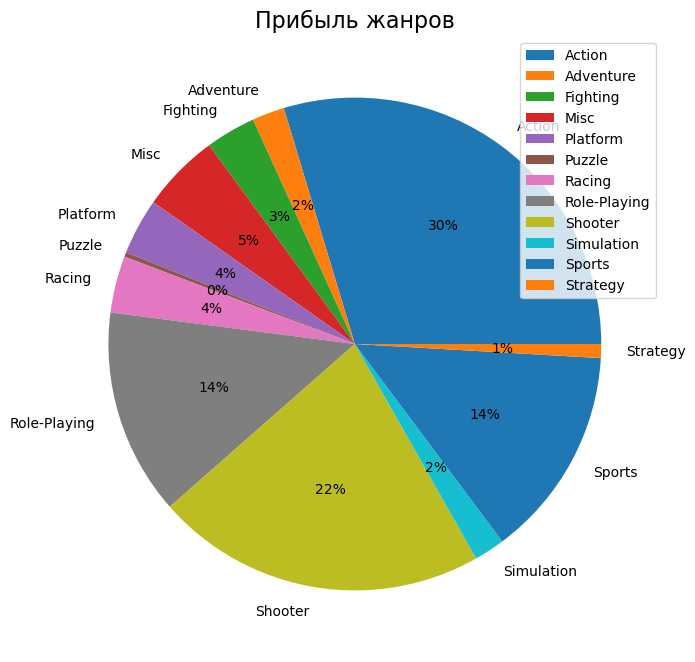

In [140]:
data_genre.plot(kind='pie', y='sum', autopct='%1.0f%%', figsize=(8,8))
plt.title('Прибыль жанров', fontsize=16)
plt.ylabel('')
plt.legend()
plt.show()

Больше всего прибыли - опять  у Action.<br />
На втором месте - шутеры.<br />
Третье делят спортивные симуляторы и РПГ.<br /> 
Меньше всего прибыль - у головоломок.

#### Расчитаем среднюю прибыль на одну игру по жанрам:

In [141]:
data_genre['per_genre'] = data_genre['sum']/data_genre['count']
data_genre.sort_values(by='per_genre', ascending=False)

count    sum  per_genre
genre                                
Shooter         188 233.05       1.24
Sports          205 148.98       0.73
Platform         70  39.69       0.57
Role-Playing    287 145.15       0.51
Racing           86  39.98       0.46
Fighting         79  35.29       0.45
Action          747 318.32       0.43
Misc            139  55.51       0.40
Simulation       61  21.60       0.35
Puzzle           17   3.17       0.19
Strategy         54   9.80       0.18
Adventure       211  22.81       0.11

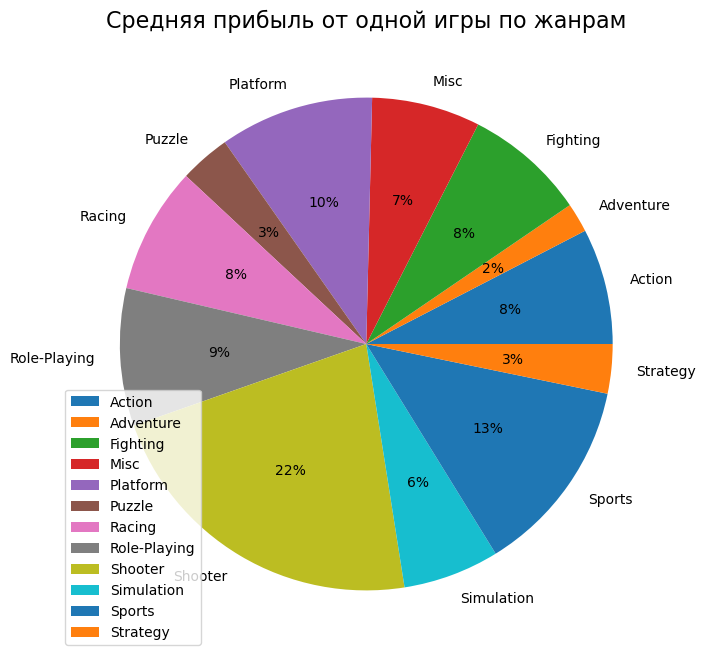

In [142]:
data_genre.plot(kind='pie', y='per_genre', autopct='%1.0f%%', figsize=(8,8))
plt.title('Средняя прибыль от одной игры по жанрам', fontsize=16)
plt.ylabel('')
plt.legend()
plt.show()

И тут шутеры вырываются вперед с заметным отрывом. 
А на втором месте - спортивные симуляторы, платформенные игры.
Третье у - платформенных игр.
Лидер двух предыдущих рейтингов Action	- на 7 месте!

### Итоги исследовательского анализа данных:

1. На момент исследования в продаже присутствуют игры для 8 платформ:
- стационарных: 
    - Sony PlayStation 3;
    - Sony PlayStation 4;
    - Microsoft ХBox 360;
    - Microsoft ХBox One;
    - Nintendo Wii U;
- мобильных:
    - Sony PS Vita;
    - Nintendo 3DS
- для персонального компьютера (PC)

2. Актуальным сожно считать период, в который все эти платформы существуют, то есть с 2013 по 2016г.<br /><br />

3. Больше всего игр (по количеству, за весь период наблюдений) было выпущено для платформ:
- за весь период наблюдений:
    - Sony PlayStation 2 - 2161;
    - Nintendo DS - 2151;
    - Sony PlayStation 3 - 1329;
    - Nintendo Wii U - 1320;
    - Microsoft ХBox 360- 1262;
- за актуальный период:
    - Sony PlayStation 4 - 392;
    - Sony PS Vita - 359;
    - Sony PlayStation 3 - 345;
    - Nintendo 3DS - 308;
    - Microsoft ХBox One - 247.

4. Наибольшие суммы продаж (в млн. долларов) у игр для платформ:
- за весь период наблюдений:
    - Sony PlayStation 2 - 1 255.77 
    - Microsoft ХBox 360 - 971.42
    - Sony PlayStation 3 - 939.16;
    - Nintendo Wii U - 907.51;
    - Nintendo DS - 806.12;
- за актуальный период:
    - Sony PlayStation 4 - 314.14;
    - Sony PlayStation 3 - 181.43;
    - Microsoft ХBox One - 159.32;
    - Nintendo 3DS - 143.72;    
    - Microsoft ХBox 360 - 136.80
    
5. Обычно в год появляется от 0 до 2 игровых платформ, срок жизни которых обычно равен 6-12 лет. Исключением является платформа PC, которой на момент исследования 46 лет.<br /><br />

6. Если не рассматривать данные 2016 года (по условиям задачи, он еще не окончился, а предновогодние продажи могут сильно изменить статистику), то 
- pастут продажи у Playstation 4 и Xbox One, 
- более-менее стабильные (стабильно-низкие) показатели у PC,  Playstation Vita  и Wii U, 
- продажи падают у   Playstation 3, XBox 360 и Nintendo 3DS. 

7. Потенциально выгодными являются Sony PlayStation 4, Microsoft ХBox One и Nintendo 3DS, а также (из-за принципиального отличия) - PC<br /><br />

8. Оценка диаграмы размаха данных о доходах игр:
- Наибольшую прибыль чаще всего приносят игры для станционарных консолей, при этом игры для PlayStation 3 приносят меньше прибыли - пользователи уже стали активно перебираться на PlayStation 4. 
- Игры для мобильных консолей приносят меньше прибыли, чем стационарные. Из них лидирует Nintendo 3DS, а PlayStation Vita - опять явный аутсайдер.
- Игры для PC обычно приносят в 2-3 раза меньше, чем игры для стационарных конслей, поскольку, как говорилось выше, сами игры для PC дешевле в 2-3 раза.

9. Влияние на продажи отзывов пользователей и критиков для разных платформ:
- PlayStation 4:
    - Есть частичная зависимость между оценками критиков и продажами игр.
    - Оценки пользователей не влияют на продажи во всех регионах, за исключением Японии - там наблюдается слабая корреляция (и, при этом, небольшое уменьшение влияния критиков).
- XBox One:
    - Есть частичная зависимость между оценками критиков и продажами игр во всех регионах, кроме Японии - там зависимость значительно слабее.
    - Оценки пользователей не влияют на продажи во всех регионах.
- Nintendo 3DS:
    - Есть частичная зависимость между оценками критиков и продажами игр.
    - Есть несколько меньшая зависимость между оценками критиков и продажами игр.
    - В Японии эти зависимости почти одинаковы.
- PC:
    - Есть небольшая зависимость между оценками критиков и продажами игр
    - Оценки пользователей минимально влияют на продажи (причем - отрицательно!)
    - В Японии не продаются игры для PC

10. Распределение игр по жанрам:
- Топ5 по количеству выпущенных игр (в порядке убывания):
    - Экшен (с большим отрывом)
    - РПГ
    - Приключения
    - Спортивные симуляторы
    - Шутеры.
- Топ5 по суммам продаж (в порядке убывания):
    - Экшен
    - Шутеры
    - Спортивные симуляторы
    - РПГ
    - Игры смешанного жанра
- Топ5 по средней сумме продаж с одной игры (в порядке убывания):
    - Шутеры (с большим отрывом)
    - Спортивные симуляторы
    - Платформенные игры
    - РПГ
    - Автосимуляторы.

## **Портрет пользователя каждого региона**

### Северная Америка

#### Самые популярные платформы (топ-5)

In [143]:
na_top5 = act_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()
na_top5
#.plot(kind='pie', y='value_column')

na_sales
platform          
PS4         108.74
XOne         93.12
X360         81.66
PS3          63.50
3DS          38.58

По вендерам:

In [144]:
na_top5['vendor']=['SONY','Microsoft','Microsoft','SONY','Nintendo']
na_top5

na_sales     vendor
platform                     
PS4         108.74       SONY
XOne         93.12  Microsoft
X360         81.66  Microsoft
PS3          63.50       SONY
3DS          38.58   Nintendo

In [145]:
na_top5.pivot_table(index='vendor', values='na_sales', aggfunc='sum')

na_sales
vendor             
Microsoft    174.78
Nintendo      38.58
SONY         172.24

По типу:

In [146]:
na_top5['type']=['Стационарная','Стационарная','Стационарная','Стационарная','Мобильная']
na_top5

na_sales     vendor          type
platform                                   
PS4         108.74       SONY  Стационарная
XOne         93.12  Microsoft  Стационарная
X360         81.66  Microsoft  Стационарная
PS3          63.50       SONY  Стационарная
3DS          38.58   Nintendo     Мобильная

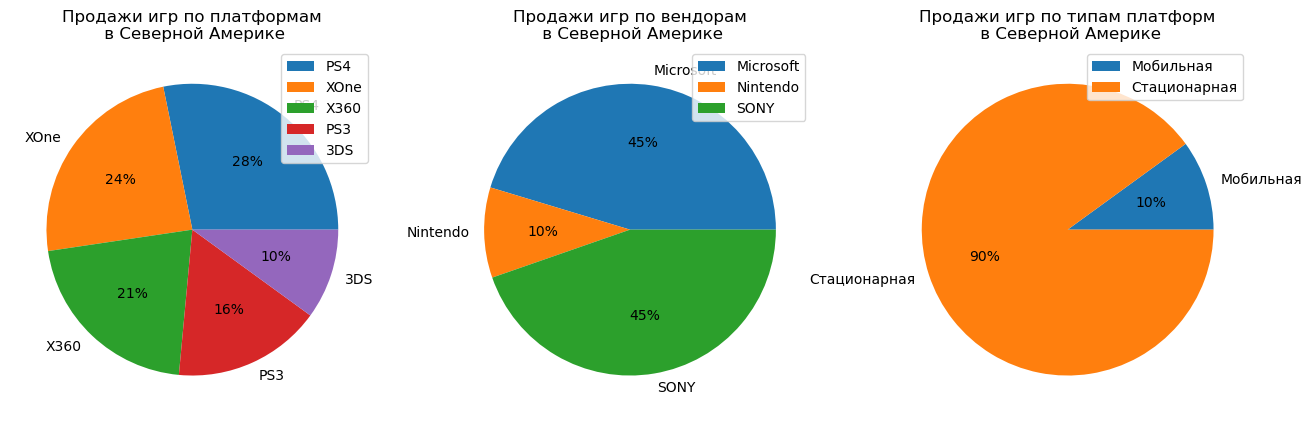

In [147]:
fig = plt.figure(figsize=(16,8))
ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)
ax_1.set(title = 'Продажи игр по платформам\n в Северной Америке', xticks=[], yticks=[])
ax_2.set(title = 'Продажи игр по вендорам\n в Северной Америке', xticks=[], yticks=[])
ax_3.set(title = 'Продажи игр по типам платформ\n в Северной Америке', xticks=[], yticks=[])
na_top5.plot(kind='pie', ax=ax_1, y='na_sales', autopct='%1.0f%%', ylabel='')
na_top5.pivot_table(index='vendor', values='na_sales', aggfunc='sum') \
       .plot(kind='pie', ax=ax_2, y='na_sales', autopct='%1.0f%%', ylabel='')
na_top5.pivot_table(index='type', values='na_sales', aggfunc='sum') \
       .plot(kind='pie', ax=ax_3, y='na_sales', autopct='%1.0f%%', ylabel='')
plt.show()

Рынок поровну (по 45%) делят стационарные платформы компаний Sony и Microsoft. Причем у Sony PlayStation 4 обогнала PlayStation 3 на 75%, в то время как у Microsoft ХBox One оторвалась от ХBox 360 всего на 15% <br />
Мобильные консоли представлены только Nintendo 3DS и составляют всего 10%.<br />

#### Самые популярные жанры (топ-5)

In [148]:
na_data_genre = act_data.pivot_table(index='genre', values='na_sales', aggfunc='sum') \
                .sort_values(by='na_sales', ascending=False).head()
na_data_genre

na_sales
genre                 
Action          124.43
Shooter         109.78
Sports           65.12
Role-Playing     46.51
Misc             24.00

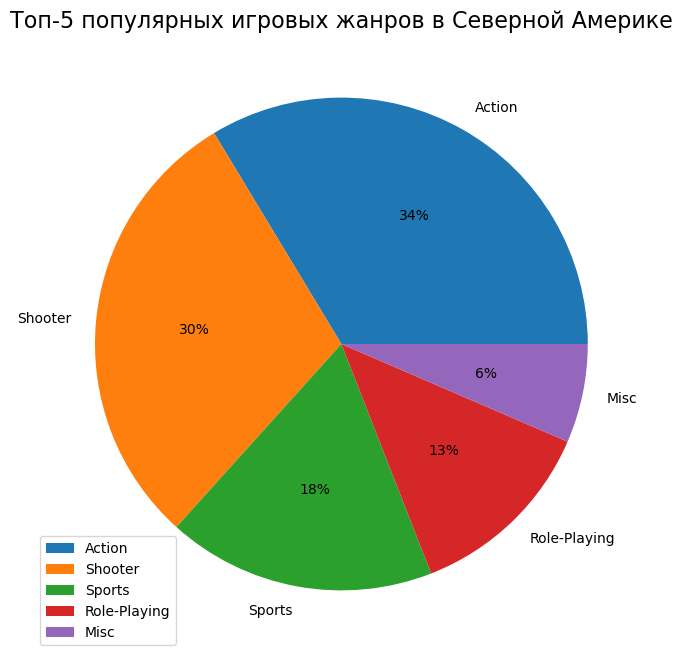

In [149]:
na_data_genre.plot(kind='pie', y='na_sales', autopct='%1.0f%%', figsize=(8,8))
plt.title('Топ-5 популярных игровых жанров в Северной Америке', fontsize=16)
plt.ylabel('')
plt.legend()
plt.show()

Наиболее популярны в регионе игры в жанрах Action и Shooter.<br /> 
Следом идут спортивные симуляторы, РПГ и игры смешанного жанра.

#### Посмотрим на стоимость игры в зависимости от рейтинга ESRB:

**Рейтинг ESRB:**
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»
<br />
Добавленный нами:
- «ND» («No data») — «Нет данных»

Рейтинги у игр в датафрейме:

In [150]:
ratings = act_data['rating'].unique()
ratings

array(['M', 'ND', 'E', 'E10+', 'T'], dtype=object)

Не будем рассматривать игры с "неустановленным" рейтингом (RP)

In [151]:
ratings = act_data.query('rating != "RP"')['rating'].unique()
ratings

array(['M', 'ND', 'E', 'E10+', 'T'], dtype=object)

Построим "ящик с усами" для рейтингов игр

In [152]:
rating_medians = {}
rating_count = []
for rat in ratings:
    rating_medians[rat] = act_data.query('rating == @rat and na_sales > 0')['na_sales'].median()
    rating_count.append(act_data.query('rating == @rat and na_sales > 0')['na_sales'].count())

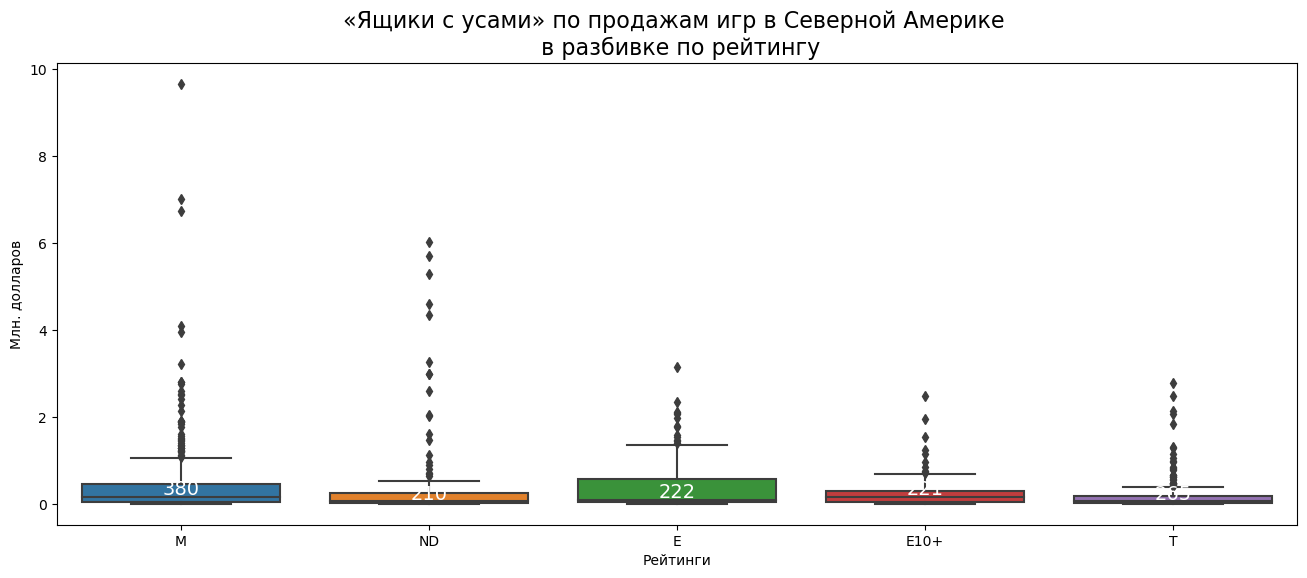

In [153]:
plt.figure(figsize=(16,6))
sns.boxplot(x="rating", y="na_sales", data=act_data.query('rating !="RP" and na_sales > 0'), notch=False)

for i in range(len(ratings)):
    plt.text(i, rating_medians[ratings[i]]*1.4, str(rating_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по продажам игр в Северной Америке \n в разбивке по рейтингу', fontsize=16)
plt.xlabel('Рейтинги')
plt.ylabel('Млн. долларов')
plt.show()

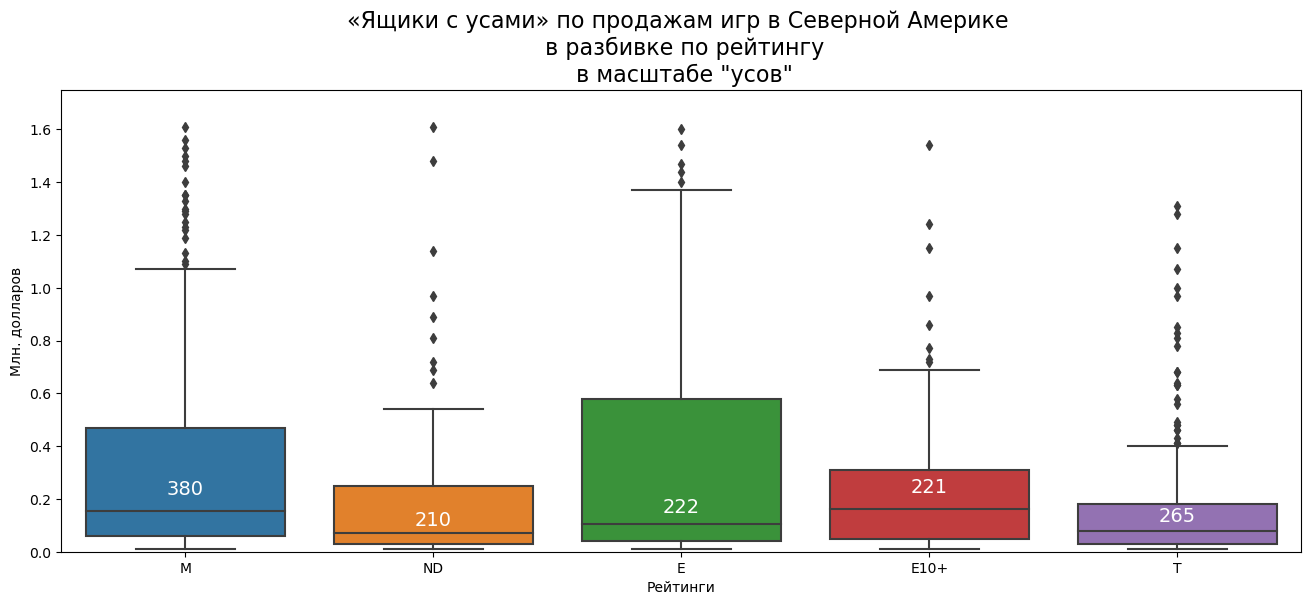

In [154]:
plt.figure(figsize=(16,6))
sns.boxplot(x="rating", y="na_sales", data=act_data.query('rating !="RP" and na_sales > 0'), notch=False)

for i in range(len(ratings)):
    plt.text(i, rating_medians[ratings[i]]*1.4, str(rating_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по продажам игр в Северной Америке \n в разбивке по рейтингу\n в масштабе "усов"', fontsize=16)
plt.ylim(0, 1.75)
plt.xlabel('Рейтинги')
plt.ylabel('Млн. долларов')
plt.show()

Цифра на "ящике" - количество игр, относящихся к данной категории

In [155]:
data_describe = pd.DataFrame(columns=['rating','count','mean','std','min','25%','50%','75%','max'])
for rat in ratings:
    desc = act_data.query('rating ==@rat and na_sales > 0')['na_sales'].describe().to_dict()
    desc['rating'] = rat
    data_describe = data_describe.append(desc, ignore_index=True)
data_describe

rating  count  mean  std  min  25%  50%  75%  max
0      M 380.00  0.46 0.90 0.01 0.06 0.15 0.47 9.66
1     ND 210.00  0.34 0.90 0.01 0.03 0.07 0.25 6.03
2      E 222.00  0.37 0.52 0.01 0.04 0.11 0.58 3.15
3   E10+ 221.00  0.23 0.29 0.01 0.05 0.16 0.31 2.49
4      T 265.00  0.20 0.36 0.01 0.03 0.08 0.18 2.78

Видно, что в данном регионе лидируют игры с рейтингом "E", за ними уверенно держатся "M"<br />
"E10+" - на 3 месте.

#### Итоговый портрет пользователя:

1. Предпочитает стационарные приставки Sony или Microsoft, причём обновил ее на новую версию или планирует это сделать в ближайшем будущем.
2. Играет в игры жанров "Action" и "Shooter", реже - в спортивные симуляторы и РПГ.
3. Предпочитает игры с рейтингами "для всех", или (несколько реже) "для взрослых".

### Европа

#### Самые популярные платформы (топ-5)

In [156]:
eu_top5 = act_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()
eu_top5
#.plot(kind='pie', y='value_column')

eu_sales
platform          
PS4         141.09
PS3          67.81
XOne         51.59
X360         42.52
3DS          30.98

По вендерам:

In [157]:
eu_top5['vendor']=['SONY','SONY','Microsoft','Microsoft','Nintendo']
eu_top5

eu_sales     vendor
platform                     
PS4         141.09       SONY
PS3          67.81       SONY
XOne         51.59  Microsoft
X360         42.52  Microsoft
3DS          30.98   Nintendo

In [158]:
eu_top5.pivot_table(index='vendor', values='eu_sales', aggfunc='sum')

eu_sales
vendor             
Microsoft     94.11
Nintendo      30.98
SONY         208.90

По типу:

In [159]:
eu_top5['type']=['Стационарная','Стационарная','Стационарная','Стационарная','Мобильная']
eu_top5

eu_sales     vendor          type
platform                                   
PS4         141.09       SONY  Стационарная
PS3          67.81       SONY  Стационарная
XOne         51.59  Microsoft  Стационарная
X360         42.52  Microsoft  Стационарная
3DS          30.98   Nintendo     Мобильная

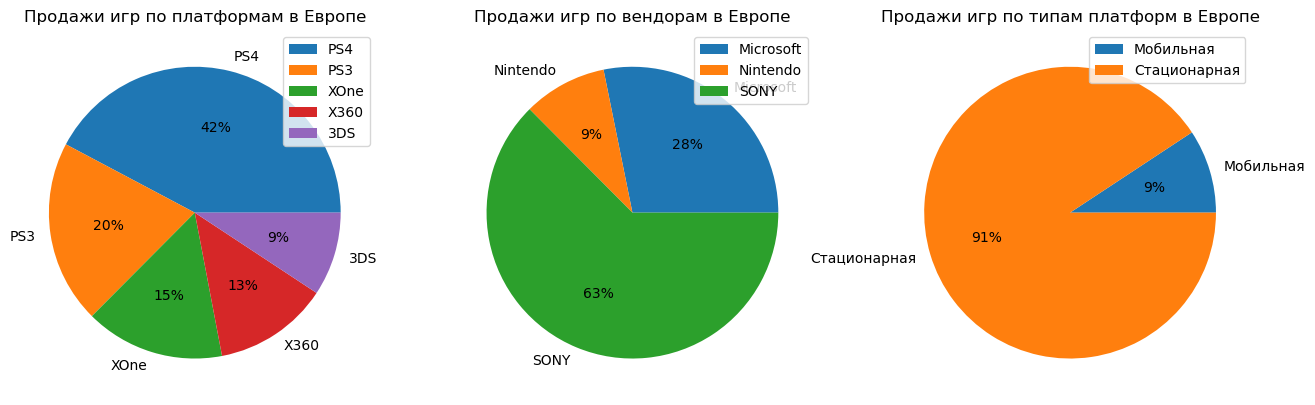

In [160]:
fig = plt.figure(figsize=(16,8))
ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)
ax_1.set(title = 'Продажи игр по платформам в Европе', xticks=[], yticks=[])
ax_2.set(title = 'Продажи игр по вендорам в Европе', xticks=[], yticks=[])
ax_3.set(title = 'Продажи игр по типам платформ в Европе', xticks=[], yticks=[])
eu_top5.plot(kind='pie', ax=ax_1, y='eu_sales', autopct='%1.0f%%', ylabel='')
eu_top5.pivot_table(index='vendor', values='eu_sales', aggfunc='sum') \
       .plot(kind='pie', ax=ax_2, y='eu_sales', autopct='%1.0f%%', ylabel='')
eu_top5.pivot_table(index='type', values='eu_sales', aggfunc='sum') \
       .plot(kind='pie', ax=ax_3, y='eu_sales', autopct='%1.0f%%', ylabel='')
plt.show()

Рынок Европы захватили  стационарные платформы Sony. Причем у Sony PlayStation 4 обогнала PlayStation 3 больше, чем в 2 раза.
На продажи игр для платформ  Microsoft ХBox One и ХBox 360 суммарно приходится всего 28%, причем доля игр для новой и старой приставки примерно одинакова. <br />
Мобильные консоли опять же представлены только Nintendo 3DS и составляют всего 9%.<br />

#### Самые популярные жанры (топ-5)

In [161]:
eu_data_genre = act_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum') \
                .sort_values(by='eu_sales', ascending=False).head()
eu_data_genre

eu_sales
genre                 
Action          117.24
Shooter          87.88
Sports           59.60
Role-Playing     37.02
Racing           20.19

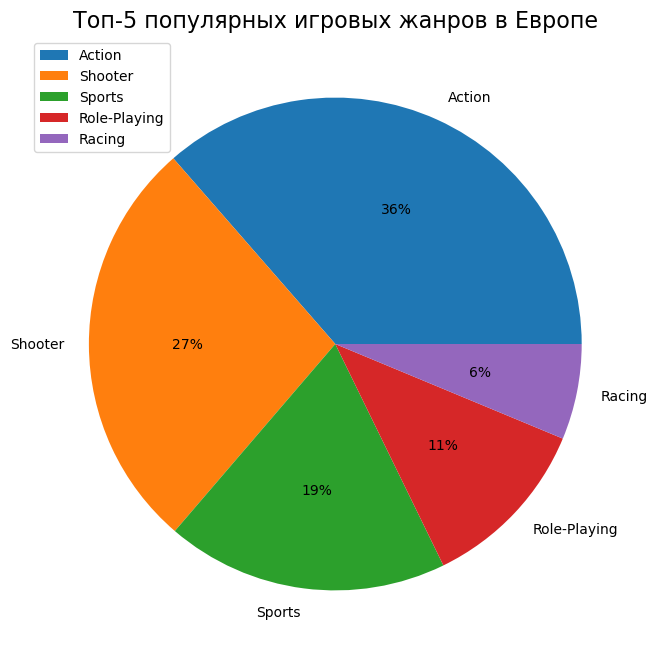

In [162]:
eu_data_genre.plot(kind='pie', y='eu_sales', autopct='%1.0f%%', figsize=(8,8))
plt.title('Топ-5 популярных игровых жанров в Европе', fontsize=16)
plt.ylabel('')
plt.legend()
plt.show()

Наиболее популярны в регионе игры в жанрах Action и Shooter.<br /> 
Следом идут спортивные симуляторы, РПГ и автогонки.

#### Посмотрим на стоимость игры в зависимости от рейтинга ESRB:

**Рейтинг ESRB:**
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»
<br />
Добавленный нами:
- «ND» («No data») — «Нет данных»

Напомним, что мы анализируем следующие рейтинги из датафрейма (не рассматриваем игры с "неустановленным" рейтингом (RP)):

In [163]:
ratings = act_data.query('rating != "RP"')['rating'].unique()
ratings

array(['M', 'ND', 'E', 'E10+', 'T'], dtype=object)

Построим "ящик с усами" для рейтингов игр

In [164]:
rating_medians = {}
rating_count = []
for rat in ratings:
    rating_medians[rat] = act_data.query('rating == @rat and eu_sales > 0')['eu_sales'].median()
    rating_count.append(act_data.query('rating == @rat and eu_sales > 0')['eu_sales'].count())

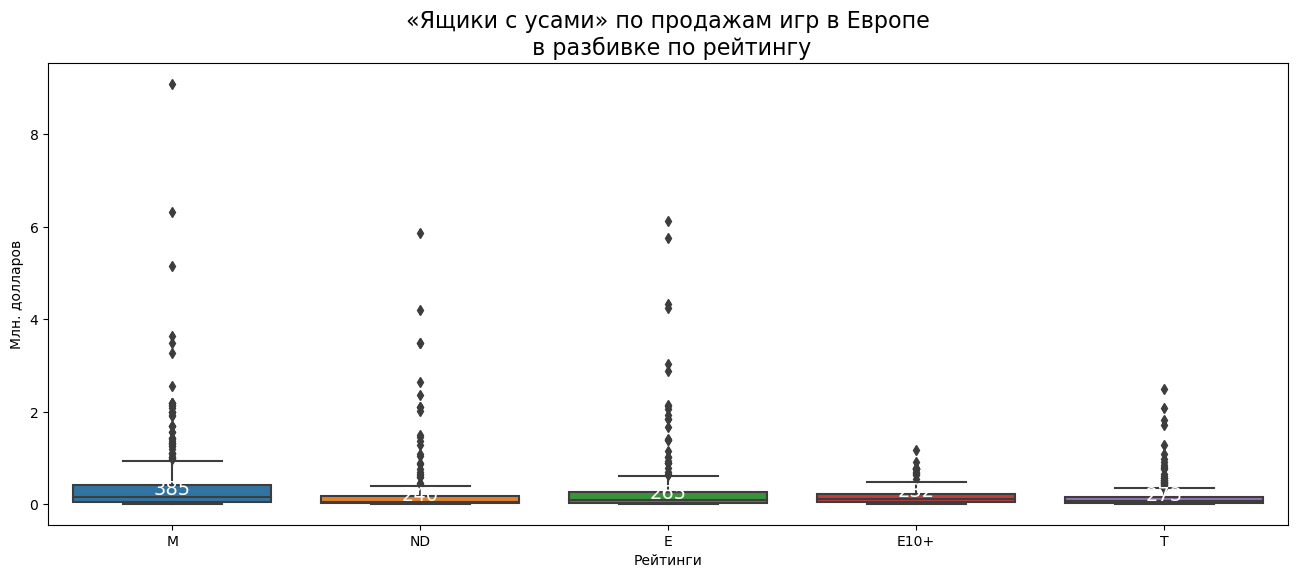

In [165]:
plt.figure(figsize=(16,6))
sns.boxplot(x="rating", y="eu_sales", data=act_data.query('rating !="RP" and eu_sales > 0'), notch=False)

for i in range(len(ratings)):
    plt.text(i, rating_medians[ratings[i]]*1.4, str(rating_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по продажам игр в Европе\n в разбивке по рейтингу', fontsize=16)
plt.xlabel('Рейтинги')
plt.ylabel('Млн. долларов')
plt.show()

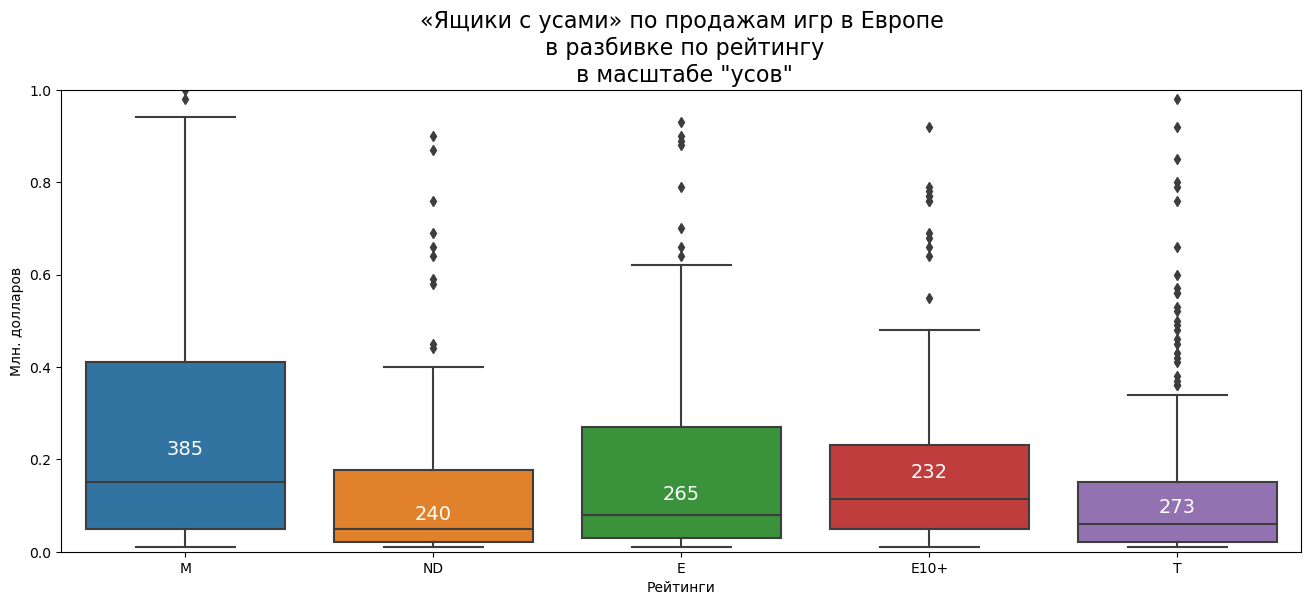

In [166]:
plt.figure(figsize=(16,6))
sns.boxplot(x="rating", y="eu_sales", data=act_data.query('rating !="RP" and eu_sales > 0'), notch=False)

for i in range(len(ratings)):
    plt.text(i, rating_medians[ratings[i]]*1.4, str(rating_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по продажам игр в Европе\n в разбивке по рейтингу\n в масштабе "усов"', fontsize=16)
plt.ylim(0, 1)
plt.xlabel('Рейтинги')
plt.ylabel('Млн. долларов')
plt.show()

Цифра на "ящике" - количество игр, относящихся к данной категории

In [167]:
data_describe = pd.DataFrame(columns=['rating','count','mean','std','min','25%','50%','75%','max'])
for rat in ratings:
    desc = act_data.query('rating ==@rat and eu_sales > 0')['eu_sales'].describe().to_dict()
    desc['rating'] = rat
    data_describe = data_describe.append(desc, ignore_index=True)
data_describe

rating  count  mean  std  min  25%  50%  75%  max
0      M 385.00  0.41 0.80 0.01 0.05 0.15 0.41 9.09
1     ND 240.00  0.25 0.66 0.01 0.02 0.05 0.18 5.86
2      E 265.00  0.32 0.75 0.01 0.03 0.08 0.27 6.12
3   E10+ 232.00  0.17 0.19 0.01 0.05 0.11 0.23 1.18
4      T 273.00  0.16 0.30 0.01 0.02 0.06 0.15 2.50

Видно, что в данном регионе игры с рейтингом "M" продаются значительно лучше остальных.<br />
Неплохо также идут игры "E", чуть хуже - "E10+".

#### Итоговый портрет пользователя:

1. Предпочитает стационарные приставки Sony, причём обновил ее на новую версию.
2. Играет в игры жанров "Action" и "Shooter", реже - в спортивные симуляторы и РПГ.
2. Предпочитает игры с рейтингом "для взрослых" или (реже) "для всех" и "для всех от 10 лет" (скорее всего, зависит от жанра игры).

<div class="alert alert-success">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Пользователи в NA и EU во многом схожи. Посмотрим, что покажет страна восходящего солнца.
</div>

### Япония

#### Самые популярные платформы (топ-5)

In [168]:
jp_top5 = act_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()
jp_top5
#.plot(kind='pie', y='value_column')

jp_sales
platform          
3DS          67.84
PS3          23.35
PSV          18.66
PS4          15.96
WiiU         10.88

По вендерам:

In [169]:
jp_top5['vendor']=['Nintendo','SONY','SONY','SONY','Nintendo']
jp_top5

jp_sales    vendor
platform                    
3DS          67.84  Nintendo
PS3          23.35      SONY
PSV          18.66      SONY
PS4          15.96      SONY
WiiU         10.88  Nintendo

По типу:

In [170]:
jp_top5['type']=['Мобильная','Стационарная','Мобильная','Стационарная','Стационарная']
jp_top5

jp_sales    vendor          type
platform                                  
3DS          67.84  Nintendo     Мобильная
PS3          23.35      SONY  Стационарная
PSV          18.66      SONY     Мобильная
PS4          15.96      SONY  Стационарная
WiiU         10.88  Nintendo  Стационарная

In [171]:
jp_top5.pivot_table(index='vendor', values='jp_sales', aggfunc='sum')

jp_sales
vendor            
Nintendo     78.72
SONY         57.97

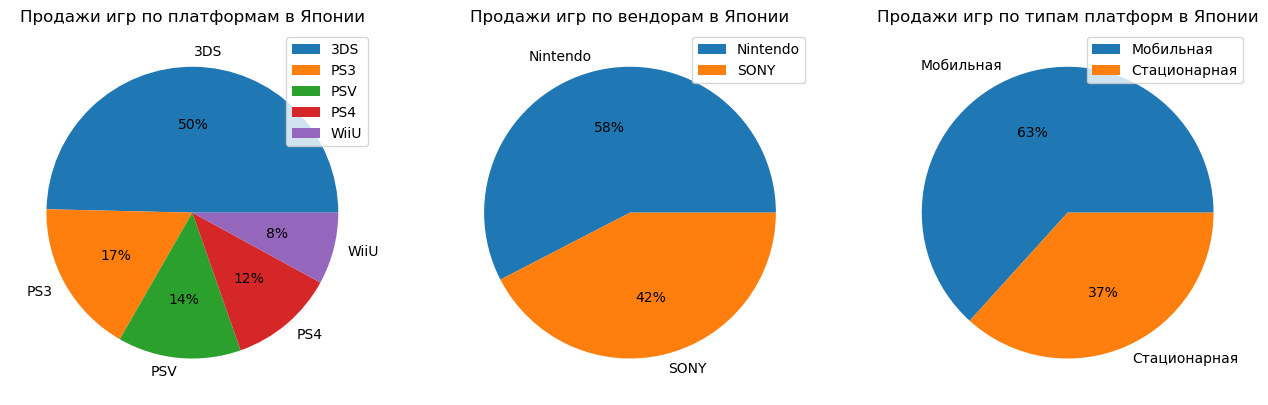

In [172]:
fig = plt.figure(figsize=(16,8))
ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)
ax_1.set(title = 'Продажи игр по платформам в Японии', xticks=[], yticks=[])
ax_2.set(title = 'Продажи игр по вендорам в Японии', xticks=[], yticks=[])
ax_3.set(title = 'Продажи игр по типам платформ в Японии', xticks=[], yticks=[])
jp_top5.plot(kind='pie', ax=ax_1, y='jp_sales', autopct='%1.0f%%', ylabel='')
jp_top5.pivot_table(index='vendor', values='jp_sales', aggfunc='sum') \
       .plot(kind='pie', ax=ax_2, y='jp_sales', autopct='%1.0f%%', ylabel='')
jp_top5.pivot_table(index='type', values='jp_sales', aggfunc='sum') \
       .plot(kind='pie', ax=ax_3, y='jp_sales', autopct='%1.0f%%', ylabel='')
plt.show()



Японцы поддерживают исключительно отечественного производителя.
Рынок Японии поделили компании Nintendo и Sony, причем 3/5 рынка - это мобильные игровые платформы,и даже PSVita здесь вполне популярна, хотяц арствует - Nintendo 3DS.<br />
Из стационарных платформ - только Sony и Wii U. Пользователи PlayStation не особо спешат обновить приставку до 4 версии, хотя процесс уже пошел.

#### Самые популярные жанры (топ-5)

In [173]:
jp_data_genre = act_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum') \
                .sort_values(by='jp_sales', ascending=False).head()
jp_data_genre

jp_sales
genre                 
Role-Playing     50.11
Action           39.65
Misc              8.98
Fighting          7.63
Shooter           6.61

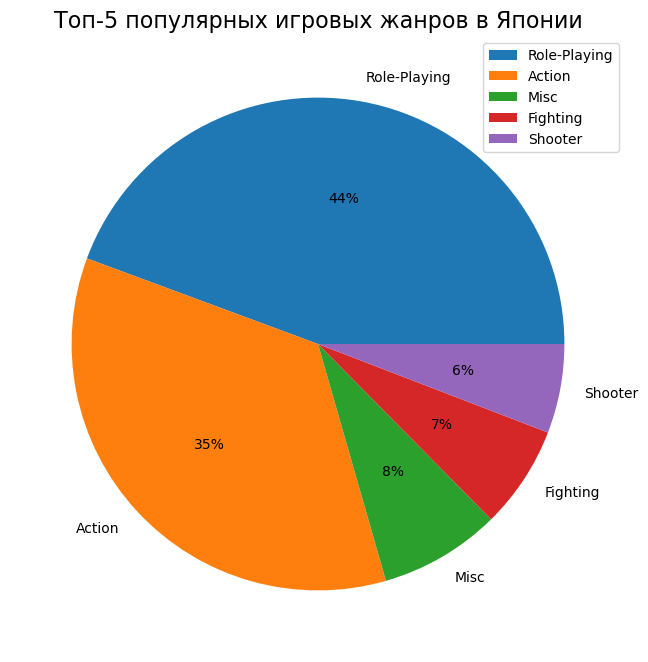

In [174]:
jp_data_genre.plot(kind='pie', y='jp_sales', autopct='%1.0f%%', figsize=(8,8))
plt.title('Топ-5 популярных игровых жанров в Японии', fontsize=16)
plt.ylabel('')
plt.legend()
plt.show()

Наиболее популярны в регионе игры в жанрах РПГ и Action

#### Посмотрим на стоимость игры в зависимости от рейтинга ESRB:

**Рейтинг ESRB:**
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»
- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»
<br />
Добавленный нами:
- «ND» («No data») — «Нет данных»

Напомним, что мы анализируем следующие рейтинги из датафрейма (не рассматриваем игры с "неустановленным" рейтингом (RP)):

In [175]:
ratings = act_data.query('rating != "RP"')['rating'].unique()
ratings

array(['M', 'ND', 'E', 'E10+', 'T'], dtype=object)

Построим "ящик с усами" для рейтингов игр

In [176]:
rating_medians = {}
rating_count = []
for rat in ratings:
    rating_medians[rat] = act_data.query('rating == @rat and jp_sales > 0')['jp_sales'].median()
    rating_count.append(act_data.query('rating == @rat and jp_sales > 0')['jp_sales'].count())

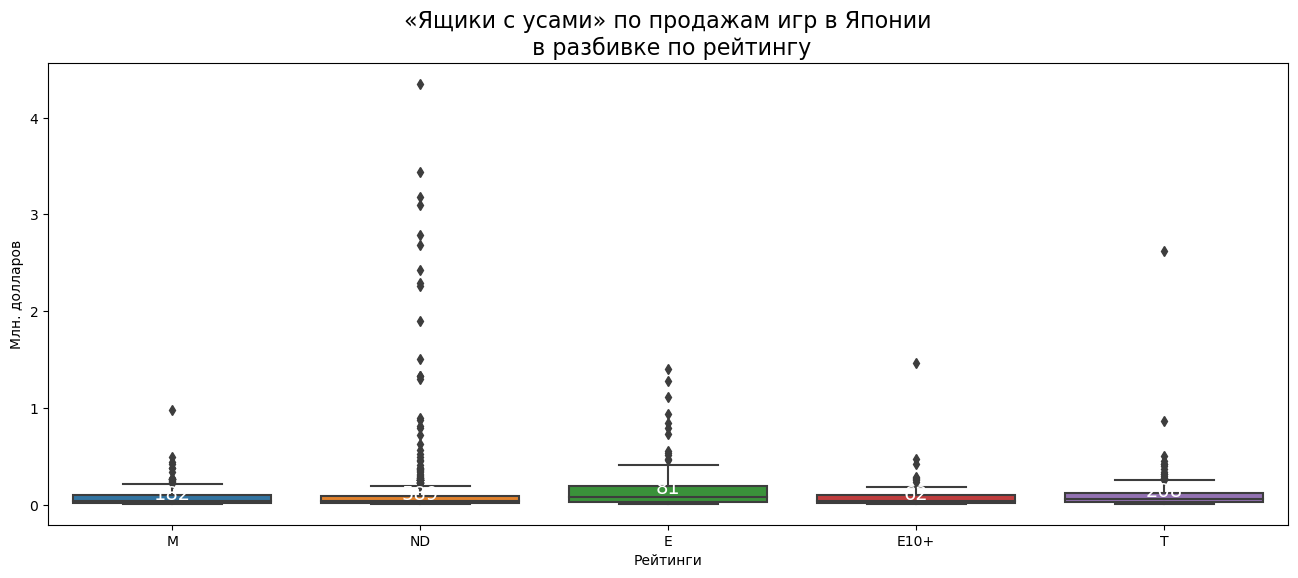

In [177]:
plt.figure(figsize=(16,6))
sns.boxplot(x="rating", y="jp_sales", data=act_data.query('rating !="RP" and jp_sales > 0'), notch=False)

for i in range(len(ratings)):
    plt.text(i, rating_medians[ratings[i]]*1.4, str(rating_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по продажам игр в Японии\n в разбивке по рейтингу', fontsize=16)
plt.xlabel('Рейтинги')
plt.ylabel('Млн. долларов')
plt.show()

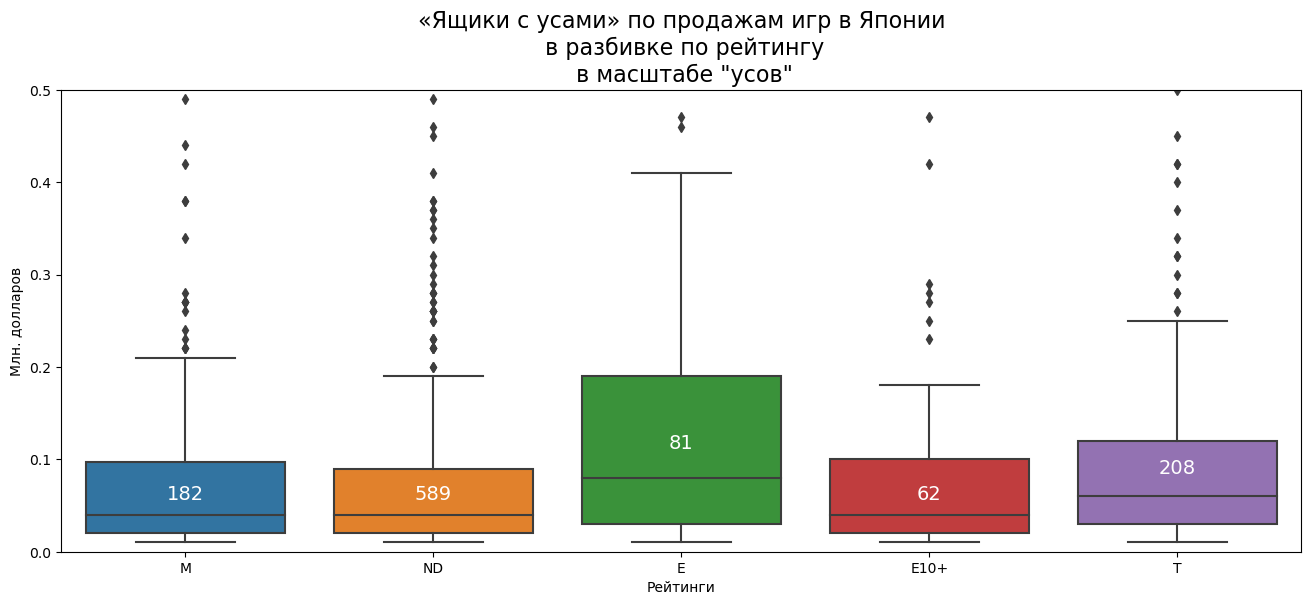

In [178]:
plt.figure(figsize=(16,6))
sns.boxplot(x="rating", y="jp_sales", data=act_data.query('rating !="RP" and jp_sales > 0'), notch=False)

for i in range(len(ratings)):
    plt.text(i, rating_medians[ratings[i]]*1.4, str(rating_count[i]), 
             horizontalalignment='center', fontdict={'size':14}, color='white')
    
plt.title('«Ящики с усами» по продажам игр в Японии\n в разбивке по рейтингу\n в масштабе "усов"', fontsize=16)
plt.ylim(0, 0.5)
plt.xlabel('Рейтинги')
plt.ylabel('Млн. долларов')
plt.show()

Цифра на "ящике" - количество игр, относящихся к данной категории

In [179]:
data_describe = pd.DataFrame(columns=['rating','count','mean','std','min','25%','50%','75%','max'])
for rat in ratings:
    desc = act_data.query('rating ==@rat and jp_sales > 0')['jp_sales'].describe().to_dict()
    desc['rating'] = rat
    data_describe = data_describe.append(desc, ignore_index=True)
data_describe

rating  count  mean  std  min  25%  50%  75%  max
0      M 182.00  0.08 0.11 0.01 0.02 0.04 0.10 0.98
1     ND 589.00  0.13 0.40 0.01 0.02 0.04 0.09 4.35
2      E  81.00  0.20 0.29 0.01 0.03 0.08 0.19 1.40
3   E10+  62.00  0.10 0.20 0.01 0.02 0.04 0.10 1.46
4      T 208.00  0.11 0.20 0.01 0.03 0.06 0.12 2.62

На первом месте - игры "для всех" (хоть их не очень много), на втором - "для тинейджеров".
Игры "18+" и "10+", а также игры с неуказанным рейтингом делят, c незначительным отставанием, 3 место.<br>
При этом количество игр без рейтинга (скорее всего, разработанных в Японии и не выходящих на другие рынки) составляет более 50% и они берут массой - их много и они дешевые. Кроме того, что самые прибыльные игры (хоть их и немного), относятся именно к этой категории. 

#### Итоговый портрет пользователя:

1. Предпочитает мобильные приставки японского производства
2. Играет в игры жанров РПГ и "Action".
3. Предпочитает игры с рейтингом "для всех, или "для тинейджеров", но не прочь поиграть и в другие игры, особенно в дешевые игры местного производства.

### Итог:  портреты пользователей

**Северная Америка:**
1. Предпочитает стационарные приставки Sony или Microsoft, причём обновил ее на новую версию или планирует это сделать в ближайшем будущем.
2. Играет в игры жанров "Action" и "Shooter", реже - в спортивные симуляторы и РПГ.
3. Предпочитает игры с рейтингами "для всех", или (несколько реже) "для взрослых".

**Европа:**
1. Предпочитает стационарные приставки Sony, причём обновил ее на новую версию.
2. Играет в игры жанров "Action" и "Shooter", реже - в спортивные симуляторы и РПГ.
3. Предпочитает игры с рейтингом "для взрослых" или (реже) "для всех" и "для всех от 10 лет" (скорее всего, зависит от жанра игры).

**Япония:**
1. Предпочитает мобильные приставки японского производства
2. Играет в игры жанров РПГ и "Action".
3. Предпочитает игры с рейтингом "для всех, или "для тинейджеров", но не прочь поиграть и в другие игры, особенно в дешевые игры местного производства.

## **Проверка гипотез:**

Шаг 5. Проверьте гипотезы
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
Задайте самостоятельно пороговое значение alpha.
Поясните:
Как вы сформулировали нулевую и альтернативную гипотезы;
Какой критерий применили для проверки гипотез и почему.

### Проверка гипотезы: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

#### Формулировка гипотез:

**Нулевая гипотеза:**
Средние пользовательские рейтинги платформ Xbox One и PC равны

**Альтернативная гипотеза:**
Средние пользовательские рейтинги платформ Xbox One и PC неравны

По сути, у нас есть две генеральных совокупности - одна, состоящая из рейтингов игр для Xbox One , вторая - из рейтингов игр для PC.<br />
Поэтому мы проверяем гипотезу о равенстве средних двух генеральных совокупностей.

#### Подготовим данные для анализа:

In [180]:
xone_user_scores = act_data.query('platform == "XOne" and user_score.notna()')['user_score']

In [181]:
pc_user_scores = act_data.query('platform == "PC" and user_score.notna()')['user_score']

#### Найдем параметры распределений выборок и построим их графики:

**XBox One:**

In [182]:
xone_user_scores.describe()

count   182.00
mean      6.52
std       1.38
min       1.60
25%       5.80
50%       6.80
75%       7.50
max       9.20
Name: user_score, dtype: float64

Среднее значение выборки:

In [183]:
xone_mean = xone_user_scores.describe()['mean']
xone_mean

6.52142857142857

Стандартное отклонение:

In [184]:
xone_std = xone_user_scores.describe()['std']
xone_std

1.3809405645921442

**PC:**

In [185]:
pc_user_scores.describe()

count   158.00
mean      6.28
std       1.74
min       1.40
25%       5.33
50%       6.80
75%       7.60
max       9.30
Name: user_score, dtype: float64

Среднее значение выборки:

In [186]:
pc_mean = pc_user_scores.describe()['mean']
pc_mean

6.2803797468354405

Стандартное отклонение:

In [187]:
pc_std = pc_user_scores.describe()['std']
pc_std

1.7350437818503355

**Графики:**

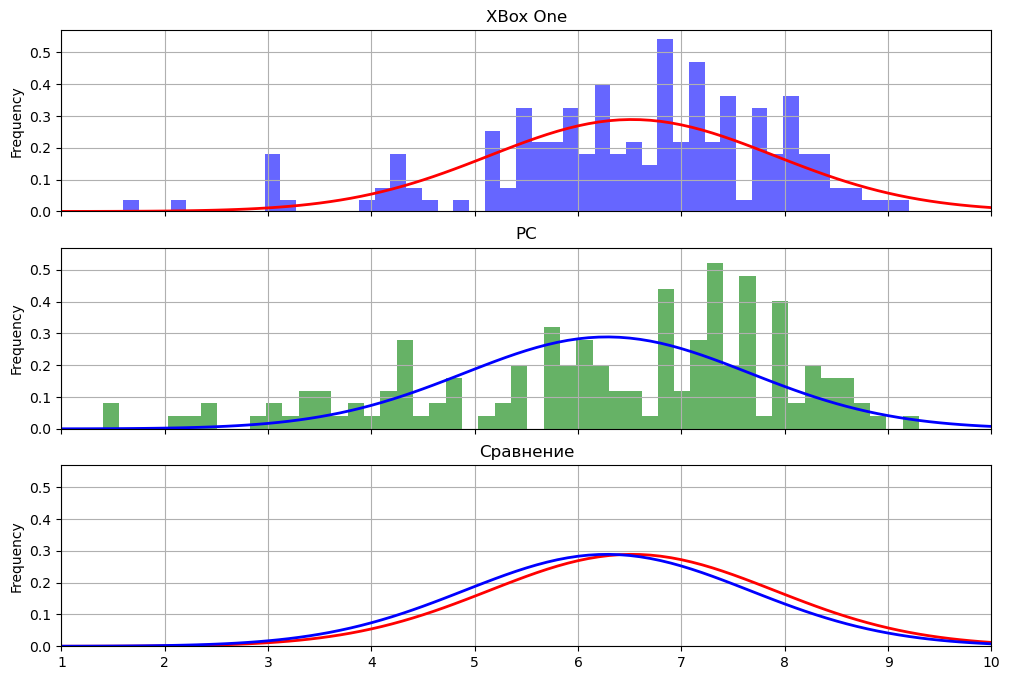

In [188]:
xmin = 1
xmax = 10
accuracy = 0.1
xpoints = int((xmax-xmin)/accuracy + 1)

#Данные для оси Х
grafic_x = [ round(x, 1) for x in np.linspace(xmin, xmax, xpoints)]

fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex='all',sharey='all')
plt.xlim(xmin, xmax)
ax_1.set(title = 'XBox One')
ax_2.set(title = 'PC')
ax_3.set(title = 'Сравнение')

#Гистограммы
xone_user_scores.plot(kind = 'hist',ax=ax_1, bins=50, density=True, alpha=0.6, color='b', grid=True)
pc_user_scores.plot(kind = 'hist',ax=ax_2, bins=50, density=True, alpha=0.6, color='g', grid=True)
pc_user_scores.plot(kind = 'hist',ax=ax_3, bins=50, density=True, alpha=0.6, color='w', grid=True)

#Графики
xone_p = norm.pdf(grafic_x, xone_mean, xone_std)
ax_1.plot(grafic_x, xone_p, linewidth=2.0, color='r')
ax_3.plot(grafic_x, xone_p, linewidth=2.0, color='r')

pc_p = norm.pdf(grafic_x, pc_mean, xone_std)
ax_2.plot(grafic_x, pc_p, linewidth=2.0, color='b')
ax_3.plot(grafic_x, pc_p, linewidth=2.0, color='b')
plt.show()

#### T-тест Стьюдента

Дисперсии выборок:

In [189]:
xone_std**2

1.90699684293607

In [190]:
pc_std**2

3.0103769249375145

Дисперсии выборок не равны, поэтому параметр equal_var задаем равной False

Уровень значимости зададим равным 5%

In [191]:
alpha=0.05

In [192]:
result = st.ttest_ind(xone_user_scores, pc_user_scores, equal_var=False)

p - значение (вероятность получить наблюдаемый результат, при условии, что нулевая гипотеза верна):

In [193]:
result.pvalue

0.16174359801784316

p - значение значительно выше заданного нами уровня значимости (больше 16%), поэтому мы принимаем нулевую гипотезу.

#### Вывод:
Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC равны" принимается

### Проверка гипотезы: "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"

#### Формулировка гипотез:

**Нулевая гипотеза:**
Средние пользовательские рейтинги жанров Action и Sports - равны

**Альтернативная гипотеза:**
Средние пользовательские рейтинги жанров Action и Sports - разные

По сути, у нас есть две генеральных совокупности - одна, состоящая из рейтингов игр жанрa Action, вторая - из жанра Sports.<br />
Поэтому мы проверяем гипотезу о равенстве средних двух генеральных совокупностей.

#### Подготовим данные для анализа:

In [194]:
action_user_scores = act_data.query('genre == "Action" and user_score.notna()')['user_score']

In [195]:
sports_user_scores = act_data.query('genre == "Sports" and user_score.notna()')['user_score']

#### Найдем параметры распределений выборок и построим их графики:

**Action:**

In [196]:
action_user_scores.describe()

count   390.00
mean      6.85
std       1.32
min       2.00
25%       6.30
50%       7.10
75%       7.80
max       9.10
Name: user_score, dtype: float64

Среднее значение выборки:

In [197]:
action_mean = action_user_scores.describe()['mean']
action_mean

6.849487179487181

Стандартное отклонение:

In [198]:
action_std = action_user_scores.describe()['std']
action_std

1.3216750467271163

**Sports:**

In [199]:
sports_user_scores.describe()

count   157.00
mean      5.31
std       1.73
min       1.40
25%       4.10
50%       5.60
75%       6.60
max       8.80
Name: user_score, dtype: float64

Среднее значение выборки:

In [200]:
sports_mean = sports_user_scores.describe()['mean']
sports_mean

5.313375796178345

Стандартное отклонение:

In [201]:
sports_std = pc_user_scores.describe()['std']
sports_std

1.7350437818503355

**Графики:**

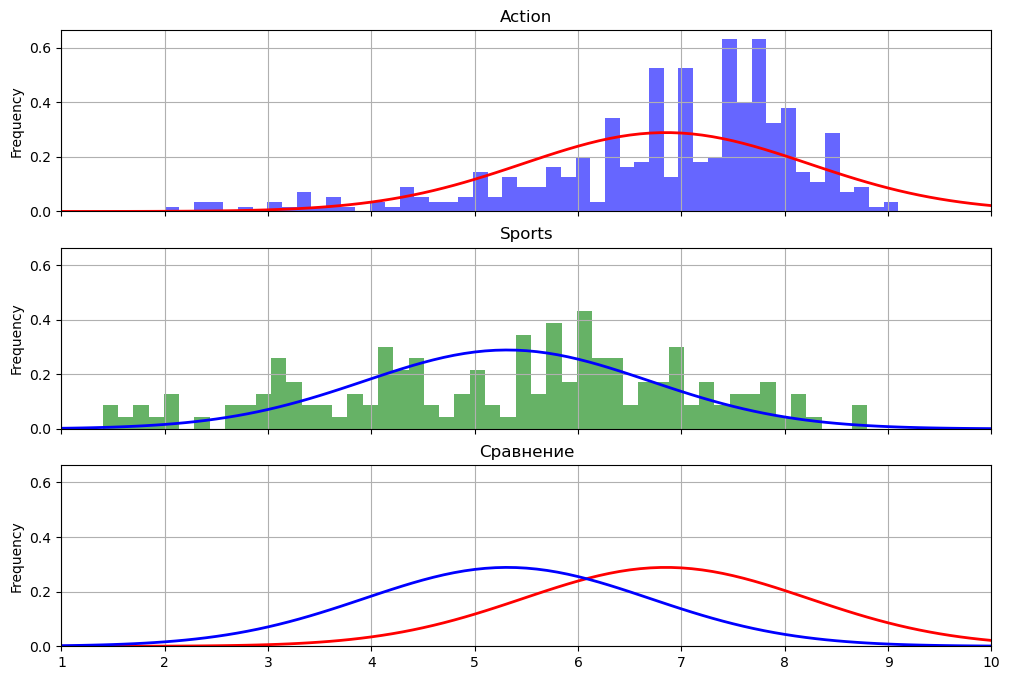

In [202]:
xmin = 1
xmax = 10
accuracy = 0.1
xpoints = int((xmax-xmin)/accuracy + 1)

#Данные для оси Х
grafic_x = [ round(x, 1) for x in np.linspace(xmin, xmax, xpoints)]

fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex='all',sharey='all')
plt.xlim(xmin, xmax)
ax_1.set(title = 'Action')
ax_2.set(title = 'Sports')
ax_3.set(title = 'Сравнение')

#Гистограммы
action_user_scores.plot(kind = 'hist',ax=ax_1, bins=50, density=True, alpha=0.6, color='b', grid=True)
sports_user_scores.plot(kind = 'hist',ax=ax_2, bins=50, density=True, alpha=0.6, color='g', grid=True)
sports_user_scores.plot(kind = 'hist',ax=ax_3, bins=50, density=True, alpha=0.6, color='w', grid=True)

#Графики
action_p = norm.pdf(grafic_x, action_mean, xone_std)
ax_1.plot(grafic_x, action_p, linewidth=2.0, color='r')
ax_3.plot(grafic_x, action_p, linewidth=2.0, color='r')

sports_p = norm.pdf(grafic_x, sports_mean, xone_std)
ax_2.plot(grafic_x, sports_p, linewidth=2.0, color='b')
ax_3.plot(grafic_x, sports_p, linewidth=2.0, color='b')
plt.show()

#### T-тест Стьюдента

В данной ситуации имеет проверять т-тестом альтернативную гипотезу.

Дисперсии выборок:

In [203]:
action_std**2

1.746824929141125

In [204]:
sports_std**2

3.0103769249375145

Дисперсии выборок не равны, поэтому параметр equal_var задаем равной False

Уровень значимости зададим равным 5%

In [205]:
alpha=0.05

In [206]:
result = st.ttest_ind(action_user_scores, sports_user_scores, equal_var=False)

p - значение (вероятность получить наблюдаемый результат, при условии, что нулевая гипотеза верна):

In [207]:
result.pvalue

7.698368759426728e-20

p - значение значительно ниже заданного нами уровня значимости (стремится к 0), поэтому мы отвергаем нулевую гипотезу, а принимаем альтернативную.

#### Вывод:
Гипотеза "Средние пользовательские рейтинги жанров Action и Sports - разные" принимается

### Итоги проверки гипотез:
1. Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC равны" принимается
2. Гипотеза "Средние пользовательские рейтинги жанров Action и Sports - разные" принимается

## **Общие выводы:**

### Анализ входной информации

1. В предоставленных данных находится информация о 16715 компьютерных играх, выпущенных с 1980 по 2016 годы.
2. Состояние данных - среднее, много пропущенных данных.
3. Часть данных требует предобработки

### Результаты подготовки данных

1. Удалены данные о 2 играх, не имеющих информации о наименование.
Пропуски в  остальных данных частично заполнены, в том числе, за счёт взаимного использования информации из об тех же играх на других платформах, пропуски в рейтинге ESRB заполнены значением-"заглушкой"<br />
2. Удалены дубликаты
3. Добавлены новые столбцы, которые облегчают проведение предобработки и анализа данных
4. После предобработки данные подготовлены к проведению исследовательского анализа

### Итоги исследовательского анализа данных:

1. На момент исследования в продаже присутствуют игры для 8 платформ:
- стационарных: 
    - Sony PlayStation 3;
    - Sony PlayStation 4;
    - Microsoft ХBox 360;
    - Microsoft ХBox One;
    - Nintendo Wii U;
- мобильных:
    - Sony PS Vita;
    - Nintendo 3DS
- для персонального компьютера (PC)

2. Актуальным сожно считать период, в который все эти платформы существуют, то есть с 2013 по 2016г.<br /><br />

3. Больше всего игр (по количеству, за весь период наблюдений) было выпущено для платформ:
- за весь период наблюдений:
    - Sony PlayStation 2 - 2161;
    - Nintendo DS - 2151;
    - Sony PlayStation 3 - 1329;
    - Nintendo Wii U - 1320;
    - Microsoft ХBox 360- 1262;
- за актуальный период:
    - Sony PlayStation 4 - 392;
    - Sony PS Vita - 359;
    - Sony PlayStation 3 - 345;
    - Nintendo 3DS - 308;
    - Microsoft ХBox One - 247.

4. Наибольшие суммы продаж (в млн. долларов) у игр для платформ:
- за весь период наблюдений:
    - Sony PlayStation 2 - 1 255.77 
    - Microsoft ХBox 360 - 971.42
    - Sony PlayStation 3 - 939.16;
    - Nintendo Wii U - 907.51;
    - Nintendo DS - 806.12;
- за актуальный период:
    - Sony PlayStation 4 - 314.14;
    - Sony PlayStation 3 - 181.43;
    - Microsoft ХBox One - 159.32;
    - Nintendo 3DS - 143.72;    
    - Microsoft ХBox 360 - 136.80
    
5. Обычно в год появляется от 0 до 2 игровых платформ, срок жизни которых обычно равен 6-12 лет. Исключением является платформа PC, которой на момент исследования 46 лет.<br /><br />

6. Если не рассматривать данные 2016 года (по условиям задачи, он еще не окончился, а предновогодние продажи могут сильно изменить статистику), то 
- pастут продажи у Playstation 4 и Xbox One, 
- более-менее стабильные (стабильно-низкие) показатели у PC,  Playstation Vita  и Wii U, 
- продажи падают у   Playstation 3, XBox 360 и Nintendo 3DS. 

7. Потенциально выгодными являются Sony PlayStation 4, Microsoft ХBox One и Nintendo 3DS, а также (из-за принципиального отличия) - PC<br /><br />

8. Оценка диаграмы размаха данных о доходах игр:
- Наибольшую прибыль чаще всего приносят игры для станционарных консолей, при этом игры для PlayStation 3 приносят меньше прибыли - пользователи уже стали активно перебираться на PlayStation 4. 
- Игры для мобильных консолей приносят меньше прибыли, чем стационарные. Из них лидирует Nintendo 3DS, а PlayStation Vita - опять явный аутсайдер.
- Игры для PC обычно приносят в 2-3 раза меньше, чем игры для стационарных конслей, поскольку, как говорилось выше, сами игры для PC дешевле в 2-3 раза.

9. Влияние на продажи отзывов пользователей и критиков для разных платформ:
- PlayStation 4:
    - Есть частичная зависимость между оценками критиков и продажами игр.
    - Оценки пользователей не влияют на продажи во всех регионах, за исключением Японии - там наблюдается слабая корреляция (и, при этом, небольшое уменьшение влияния критиков).
- XBox One:
    - Есть частичная зависимость между оценками критиков и продажами игр во всех регионах, кроме Японии - там зависимость значительно слабее.
    - Оценки пользователей не влияют на продажи во всех регионах.
- Nintendo 3DS:
    - Есть частичная зависимость между оценками критиков и продажами игр.
    - Есть несколько меньшая зависимость между оценками критиков и продажами игр.
    - В Японии эти зависимости почти одинаковы.
- PC:
    - Есть небольшая зависимость между оценками критиков и продажами игр
    - Оценки пользователей минимально влияют на продажи (причем - отрицательно!)
    - В Японии не продаются игры для PC

10. Распределение игр по жанрам:
- Топ5 по количеству выпущенных игр (в порядке убывания):
    - Экшен (с большим отрывом)
    - РПГ
    - Приключения
    - Спортивные симуляторы
    - Шутеры.
- Топ5 по суммам продаж (в порядке убывания):
    - Экшен
    - Шутеры
    - Спортивные симуляторы
    - РПГ
    - Игры смешанного жанра
- Топ5 по средней сумме продаж с одной игры (в порядке убывания):
    - Шутеры (с большим отрывом)
    - Спортивные симуляторы
    - Платформенные игры
    - РПГ
    - Автосимуляторы.

### Портреты пользователей из разных регионов

**Северная Америка:**
1. Предпочитает стационарные приставки Sony или Microsoft, причём обновил ее на новую версию или планирует это сделать в ближайшем будущем.
2. Играет в игры жанров "Action" и "Shooter", реже - в спортивные симуляторы и РПГ.
3. Предпочитает игры с рейтингом "для взрослых" или (реже) "для всех от 10 лет" (скорее всего, зависит от жанра игры).

**Европа:**
1. Предпочитает стационарные приставки Sony, причём обновил ее на новую версию.
2. Играет в игры жанров "Action" и "Shooter", реже - в спортивные симуляторы и РПГ.
3. Предпочитает игры с рейтингом "для взрослых" или (реже) "для всех" и "для всех от 10 лет" (скорее всего, зависит от жанра игры).

**Япония:**
1. Предпочитает мобильные приставки японского производства
2. Играет в игры жанров РПГ и "Action".
3. Предпочитает игры с рейтингом "для всех, или "для тинейджеров", но не прочь поиграть и в другие игры, особенно в дешевые игры местного производства.

### Результат проверки гипотез:

1. Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC равны" принимается
2. Гипотеза "Средние пользовательские рейтинги жанров Action и Sports - разные" принимается

### Итог

Все поставленные задачи по проекту выполнены.